In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from qresearch.backtest.metrics import yearly_returns

## Copper Oil Ratio

In [3]:
TICKERS = ['HG=F', 'CL=F']
start_date = '2000-01-01'
end_date = '2025-12-31'

df = yf.download(TICKERS, start_date, end_date)
df.dropna(inplace=True)

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_67950/3737714327.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKERS, start_date, end_date)
[*********************100%***********************]  2 of 2 completed


(0.0, 5.0)

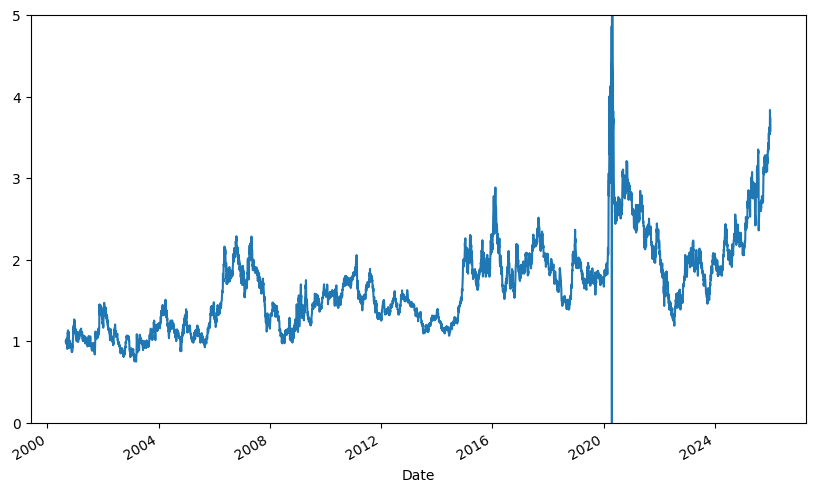

In [4]:
# copper oil ratio
close_df = df['Close']
copper_oil_ratio = close_df['HG=F'] / close_df['CL=F'] / (close_df['HG=F'] / close_df['CL=F']).iloc[0]
copper_oil_ratio.plot(figsize=(10, 6))
plt.ylim(0, 5)

## HSTECH, HSI

In [5]:
STOCKS = ['^HSI', '3032.HK']
stocks_df = yf.download(STOCKS, start_date, end_date)

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_67950/2209861312.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks_df = yf.download(STOCKS, start_date, end_date)
[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

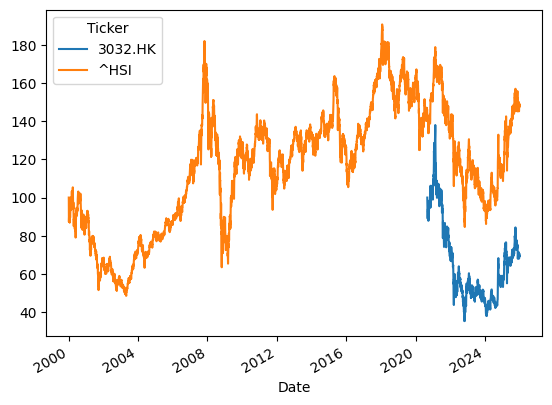

In [6]:
# 1. Identify the first non-NaN value for each column (stock)
first_valid_prices = stocks_df['Close'].apply(lambda x: x.dropna().iloc[0])

# 2. Scale the entire dataframe
# This divides every price by the stock's own starting price
indexed_df = (stocks_df['Close'] / first_valid_prices) * 100

# 3. Handling NaNs
# You usually want to keep them as NaN until the stock actually starts trading
# so that your plot doesn't start at 0.
indexed_df.plot()

Text(0.5, 1.0, 'Hang Seng Index / Hang Seng Tech Index Ratio')

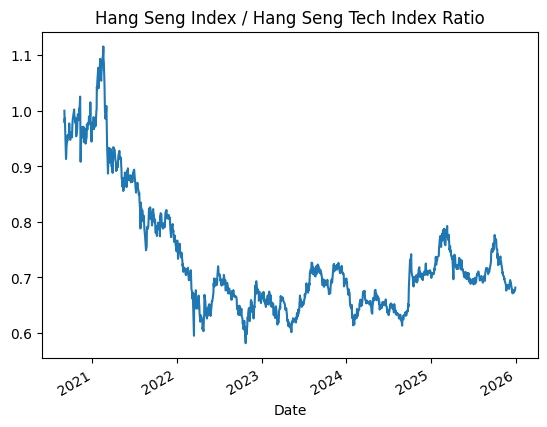

In [7]:
indexed_2020_df = (stocks_df.Close.dropna() / stocks_df.Close.dropna().iloc[0])

(indexed_2020_df['3032.HK'] / indexed_2020_df['^HSI']).plot()
plt.title('Hang Seng Index / Hang Seng Tech Index Ratio')

## Relationships

In [8]:
close_df = close_df.merge(
    stocks_df['Close']['^HSI'],
    how='inner',
    left_index=True,
    right_index=True
)

indexed_df = close_df / close_df.iloc[0]
indexed_df['HG/CL'] = indexed_df['HG=F'] / indexed_df['CL=F']

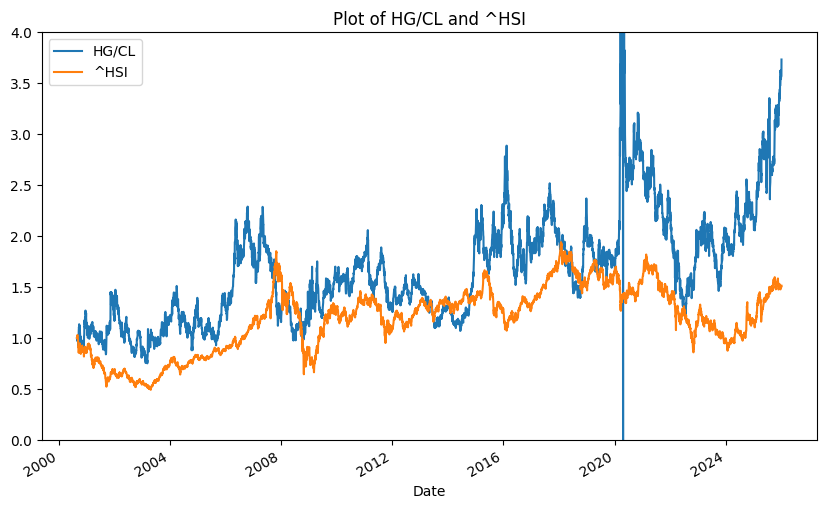

In [9]:
indexed_df[['HG/CL', '^HSI']].plot(figsize=(10, 6))
plt.title('Plot of HG/CL and ^HSI')
plt.ylim(0, 4)
plt.show()

In [10]:
indexed_df.pct_change().corr()

,CL=F,HG=F,^HSI,HG/CL
CL=F,1.000000,0.170198,0.074264,0.335707
HG=F,0.170198,1.000000,0.265810,0.159569
^HSI,0.074264,0.265810,1.000000,0.034626
HG/CL,0.335707,0.159569,0.034626,1.000000


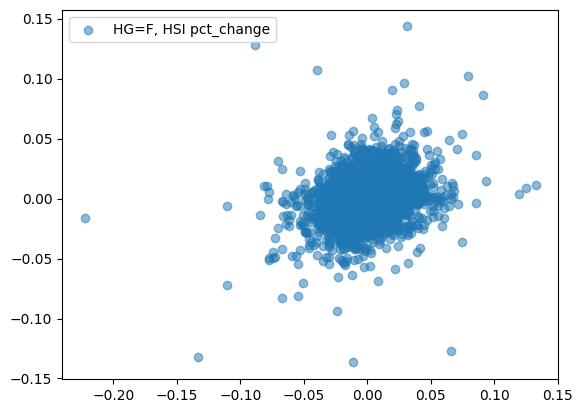

In [11]:
plt.scatter(x=indexed_df['HG=F'].pct_change(), y=indexed_df['^HSI'].pct_change(), alpha=0.5, label='HG=F, HSI pct_change')
plt.legend()
plt.show()

## Lag?

In [12]:
def return_cross_correlation(_indexed_df, signal, benchmark):
    # Calculate weekly percentage changes (Returns)
    ret_sig = _indexed_df[signal].pct_change()
    ret_bm = _indexed_df[benchmark].pct_change()
    
    # Calculate correlation of Ratio(t) with HSI(t + lag)
    lags = range(-50, 51)
    return_corrs = [ret_sig.corr(ret_bm.shift(-l)) for l in lags]
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, return_corrs, color='skyblue')
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Return Cross-Correlation (The Real Signal Detector)')
    plt.xlabel('Lag (Weeks)')
    plt.ylabel('Correlation of Returns')
    plt.show()

def signal_backtest(_indexed_df, signal, benchmark, fwd_w=2, big_move_percentile=0.9):    
    # 1. Define a "Big Move" in the ratio (e.g., top 10% of weekly gains)
    threshold = _indexed_df[signal].pct_change().quantile(big_move_percentile)
    _indexed_df['Signal'] = _indexed_df[signal].pct_change() > threshold
    
    # 2. Look at HSI returns x weeks after that signal
    _indexed_df[f'Forward_{fwd_w}wk_Ret'] = _indexed_df[benchmark].pct_change(fwd_w).shift(-fwd_w)
    
    # 3. Compare 'Normal Days' vs 'Signal Days'
    hit_rate = _indexed_df[_indexed_df['Signal'] == True][f'Forward_{fwd_w}wk_Ret']
    avg_ret = _indexed_df[f'Forward_{fwd_w}wk_Ret'].mean()
    
    print(f"Average {fwd_w}-week {benchmark} Return: {avg_ret:.2%}")
    print(f"Average Return after {signal} Spike: {hit_rate.mean():.2%}")
    print(f"Win Rate after Spike: {(hit_rate > 0).mean():.2%}")

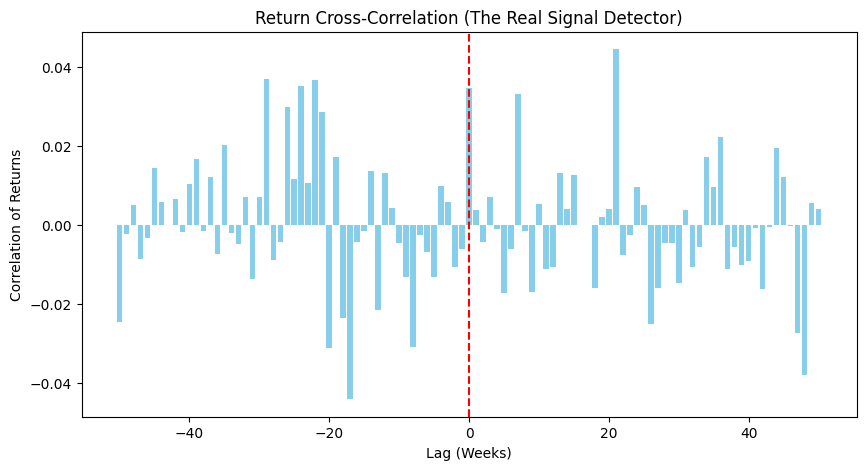

Average 9-week ^HSI Return: 0.15%
Average Return after HG/CL Spike: 0.25%
Win Rate after Spike: 54.04%


In [13]:
# return_cross_correlation(indexed_df, 'HG=F', '^HSI')
return_cross_correlation(indexed_df, 'HG/CL', '^HSI')
signal_backtest(indexed_df, 'HG/CL', '^HSI', fwd_w=9)

## Rolling Z-score Regression

In [155]:
def predictive_power_analysis(_indexed_df, signal, benchmark):
    # Use pct_change to ensure we are looking at returns (stationary data)
    returns_df = _indexed_df[[signal, benchmark]].pct_change().dropna()
    
    # Calculate correlation at different lags
    lags = range(0, 21)  # Look ahead 0 to 50 weeks
    lagged_corrs = {lag: returns_df[signal].corr(returns_df[benchmark].shift(-lag)) for lag in lags}
    
    # Plotting the lag effect
    plt.figure(figsize=(10, 5))
    plt.bar(lagged_corrs.keys(), lagged_corrs.values(), color='teal')
    plt.axhline(0, color='black', lw=1)
    plt.title(f'Predictive Power: Correlation of {signal}(t) with {benchmark}(t + Lag)')
    plt.xlabel(f'Lag in Weeks (How many weeks into the future {benchmark} is predicted)')
    plt.ylabel('Correlation Coefficient')
    plt.show()
    
    # 1. Define the Signal: 1-week change in the Ratio
    _indexed_df['signal'] = _indexed_df[signal].pct_change()
    
    # 2. Define the Target: 4-week forward return of benchmark
    # We shift benchmark backwards to bring the "future" return to today's row
    _indexed_df[f'{benchmark}_4wk_forward_ret'] = _indexed_df[benchmark].pct_change(4).shift(-4)
    
    # 3. Clean and Plot
    analysis_df = _indexed_df[['signal', f'{benchmark}_4wk_forward_ret']].dropna()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(analysis_df['signal'], analysis_df[f'{benchmark}_4wk_forward_ret'], alpha=0.4)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel(f'{signal} Change (This Week)')
    plt.ylabel(f'{benchmark} Return (Next 4 Weeks Combined)')
    plt.title(f'Is a Rising {signal} a Buy Signal for {benchmark}?')
    plt.show()
    
    print(f"Correlation between Signal and 4-Week Forward Return: {analysis_df.corr().iloc[0,1]:.4f}")
    

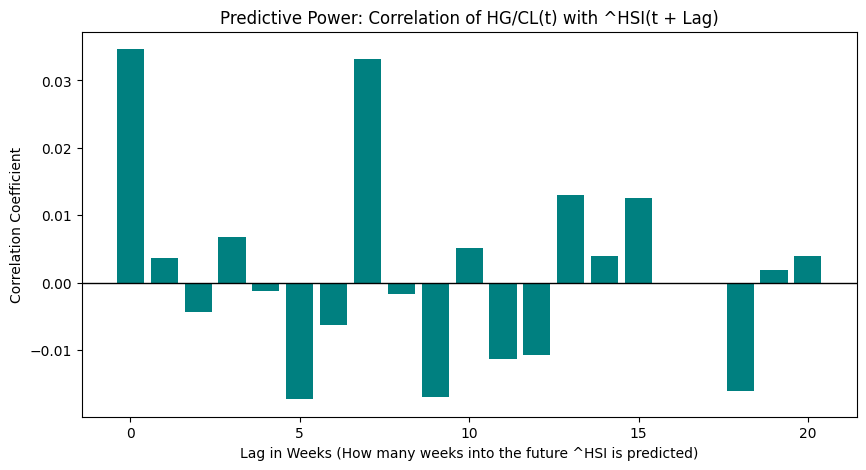

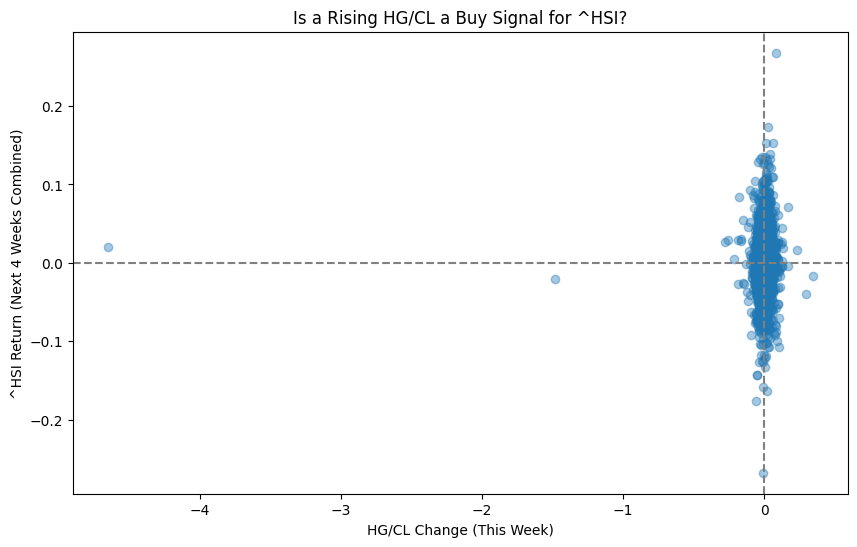

Correlation between Signal and 4-Week Forward Return: 0.0027


In [156]:
predictive_power_analysis(indexed_df, 'HG/CL', '^HSI')

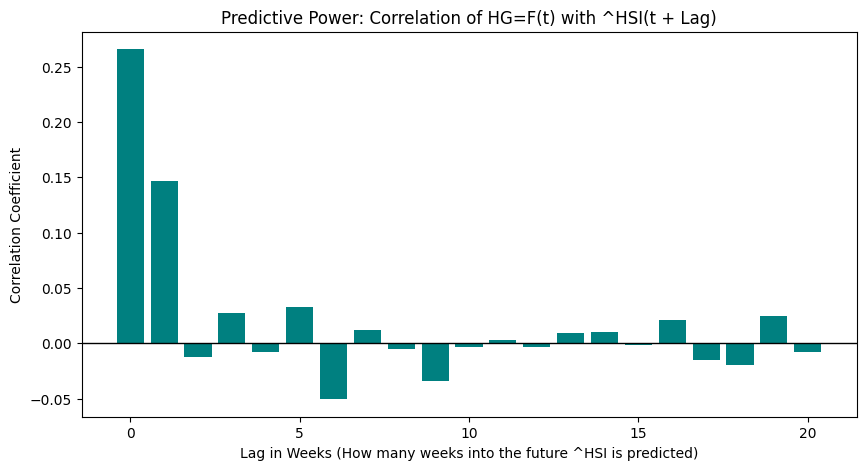

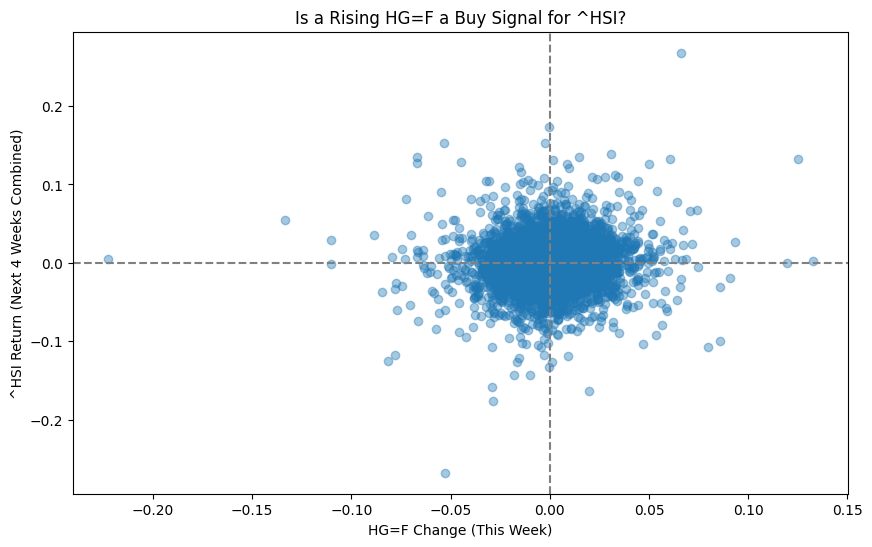

Correlation between Signal and 4-Week Forward Return: 0.0802


In [157]:
predictive_power_analysis(indexed_df, 'HG=F', '^HSI')

In [158]:
df = indexed_df[['HG=F', 'CL=F', '^HSI']]
df.columns = ['copper', 'oil', '^HSI']

In [159]:
import statsmodels.api as sm

def logret(s: pd.Series) -> pd.Series:
    return np.log(s).diff()

def fwd_logret(price: pd.Series, k: int) -> pd.Series:
    return np.log(price).shift(-k) - np.log(price)

def rolling_zscore(x: pd.Series, w: int = 252) -> pd.Series:
    mu = x.rolling(w).mean()
    sd = x.rolling(w).std()
    return (x - mu) / sd

def lead_lag_regression(df, x_col, y_price_col, ks=(5,10,20,60,120,180), add_controls=True):
    out = []
    for k in ks:
        y = fwd_logret(df[y_price_col], k)
        X = pd.DataFrame({x_col: df[x_col]})
        if add_controls:
            # 20d trailing return as control
            X["mom20"] = (np.log(df[y_price_col]) - np.log(df[y_price_col]).shift(20))
        X = sm.add_constant(X)

        data = pd.concat([y, X], axis=1).dropna()
        y2 = data.iloc[:, 0]
        X2 = data.iloc[:, 1:]

        # HAC standard errors for overlapping returns
        model = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": max(k-1, 1)})

        out.append({
            "k": k,
            "beta": model.params.get(x_col, np.nan),
            "tstat": model.tvalues.get(x_col, np.nan),
            "pval": model.pvalues.get(x_col, np.nan),
            "r2": model.rsquared,
            "n": int(model.nobs),
        })
    return pd.DataFrame(out)

# Example feature construction:
df["co_ratio"] = df["copper"] / df["oil"]
df["x"] = logret(df["co_ratio"])          # fast version
df["x_z"] = rolling_zscore(np.log(df["co_ratio"]), 252)  # slow version

res_fast = lead_lag_regression(df, x_col="x", y_price_col="^HSI")
res_slow = lead_lag_regression(df, x_col="x_z", y_price_col="^HSI")


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_44942/3402807323.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["co_ratio"] = df["copper"] / df["oil"]
/Users/henrywzh/Desktop/Quant/Research/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_44942/3402807323.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x"]

=== Lead–Lag results (FAST: dlog(C/O)) ===
     k      beta        se     tstat      pval        r2     n     ci_lo  \
0    5  0.012470  0.019859  0.627949  0.530037  0.000194  6039 -0.026453   
1   10  0.004849  0.026697  0.181629  0.855874  0.000012  6034 -0.047477   
2   20  0.017631  0.027805  0.634114  0.526006  0.000085  6024 -0.036866   
3   60  0.049917  0.043481  1.148014  0.250963  0.000218  5984 -0.035306   
4  120  0.167559  0.069019  2.427708  0.015195  0.000999  5924  0.032281   
5  150  0.182033  0.081900  2.222622  0.026241  0.000773  5894  0.021509   
6  180  0.156337  0.092583  1.688617  0.091293  0.000865  5864 -0.025125   

      ci_hi  
0  0.051393  
1  0.057175  
2  0.072129  
3  0.135139  
4  0.302837  
5  0.342557  
6  0.337798  

=== Lead–Lag results (SLOW: zscore(log(C/O))) ===
     k      beta        se     tstat      pval        r2     n     ci_lo  \
0    5  0.001428  0.000668  2.137714  0.032540  0.003934  5558  0.000119   
1   10  0.002850  0.001213  2.350

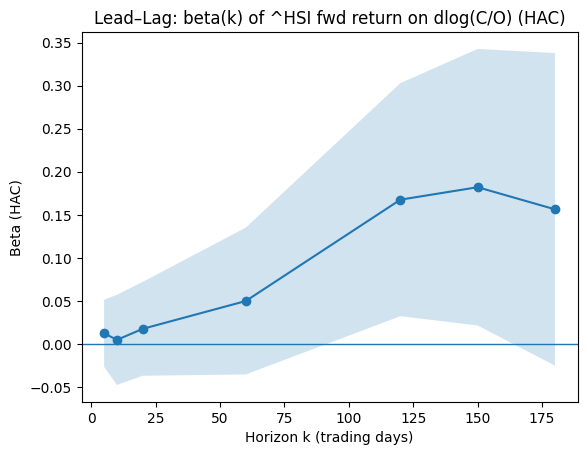

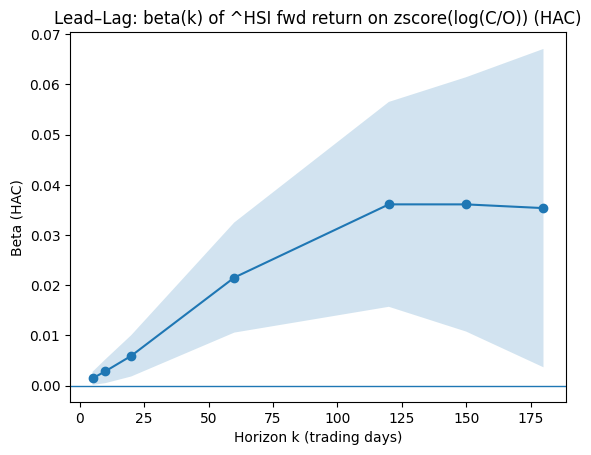


=== Placebo / Reverse direction (^HSI -> C/O ratio) ===
     k      beta        se     tstat      pval        r2     n     ci_lo  \
0    5 -0.041440  0.058405 -0.709530  0.477996  0.000116  6058 -0.155915   
1   10 -0.099975  0.078493 -1.273683  0.202776  0.000345  6053 -0.253821   
2   20 -0.126911  0.092438 -1.372929  0.169774  0.000296  6043 -0.308089   
3   60 -0.245424  0.156401 -1.569198  0.116602  0.000440  6003 -0.551969   
4  120 -0.190358  0.182120 -1.045235  0.295914  0.000178  5943 -0.547313   
5  150 -0.239388  0.183354 -1.305607  0.191686  0.000231  5913 -0.598763   
6  180 -0.359123  0.217389 -1.651982  0.098538  0.000449  5883 -0.785206   

      ci_hi  
0  0.073034  
1  0.053871  
2  0.054268  
3  0.061122  
4  0.166597  
5  0.119986  
6  0.066960  


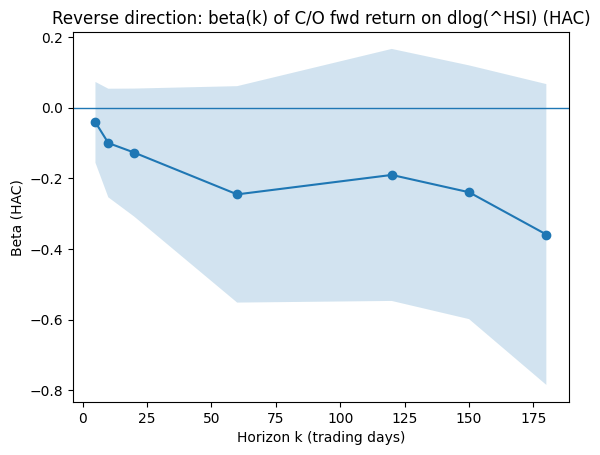

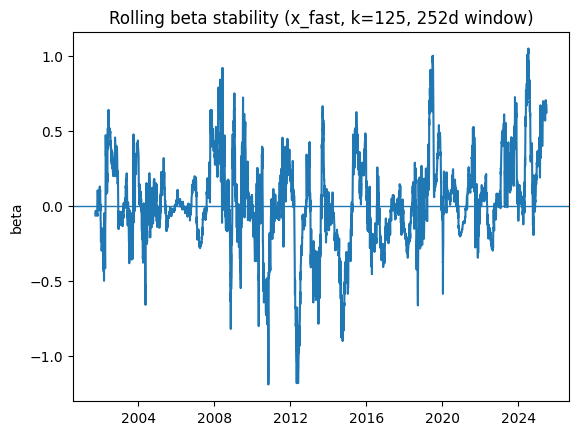

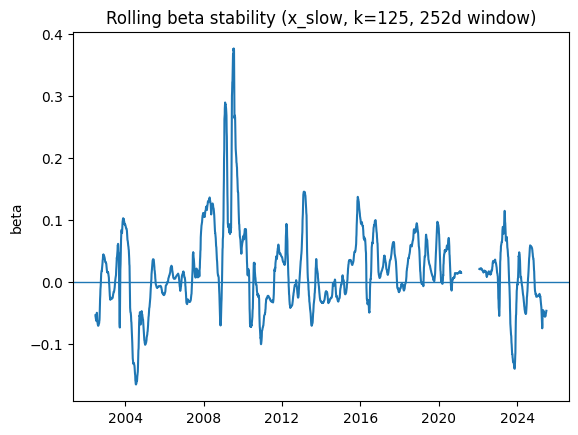


=== Weekly Lead–Lag (FAST) ===
    k      beta        se     tstat      pval        r2     n     ci_lo  \
0   1 -0.010663  0.017706 -0.602208  0.547036  0.000533  1302 -0.045366   
1   2 -0.009775  0.023175 -0.421800  0.673171  0.000408  1301 -0.055198   
2   4 -0.008784  0.026433 -0.332305  0.739659  0.001090  1299 -0.060592   
3   8  0.004635  0.035404  0.130913  0.895844  0.001997  1295 -0.064756   
4  12  0.015601  0.038349  0.406816  0.684143  0.001709  1291 -0.059563   
5  24  0.163555  0.069887  2.340289  0.019269  0.003631  1279  0.026577   
6  30  0.154992  0.067350  2.301292  0.021375  0.003436  1273  0.022986   

      ci_hi  
0  0.024041  
1  0.035648  
2  0.043025  
3  0.074026  
4  0.090764  
5  0.300533  
6  0.286998  

=== Weekly Lead–Lag (SLOW) ===
    k      beta        se     tstat      pval        r2     n     ci_lo  \
0   1  0.001143  0.000672  1.700714  0.088997  0.002563  1219 -0.000174   
1   2  0.002416  0.001133  2.132376  0.032976  0.005713  1218  0.000195  

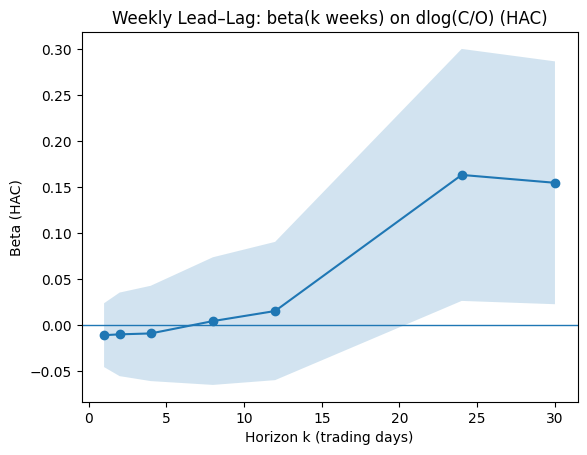

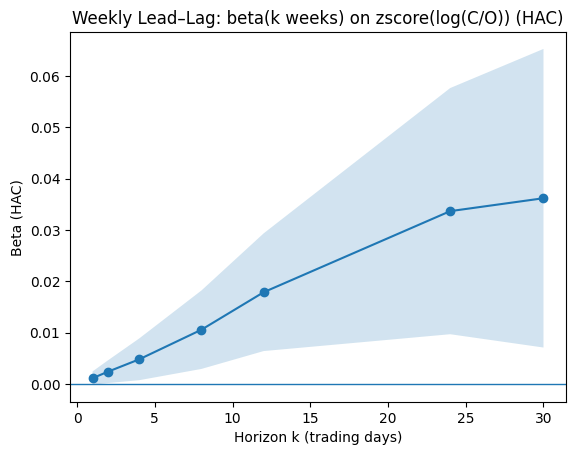


=== OOS Expanding (FAST) === {'k': 125, 'ic': np.float64(-0.26761806147271355), 'oos_r2': np.float64(-0.15981400447106675), 'n_oos': 5435}
=== OOS Expanding (SLOW) === {'k': 125, 'ic': np.float64(0.07196462560478557), 'oos_r2': np.float64(-0.08030983041618622), 'n_oos': 5185}


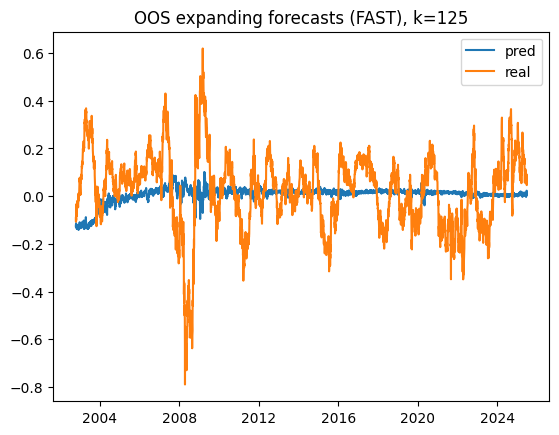

In [160]:
# Lead–Lag regression test: Copper/Oil -> ^HSI
# Assumes you already have:
#   df.index = DatetimeIndex (sorted, unique)
#   df.columns = ['copper', 'oil', '^HSI']
# and each column is a price series (close).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ----------------------------
# 0) Helpers
# ----------------------------
def _as_series(x):
    return x if isinstance(x, pd.Series) else pd.Series(x)

def logret(price: pd.Series) -> pd.Series:
    price = _as_series(price).astype(float)
    return np.log(price).diff()

def fwd_logret(price: pd.Series, k: int) -> pd.Series:
    """Forward k-day log return: ln(P_{t+k}) - ln(P_t)"""
    price = _as_series(price).astype(float)
    return np.log(price).shift(-k) - np.log(price)

def trailing_logret(price: pd.Series, w: int) -> pd.Series:
    """Trailing w-day log return: ln(P_t) - ln(P_{t-w})"""
    price = _as_series(price).astype(float)
    return np.log(price) - np.log(price).shift(w)

def rolling_zscore(x: pd.Series, w: int = 252) -> pd.Series:
    x = _as_series(x).astype(float)
    mu = x.rolling(w).mean()
    sd = x.rolling(w).std()
    return (x - mu) / sd

def clip_series(x: pd.Series, lo: float, hi: float) -> pd.Series:
    return x.clip(lower=lo, upper=hi)


# ----------------------------
# 1) Feature construction
# ----------------------------
def prepare_features(df: pd.DataFrame, z_window: int = 252) -> pd.DataFrame:
    df = df.copy().sort_index()

    # Basic sanity: drop impossible / non-positive prices
    for c in ["copper", "oil", "^HSI"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df.loc[df[c] <= 0, c] = np.nan

    df["co_ratio"] = df["copper"] / df["oil"]

    # Fast predictor: daily change in log(C/O)
    df["x_fast"] = logret(df["co_ratio"])

    # Slow predictor: z-score of log(C/O) level
    df["x_slow"] = rolling_zscore(np.log(df["co_ratio"]), w=z_window)

    # Optional control: trailing 20d log return of ^HSI
    df["mom20_hsi"] = trailing_logret(df["^HSI"], 20)

    return df


# ----------------------------
# 2) Lead–Lag regression (HAC)
# ----------------------------
def lead_lag_regression(
    df: pd.DataFrame,
    x_col: str,
    y_price_col: str = "^HSI",
    ks=(5, 10, 20, 60, 120, 180),
    add_controls: bool = True,
):
    rows = []
    for k in ks:
        y = fwd_logret(df[y_price_col], k)

        X = pd.DataFrame({x_col: df[x_col]})
        if add_controls:
            X["mom20"] = df.get("mom20_hsi", trailing_logret(df[y_price_col], 20))

        X = sm.add_constant(X)
        data = pd.concat([y.rename("y"), X], axis=1).dropna()

        if len(data) < 50:
            rows.append(
                {"k": k, "beta": np.nan, "se": np.nan, "tstat": np.nan, "pval": np.nan, "r2": np.nan, "n": len(data)}
            )
            continue

        y2 = data["y"]
        X2 = data.drop(columns=["y"])

        # Overlapping forward returns => use HAC SE; typical maxlags ~ k-1
        maxlags = max(k - 1, 1)
        model = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

        beta = model.params.get(x_col, np.nan)
        se = model.bse.get(x_col, np.nan)
        tstat = model.tvalues.get(x_col, np.nan)
        pval = model.pvalues.get(x_col, np.nan)

        rows.append(
            {
                "k": k,
                "beta": float(beta),
                "se": float(se),
                "tstat": float(tstat),
                "pval": float(pval),
                "r2": float(model.rsquared),
                "n": int(model.nobs),
            }
        )

    out = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    out["ci_lo"] = out["beta"] - 1.96 * out["se"]
    out["ci_hi"] = out["beta"] + 1.96 * out["se"]
    return out


def plot_beta_curve(res: pd.DataFrame, title: str):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(res["k"], res["beta"], marker="o")
    ax.fill_between(res["k"], res["ci_lo"], res["ci_hi"], alpha=0.2)
    ax.axhline(0.0, linewidth=1)
    ax.set_xlabel("Horizon k (trading days)")
    ax.set_ylabel("Beta (HAC)")
    ax.set_title(title)
    plt.show()


# ----------------------------
# 3) Placebo / reverse direction test
# ----------------------------
def reverse_direction_test(
    df: pd.DataFrame,
    x_col_for_reverse: str = "hsi_fast",
    y_price_col_for_reverse: str = "co_ratio",
    ks=(5, 10, 20, 60, 120, 180),
):
    """
    Test whether ^HSI predicts future Copper/Oil ratio moves (placebo).
    We'll define X as daily log-return of ^HSI, and Y as forward log-return of C/O ratio.
    """
    d = df.copy()
    d[x_col_for_reverse] = logret(d["^HSI"])
    return lead_lag_regression(d, x_col=x_col_for_reverse, y_price_col=y_price_col_for_reverse, ks=ks, add_controls=False)


# ----------------------------
# 4) Rolling regression stability for a chosen horizon k
# ----------------------------
def rolling_beta(
    df: pd.DataFrame,
    x_col: str,
    y_price_col: str = "^HSI",
    k: int = 60,
    window: int = 252,
    add_controls: bool = True,
):
    """
    Rolling OLS with HAC within each window is expensive.
    We do rolling OLS with Newey-West per window (HAC) for correctness.
    If too slow, set add_controls=False and/or increase step.
    """
    betas = []
    dates = []
    idx = df.index

    for end in range(window, len(df) - k):
        sub = df.iloc[end - window : end].copy()
        y = fwd_logret(sub[y_price_col], k)
        X = pd.DataFrame({x_col: sub[x_col]})
        if add_controls:
            X["mom20"] = sub.get("mom20_hsi", trailing_logret(sub[y_price_col], 20))
        X = sm.add_constant(X)

        data = pd.concat([y.rename("y"), X], axis=1).dropna()
        if len(data) < 50:
            betas.append(np.nan)
            dates.append(idx[end])
            continue

        y2 = data["y"]
        X2 = data.drop(columns=["y"])
        model = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": max(k - 1, 1)})

        betas.append(model.params.get(x_col, np.nan))
        dates.append(idx[end])

    s = pd.Series(betas, index=pd.Index(dates, name="date"), name=f"beta_{x_col}_k{k}")
    return s


def plot_series(s: pd.Series, title: str, ylabel: str):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(s.index, s.values)
    ax.axhline(0.0, linewidth=1)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    plt.show()


# ----------------------------
# 5) Weekly frequency rerun
# ----------------------------
def to_weekly_close(df: pd.DataFrame, weekday: str = "FRI") -> pd.DataFrame:
    """
    Convert daily -> weekly close.
    weekday can be 'FRI' etc. We'll use resample('W-FRI') by default.
    """
    rule = "W-" + weekday.upper()
    w = df.resample(rule).last()
    return w


# ----------------------------
# 6) Simple OOS predictive utility (expanding window): IC + OOS R^2-like
# ----------------------------
def oos_expanding_forecast(
    df: pd.DataFrame,
    x_col: str,
    y_price_col: str = "^HSI",
    k: int = 60,
    min_train: int = 504,  # ~2y
    add_controls: bool = True,
):
    """
    Expanding-window:
      fit on [0..t], predict forward return for t -> t+k using X_t (and control at t).
    Evaluate:
      IC = corr(pred, realized)
      "OOS R2" = 1 - MSE_model / MSE_baseline (baseline: mean of train y)
    """
    d = df.copy()
    y_all = fwd_logret(d[y_price_col], k)

    preds = []
    reals = []
    dates = []

    for t in range(min_train, len(d) - k):
        train = d.iloc[:t].copy()
        y_train = fwd_logret(train[y_price_col], k)

        X_train = pd.DataFrame({x_col: train[x_col]})
        if add_controls:
            X_train["mom20"] = train.get("mom20_hsi", trailing_logret(train[y_price_col], 20))
        X_train = sm.add_constant(X_train)

        data_tr = pd.concat([y_train.rename("y"), X_train], axis=1).dropna()
        if len(data_tr) < 100:
            continue

        y_tr = data_tr["y"]
        X_tr = data_tr.drop(columns=["y"])

        # Use HAC for training fit; prediction is point estimate
        model = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": max(k - 1, 1)})

        # Build X at time t (the "current" observation)
        X_t = pd.DataFrame({x_col: [d.iloc[t][x_col]]})
        if add_controls:
            X_t["mom20"] = d.iloc[t].get("mom20_hsi", np.nan)
        X_t = sm.add_constant(X_t, has_constant="add")

        pred = float(model.predict(X_t)[0])
        real = float(y_all.iloc[t])

        if np.isfinite(pred) and np.isfinite(real):
            preds.append(pred)
            reals.append(real)
            dates.append(d.index[t])

    pred_s = pd.Series(preds, index=pd.Index(dates, name="date"), name="pred")
    real_s = pd.Series(reals, index=pd.Index(dates, name="date"), name="real")

    # IC
    ic = pred_s.corr(real_s)

    # OOS R2-like vs baseline mean
    mse_model = np.mean((real_s - pred_s) ** 2)
    baseline = real_s.mean()
    mse_base = np.mean((real_s - baseline) ** 2)
    oos_r2 = 1.0 - (mse_model / mse_base) if mse_base > 0 else np.nan

    stats = {"k": k, "ic": ic, "oos_r2": oos_r2, "n_oos": len(real_s)}
    return stats, pd.concat([pred_s, real_s], axis=1)


# ----------------------------
# 7) Run everything end-to-end
# ----------------------------
# --- Prepare
df2 = prepare_features(df, z_window=252)

ks = (5, 10, 20, 60, 120, 150, 180)

# --- Main lead-lag: fast vs slow
res_fast = lead_lag_regression(df2, x_col="x_fast", y_price_col="^HSI", ks=ks, add_controls=True)
res_slow = lead_lag_regression(df2, x_col="x_slow", y_price_col="^HSI", ks=ks, add_controls=True)

print("=== Lead–Lag results (FAST: dlog(C/O)) ===")
print(res_fast)

print("\n=== Lead–Lag results (SLOW: zscore(log(C/O))) ===")
print(res_slow)

plot_beta_curve(res_fast, "Lead–Lag: beta(k) of ^HSI fwd return on dlog(C/O) (HAC)")
plot_beta_curve(res_slow, "Lead–Lag: beta(k) of ^HSI fwd return on zscore(log(C/O)) (HAC)")

# --- Placebo: reverse direction test (^HSI -> C/O)
res_rev = reverse_direction_test(df2, x_col_for_reverse="hsi_fast", y_price_col_for_reverse="co_ratio", ks=ks)
print("\n=== Placebo / Reverse direction (^HSI -> C/O ratio) ===")
print(res_rev)
plot_beta_curve(res_rev, "Reverse direction: beta(k) of C/O fwd return on dlog(^HSI) (HAC)")

# --- Rolling stability for the most promising horizon (choose based on res_fast/res_slow)
k_star = 125  # change to 120 if that's where you see stable significance
roll_b_fast = rolling_beta(df2, x_col="x_fast", y_price_col="^HSI", k=k_star, window=252, add_controls=True)
roll_b_slow = rolling_beta(df2, x_col="x_slow", y_price_col="^HSI", k=k_star, window=252, add_controls=True)

plot_series(roll_b_fast, f"Rolling beta stability (x_fast, k={k_star}, 252d window)", "beta")
plot_series(roll_b_slow, f"Rolling beta stability (x_slow, k={k_star}, 252d window)", "beta")

# --- Weekly robustness
dfw = to_weekly_close(df2, weekday="FRI")
dfw = prepare_features(dfw, z_window=104)  # ~2 years weekly ~104

# Interpret k in weeks now: e.g., 1,2,4,8,12,24 weeks
ks_w = (1, 2, 4, 8, 12, 24, 30)
res_fast_w = lead_lag_regression(dfw, x_col="x_fast", y_price_col="^HSI", ks=ks_w, add_controls=True)
res_slow_w = lead_lag_regression(dfw, x_col="x_slow", y_price_col="^HSI", ks=ks_w, add_controls=True)

print("\n=== Weekly Lead–Lag (FAST) ===")
print(res_fast_w)
print("\n=== Weekly Lead–Lag (SLOW) ===")
print(res_slow_w)

plot_beta_curve(res_fast_w, "Weekly Lead–Lag: beta(k weeks) on dlog(C/O) (HAC)")
plot_beta_curve(res_slow_w, "Weekly Lead–Lag: beta(k weeks) on zscore(log(C/O)) (HAC)")

# --- OOS utility (expanding) for your chosen k
oos_stats_fast, oos_df_fast = oos_expanding_forecast(df2, x_col="x_fast", y_price_col="^HSI", k=k_star, min_train=504, add_controls=True)
oos_stats_slow, oos_df_slow = oos_expanding_forecast(df2, x_col="x_slow", y_price_col="^HSI", k=k_star, min_train=504, add_controls=True)

print("\n=== OOS Expanding (FAST) ===", oos_stats_fast)
print("=== OOS Expanding (SLOW) ===", oos_stats_slow)

# Optional: plot pred vs real (for intuition)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(oos_df_fast.index, oos_df_fast["pred"], label="pred")
ax.plot(oos_df_fast.index, oos_df_fast["real"], label="real")
ax.set_title(f"OOS expanding forecasts (FAST), k={k_star}")
ax.legend()
plt.show()


## Refactored Code

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Copper/Oil Regime Backtest Suite (Multi-Market)
# - Single binary regime from Copper/Oil
# - Test any market price series (US, China, HK, etc.)
# - Supports: long-only, long/short, hysteresis, vol-targeting
# ============================================================

# ----------------------------
# Helpers
# ----------------------------
def rolling_zscore(x: pd.Series, w: int) -> pd.Series:
    mu = x.rolling(w, min_periods=w).mean()
    sd = x.rolling(w, min_periods=w).std()
    return (x - mu) / sd

def perf_stats(ret: pd.Series, ann_factor: int = 252) -> dict:
    ret = ret.dropna()
    if len(ret) == 0:
        return {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_dd": np.nan, "n": 0}
    ann_ret = ret.mean() * ann_factor
    ann_vol = ret.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    eq = (1 + ret).cumprod()
    max_dd = (eq / eq.cummax() - 1).min()
    return {"ann_ret": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe), "max_dd": float(max_dd), "n": int(len(ret))}

def _ensure_price_series(s: pd.Series, name: str) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.where(s > 0)  # prices must be positive for log ops
    s.name = name
    return s

# ============================================================
# Rolling Sharpe (multi-market compatible)
# - Computes rolling Sharpe for strategy and buy&hold
# - Plots one chart per market (no subplots, per your preference)
# ============================================================

def rolling_sharpe(ret: pd.Series, window: int = 252, ann_factor: int = 252) -> pd.Series:
    """
    Rolling Sharpe = (mean * ann_factor) / (std * sqrt(ann_factor))
    Uses simple returns. Returns a Series aligned to the original index.
    """
    ret = pd.to_numeric(ret, errors="coerce")
    mu = ret.rolling(window, min_periods=window).mean() * ann_factor
    sd = ret.rolling(window, min_periods=window).std() * np.sqrt(ann_factor)
    return (mu / sd).replace([np.inf, -np.inf], np.nan)

def plot_rolling_sharpe(
    df_bt: pd.DataFrame,
    market_name: str,
    window: int = 252,
    ann_factor: int = 252,
    show_buy_hold: bool = True,
):
    """
    df_bt must contain:
      - 'strategy_ret' : strategy simple returns
      - 'mkt_ret'      : market simple returns
    """
    rs_strat = rolling_sharpe(df_bt["strategy_ret"], window=window, ann_factor=ann_factor)
    rs_bh = rolling_sharpe(df_bt["mkt_ret"], window=window, ann_factor=ann_factor)

    plt.figure(figsize=(10, 4))
    plt.plot(rs_strat.index, rs_strat.values, label=f"Strategy rolling Sharpe ({window}d)")
    if show_buy_hold:
        plt.plot(rs_bh.index, rs_bh.values, label=f"Buy&Hold rolling Sharpe ({window}d)", alpha=0.7)
    plt.axhline(0.0, linewidth=1)
    plt.title(f"{market_name} — Rolling Sharpe")
    plt.ylabel("Sharpe (annualized)")
    plt.legend()
    plt.show()

def build_co_regime(
    copper: pd.Series,
    oil: pd.Series,
    z_window: int = 252,
    upper: float | None = None,
    lower: float | None = None,
) -> pd.DataFrame:
    """
    Build Copper/Oil regime:
      - If upper/lower not provided => simple threshold at 0: regime=1[z>0]
      - If upper/lower provided => hysteresis regime
    Returns DataFrame with columns: co_ratio, log_co, z_co, regime
    """
    copper = _ensure_price_series(copper, "copper")
    oil = _ensure_price_series(oil, "oil")

    df = pd.concat([copper, oil], axis=1).dropna().copy()
    df["co_ratio"] = df["copper"] / df["oil"]
    df["log_co"] = np.log(df["co_ratio"])
    df["z_co"] = rolling_zscore(df["log_co"], z_window)

    if upper is None or lower is None:
        df["regime"] = (df["z_co"] > 0).astype(int)
    else:
        # Hysteresis: switch ON only above upper, switch OFF only below lower
        state = []
        cur = 0
        for z in df["z_co"].values:
            if np.isnan(z):
                state.append(cur)
                continue
            if cur == 0 and z > upper:
                cur = 1
            elif cur == 1 and z < lower:
                cur = 0
            state.append(cur)
        df["regime"] = pd.Series(state, index=df.index).astype(int)

    return df


# ----------------------------
# Core Backtest Function
# ----------------------------

from qresearch.backtest.metrics import drawdown_series_from_equity, yearly_returns

def plot_yearly_returns_bars(out_df: pd.DataFrame, title: str = "Yearly Returns: Strategy vs Benchmark", market_name: str = ''):
    # _require_cols(out_df, ["strategy_ret", "mkt_ret"])

    strat_y = yearly_returns(out_df["strategy_ret"])
    bh_y = yearly_returns(out_df["mkt_ret"])

    yr = pd.concat([strat_y.rename("Strategy"), bh_y.rename("Benchmark")], axis=1).dropna()
    if yr.empty:
        raise ValueError("No yearly returns available (check index is DatetimeIndex and returns are present).")

    # Side-by-side bars
    x = np.arange(len(yr.index))
    width = 0.42

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, yr["Strategy"].values, width=width, label="Strategy")
    plt.bar(x + width/2, yr["Benchmark"].values, width=width, label="Benchmark", alpha=0.8)
    plt.axhline(0.0, linewidth=1)
    plt.xticks(x, yr.index.astype(str), rotation=45)
    plt.title(title)
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./img/{market_name}_yearly_returns.png')
    plt.show()

def plot_drawdowns(out_df: pd.DataFrame, title: str = "Drawdown: Strategy vs Benchmark", market_name: str = ''):
    d = out_df[["eq_strategy", "eq_bh"]].dropna()

    dd_s = drawdown_series_from_equity(d["eq_strategy"])
    dd_b = drawdown_series_from_equity(d["eq_bh"])

    plt.figure(figsize=(10, 6))
    plt.plot(dd_s.index, dd_s.values, label="Strategy DD")
    plt.plot(dd_b.index, dd_b.values, label="Benchmark DD", alpha=0.8)
    plt.axhline(0.0, linewidth=1, color="grey", linestyle="--",alpha=0.5)
    plt.title(title)
    plt.ylabel("Drawdown")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./img/{market_name}_drawdown.png')
    plt.show()
    
# --- helper: yearly returns table (strategy vs benchmark) ---
def make_yearly_returns_table(strategy_ret: pd.Series, bench_ret: pd.Series) -> pd.DataFrame:
    ys = pd.DataFrame({
        "strategy": yearly_returns(strategy_ret),
        "benchmark": yearly_returns(bench_ret),
    })
    ys["excess"] = ys["strategy"] - ys["benchmark"]
    return ys.sort_index()

# --- helper: drawdown series from equity (you already have drawdown_series_from_equity) ---
def add_drawdowns(d: pd.DataFrame, eq_cols=("eq_strategy", "eq_bh")) -> pd.DataFrame:
    d = d.copy()
    d["dd_strategy"] = drawdown_series_from_equity(d[eq_cols[0]])
    d["dd_benchmark"] = drawdown_series_from_equity(d[eq_cols[1]])
    return d
    
def run_co_regime_backtest(
    market_price: pd.Series,
    copper: pd.Series,
    oil: pd.Series,
    *,
    market_name: str = "market",
    z_window: int = 252,
    hysteresis: bool = False,
    upper: float = 0.25,
    lower: float = -0.25,
    mode: str = "long_only",         # "long_only" or "long_short"
    vol_target: float | None = None, # e.g. 0.12 annual; None disables
    vol_lookback: int = 20,
    max_leverage: float = 2.0,
    ann_factor: int = 252,
    plot: bool = True,
    trend_filter: int | None = None,
) -> dict:
    """
    Backtest Copper/Oil regime strategy on a chosen market.

    Inputs
    - market_price: price series for the market you test (e.g., SPY, CSI300, HSI)
    - copper, oil: price series for copper and oil (same frequency, alignable)
    - mode:
        "long_only": position = 1 if regime ON else 0
        "long_short": position = 1 if regime ON else -1
    - vol_target: if set, scale position by (vol_target / realized_vol), capped by max_leverage
    - Fast risk overlays:
        (1) vol shock scaler: scales down exposure when short-term vol spikes vs long-term vol
        (2) tail kill-switch: forces exposure to 0 for a cooldown window after tail events

    Output dict contains:
      - stats table (strategy + buy&hold)
      - dataframe with positions, returns, equity
    """
    # ------------------------------------------------------------
    # 0) Input
    # ------------------------------------------------------------
    market_price = _ensure_price_series(market_price, market_name)

    # ------------------------------------------------------------
    # 1) Regime (Copper/Oil)
    # ------------------------------------------------------------
    if hysteresis:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=upper, lower=lower)
    else:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=None, lower=None)

    # Align
    d = pd.concat([market_price, reg[["regime", "z_co"]]], axis=1).dropna().copy()

    # ------------------------------------------------------------
    # 2) Returns
    # ------------------------------------------------------------
    d["mkt_ret"] = d[market_name].pct_change()

    # ------------------------------------------------------------
    # 3) Base position (regime -> exposure)
    # ------------------------------------------------------------
    if mode.lower() == "long_only":
        base_pos = d["regime"].astype(float)               # 1 or 0
    elif mode.lower() == "long_short":
        base_pos = (2 * d["regime"] - 1).astype(float)     # 1 or -1
    else:
        raise ValueError("mode must be 'long_only' or 'long_short'")

    # Original convention: trade on next bar (shift 1)
    d["position_raw"] = base_pos.shift(1).fillna(0.0)

    # ------------------------------------------------------------
    # 4) Vol targeting (optional)
    # ------------------------------------------------------------
    if vol_target is not None:
        rv = d["mkt_ret"].rolling(vol_lookback, min_periods=vol_lookback).std() * np.sqrt(ann_factor)
        d["vol_scale"] = (vol_target / rv).clip(lower=0.0, upper=max_leverage)
        d["position_raw"] *= d["vol_scale"].shift(1).fillna(0.0)

    # ------------------------------------------------------------
    # 5) Trend filter (optional)
    # ------------------------------------------------------------
    if trend_filter is not None:
        d["ma"] = d[market_name].rolling(trend_filter, min_periods=trend_filter).mean()
        ratio = (d[market_name] / d["ma"])
        p = 2.0
        d["trend_mult"] = ratio.clip(upper=1.0) ** p
        d["position_raw"] = (d["position_raw"] * d["trend_mult"].shift(1).fillna(1.0)).astype(float)

    # Final position used for PnL
    d["position"] = d["position_raw"]

    # ------------------------------------------------------------
    # 8) Strategy equity
    # ------------------------------------------------------------
    d["strategy_ret"] = d["position"] * d["mkt_ret"]
    d["eq_strategy"] = (1 + d["strategy_ret"]).cumprod()
    d["eq_bh"] = (1 + d["mkt_ret"]).cumprod()
    d["mkt_norm"] = d[market_name] / d[market_name].iloc[0]

    # Add drawdowns (both)
    d = add_drawdowns(d)

    # Yearly returns table (strategy vs benchmark)
    yearly_tbl = make_yearly_returns_table(d["strategy_ret"], d["mkt_ret"])

    # ------------------------------------------------------------
    # 9) Stats
    # ------------------------------------------------------------
    stats = {
        "market": market_name,
        "mode": mode,
        "hysteresis": hysteresis,
        "z_window": z_window,
        "vol_target": vol_target,
        # --- core perf ---
        "strategy": perf_stats(d["strategy_ret"], ann_factor=ann_factor),
        "buy_hold": perf_stats(d["mkt_ret"], ann_factor=ann_factor),
        "avg_exposure": float(d["position"].abs().mean()),
        "pct_in_market": float((d["position"] != 0).mean()),
        "regime_on_share": float(d["regime"].mean()),
        "yearly_returns": yearly_tbl,
        "max_dd_strategy": float(d["dd_strategy"].min()),
        "max_dd_benchmark": float(d["dd_benchmark"].min()),
    }

    # ------------------------------------------------------------
    # 10) Plots
    # ------------------------------------------------------------
    if plot:
        # Cumulative Curves
        title = (
            f"{market_name} | {mode} | hyst={hysteresis}"
        )
        plt.figure(figsize=(10, 5))
        plt.plot(d.index, d["eq_strategy"], label="Strategy")
        plt.plot(d.index, d["eq_bh"], label="Buy&Hold", alpha=0.7)
        plt.legend()
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f'./img/{market_name}_{mode}_equity_curve.png')
        plt.show()

        # Position
        plt.figure(figsize=(10, 2))
        plt.plot(d.index, d["position"], label="Position")
        plt.title(f"Position — {market_name}")
        plt.tight_layout()
        plt.show()

        out_df = d.copy()
        plot_yearly_returns_bars(
            out_df,
            title=f"{market_name} Yearly Returns — Strategy vs Benchmark",
            market_name=market_name,
        )
        plot_drawdowns(
            out_df,
            title=f"{market_name} Drawdown — Strategy vs Benchmark",
            market_name=market_name,
        )

    return {"stats": stats, "df": d}


def compute_hysteresis_regime(z: pd.Series, upper: float, lower: float) -> pd.Series:
    """
    Hysteresis regime:
    - Turn ON when z > upper
    - Turn OFF when z < lower
    - Otherwise keep previous state
    Returns int series {0,1}.
    """
    z = z.copy()
    regime = pd.Series(index=z.index, dtype="float64")

    state = 0
    for t, val in z.items():
        if np.isnan(val):
            regime.loc[t] = np.nan
            continue

        if state == 0 and val > upper:
            state = 1
        elif state == 1 and val < lower:
            state = 0
        regime.loc[t] = state

    return regime.astype("float64")


def plot_co_regime_shading(
    df: pd.DataFrame,
    market_col: str,
    *,
    copper_col: str = "copper",
    oil_col: str = "oil",
    z_window: int = 252,
    upper: float = 0.5,
    lower: float = -0.5,
    use_log_price: bool = False,
    title: str | None = None,
):
    """
    Plot 2: Copper/Oil z-score + regime shading + market price (or log price).
    Preconditions:
      - df index is datetime
      - df contains copper, oil, and market_col
    """
    d = df[[copper_col, oil_col, market_col]].dropna().sort_index().copy()

    # Copper/Oil ratio and z-score
    d["co_ratio"] = d[copper_col] / d[oil_col]
    d["co_log"] = np.log(d["co_ratio"])
    mu = d["co_log"].rolling(z_window, min_periods=z_window).mean()
    sd = d["co_log"].rolling(z_window, min_periods=z_window).std()
    d["co_z"] = (d["co_log"] - mu) / sd

    # Hysteresis regime on z-score
    d["regime"] = compute_hysteresis_regime(d["co_z"], upper=upper, lower=lower)
    d["regime"] = d["regime"].ffill().fillna(0).astype(int)

    # Market series to plot
    m = d[market_col]
    m_plot = np.log(m) if use_log_price else m

    # ---- Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Helper: shade ON regions
    def shade_on(ax, idx, reg):
        reg = reg.reindex(idx).fillna(0).astype(int)
        # shade where reg == 1
        in_on = False
        start = None
        for t, r in reg.items():
            if (not in_on) and r == 1:
                in_on = True
                start = t
            elif in_on and r == 0:
                ax.axvspan(start, t, alpha=0.12)
                in_on = False
        if in_on:
            ax.axvspan(start, idx[-1], alpha=0.12)

    # Top: z-score
    axes[0].plot(d.index, d["co_z"], linewidth=1.2)
    axes[0].axhline(upper, linestyle="--", linewidth=1.0)
    axes[0].axhline(lower, linestyle="--", linewidth=1.0)
    axes[0].axhline(0.0, linestyle=":", linewidth=1.0)
    shade_on(axes[0], d.index, d["regime"])
    axes[0].set_ylabel(f"zscore(log(C/O), {z_window}d)")
    axes[0].set_title(title or f"Copper/Oil Regime (upper={upper}, lower={lower}) + {market_col}")

    # Bottom: market price
    axes[1].plot(d.index, m_plot, linewidth=1.2)
    shade_on(axes[1], d.index, d["regime"])
    axes[1].set_ylabel("log(price)" if use_log_price else "price")
    axes[1].set_xlabel("Date")

    plt.tight_layout()
    # plt.savefig(f'./img/{market_col}_co_regime_shading.png')
    plt.show()

    return d  # returns the aligned data incl. co_z and regime for later use


# ----------------------------
# Batch runner for multiple markets
# ----------------------------
def run_multi_market_tests(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    z_window: int = 252,
    hysteresis: bool = False,
    upper: float = 0.25,
    lower: float = -0.25,
    modes: tuple = ("long_only", "long_short"),
    vol_target: float | None = None,
    trend_filter: int | None = None,
    plot: bool = False,
    return_details: bool = False,
) -> dict | pd.DataFrame:
    """
    markets: {"SPY": spy_price_series, "CSI300": csi300_price_series, ...}

    If return_details=True:
      returns {"summary": summary_df, "details": details_dict}
    else:
      returns summary_df
    """
    rows = []
    details = {}  # (market, mode) -> {"df":..., "yearly_returns":..., "stats":...}

    for name, price in markets.items():
        for mode in modes:
            res = run_co_regime_backtest(
                market_price=price,
                copper=copper,
                oil=oil,
                market_name=name,
                z_window=z_window,
                hysteresis=hysteresis,
                upper=upper,
                lower=lower,
                mode=mode,
                vol_target=vol_target,
                trend_filter=trend_filter,
                plot=plot,
            )
            s = res["stats"]

            rows.append({
                "market": s["market"],
                "mode": s["mode"],
                "hysteresis": s["hysteresis"],
                "z_window": s["z_window"],
                "vol_target": s["vol_target"],
                "ann_ret": s["strategy"]["ann_ret"],
                "ann_vol": s["strategy"]["ann_vol"],
                "sharpe": s["strategy"]["sharpe"],
                "max_dd": s["strategy"]["max_dd"],
                "bh_ann_ret": s["buy_hold"]["ann_ret"],
                "bh_sharpe": s["buy_hold"]["sharpe"],
                "max_dd_bh": s.get("max_dd_benchmark", np.nan),
                "avg_abs_exposure": s["avg_exposure"],
                "pct_in_market": s["pct_in_market"],
                "regime_on_share": s["regime_on_share"],
            })

            details[(name, mode)] = {
                "df": res["df"],                       # full daily dataframe incl. dd_strategy/dd_benchmark
                "yearly_returns": s["yearly_returns"], # per-year table
                "stats": s,                            # full dict
            }

    summary = (
        pd.DataFrame(rows)
          .sort_values(["market", "mode"])
          .reset_index(drop=True)
    )

    if return_details:
        return {"summary": summary, "details": details}
    
    return summary

def run_and_plot_rolling_sharpe(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    z_window: int = 252,
    hysteresis: bool = False,
    upper: float = 0.25,
    lower: float = -0.25,
    mode: str = "long_only",
    vol_target: float | None = None,
    window: int = 252,
):
    """
    markets: dict {name: price_series}
    Generates one rolling-Sharpe plot per market (no subplots).
    Requires run_co_regime_backtest defined earlier.
    """
    for name, price in markets.items():
        out = run_co_regime_backtest(
            market_price=price,
            copper=copper,
            oil=oil,
            market_name=name,
            z_window=z_window,
            hysteresis=hysteresis,
            upper=upper,
            lower=lower,
            mode=mode,
            vol_target=vol_target,
            plot=False,
        )
        plot_rolling_sharpe(out["df"], market_name=name, window=window)

In [50]:
start_date = '2000-01-01'
end_date = '2025-12-24'
df = yf.download(['HG=F', 'CL=F', '^HSI'], start=start_date, end=end_date)['Close'].dropna()
df.columns = ['oil', 'copper', '^HSI']
df = df / df.iloc[0]

hsi_ohlc = yf.download('^HSI', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close'].squeeze()
ss001 = yf.download('000001.SS', start=start_date, end=end_date)['Close'].squeeze()
csi300 = yf.download('3188.HK', start=start_date, end=end_date)['Close'].squeeze()
chiNext = yf.download('159915.SZ', start=start_date, end=end_date)['Close'].squeeze()
hsce = yf.download('^HSCE', start=start_date, end=end_date)['Close'].squeeze()
hsi = hsi_ohlc['Close'].squeeze()
n225 = yf.download('^N225', start=start_date, end=end_date)['Close'].squeeze()
stoxx600 = yf.download('^STOXX', start=start_date, end=end_date)['Close'].squeeze()

markets = {
    '^HSI': hsi,
    # '^HSCE': hsce,
    # 'CSI300': csi300,
    'SS001': ss001,
    # 'chiNext': chiNext,
    '^GSPC': sp500,
    '^N225': n225,
    '^STOXX': stoxx600,
}
# 
# # Run one market with plots:
# out = run_co_regime_backtest(
#     market_price=hsi,
#     copper=df["copper"],
#     oil=df["oil"],
#     market_name='^HSI',
#     mode="long_only",
#     hysteresis=True,
#     upper=0.25,
#     lower=-0.25,
#     # vol_target=0.12,  # try vol targeting to reduce LS volatility
#     # trend_filter=120,
#     plot=True,
# )
# 
# # For HSI
# plot_df = plot_co_regime_shading(
#     df,
#     market_col="^HSI",
#     z_window=252,
#     upper=0.25,
#     lower=-0.25,
#     use_log_price=False,
#     title="HSI with Copper/Oil Regime Shading",
# )
# 
# out["stats"]

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_41939/2365352889.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['HG=F', 'CL=F', '^HSI'], start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  3 of 3 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_41939/2365352889.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi_ohlc = yf.download('^HSI', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_41939/2365352889.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_41939/236535

In [60]:
# ============================================================
# 5% Trade-level Stop Loss (NEW)
# - Works for long-only and long/short
# - Default: trailing stop from peak/trough since entry
# - Behavior: if stopped out, stay flat until regime turns OFF (prevents churn)
# ============================================================

def apply_pct_stop_nextbar(
    position_raw: pd.Series,
    close: pd.Series,
    *,
    stop_pct: float = 0.05,
    stop_type: str = "trailing",          # "trailing" or "fixed"
    cooldown_days: int = 0,               # NEW: fixed cooldown (0 disables)
) -> pd.DataFrame:
    """
    Trade-level % stop evaluated on close[t], enforced on position[t+1].
    This avoids lookahead in a close-to-close backtest.

    cooldown_days:
      After a stop, stay flat for N days (starting next bar).
      This replaces the old block_until_regime_off behavior.
    """
    idx = close.index
    pos_out = pd.Series(0.0, index=idx)
    stop_level = pd.Series(np.nan, index=idx)
    stop_hit = pd.Series(False, index=idx)
    cooldown_left = pd.Series(0, index=idx, dtype=int)

    in_trade = False
    entry = np.nan
    peak = np.nan
    trough = np.nan
    direction = 0
    cd = 0  # remaining cooldown counter

    prev_pos = 0.0  # position actually held today (pos_out[t])

    for i, t in enumerate(idx):
        desired = float(position_raw.loc[t]) if pd.notna(position_raw.loc[t]) else 0.0
        dir_now = int(np.sign(desired))
        px = float(close.loc[t])

        # 1) Determine today's position (what we actually hold for today's close-to-close move)
        #    It is based on yesterday's decisions; here we implement it by using cd and state.
        if cd > 0:
            pos_today = 0.0
        else:
            pos_today = desired

        pos_out.loc[t] = pos_today
        cooldown_left.loc[t] = cd

        # 2) Update trade state using today's held position (pos_today)
        if np.sign(pos_today) == 0:
            # flat => reset trade tracking
            in_trade = False
            entry = np.nan
            peak = np.nan
            trough = np.nan
            direction = 0
            stop_level.loc[t] = np.nan
            prev_pos = pos_today
            # reduce cooldown at end of day
            cd = max(cd - 1, 0)
            continue

        # entering / switching direction
        dir_pos = int(np.sign(pos_today))
        if (not in_trade) or (direction != dir_pos):
            in_trade = True
            direction = dir_pos
            entry = px
            peak = px
            trough = px

        # update extremes
        peak = max(peak, px)
        trough = min(trough, px)

        # compute stop level (evaluated at close[t])
        if stop_type == "fixed":
            lvl = entry * (1.0 - stop_pct) if direction == +1 else entry * (1.0 + stop_pct)
        elif stop_type == "trailing":
            lvl = peak * (1.0 - stop_pct) if direction == +1 else trough * (1.0 + stop_pct)
        else:
            raise ValueError("stop_type must be 'fixed' or 'trailing'")

        stop_level.loc[t] = lvl

        # 3) If stop is hit at close[t], it affects NEXT bar
        hit = (direction == +1 and px <= lvl) or (direction == -1 and px >= lvl)
        stop_hit.loc[t] = hit

        if hit:
            # start cooldown for next bar
            cd = max(cd, cooldown_days)

            # also reset trade tracking so re-entry is treated as a new trade
            in_trade = False
            entry = np.nan
            peak = np.nan
            trough = np.nan
            direction = 0

        # cooldown decays at end of bar
        cd = max(cd - 1, 0)
        prev_pos = pos_today

    return pd.DataFrame(
        {"position": pos_out, "stop_level": stop_level, "stop_hit": stop_hit, "cooldown_left": cooldown_left},
        index=idx,
    )

# ============================================================
# Copper/Oil Regime Backtest (with 5% trade-level stop)
# - Removed previous risk overlays (vol shock / kill switch / ATR stop)
# - Keeps your original structure and plots
# ============================================================

def run_co_regime_backtest(
    market_price: pd.Series,
    copper: pd.Series,
    oil: pd.Series,
    *,
    market_name: str = "market",
    z_window: int = 252,
    hysteresis: bool = False,
    upper: float = 0.25,
    lower: float = -0.25,
    mode: str = "long_only",         # "long_only" or "long_short"
    vol_target: float | None = None, # e.g. 0.12 annual; None disables
    vol_lookback: int = 20,
    max_leverage: float = 2.0,
    ann_factor: int = 252,
    plot: bool = True,
    trend_filter: int | None = None,
    # --- 5% trade-level stop-loss (NEW) ---
    use_pct_stop: bool = False,
    stop_pct: float = 0.05,
    stop_type: str = "trailing",     # "trailing" or "fixed"
    cooldown_days: int = 0,
) -> dict:
    """
    Backtest Copper/Oil regime strategy on a chosen market.

    Inputs
    - market_price: price series for the market you test (e.g., SPY, CSI300, HSI)
    - copper, oil: price series for copper and oil (same frequency, alignable)
    - mode:
        "long_only": position = 1 if regime ON else 0
        "long_short": position = 1 if regime ON else -1
    - vol_target: if set, scale position by (vol_target / realized_vol), capped by max_leverage
    - (NEW) use_pct_stop:
        If True, apply trade-level percent stop-loss (default 5%) on the scaled position.

    Output dict contains:
      - stats table (strategy + buy&hold)
      - dataframe with positions, returns, equity
    """
    market_price = _ensure_price_series(market_price, market_name)

    # ------------------------------------------------------------
    # Regime
    # ------------------------------------------------------------
    if hysteresis:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=upper, lower=lower)
    else:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=None, lower=None)

    # Align
    d = pd.concat([market_price, reg[["regime", "z_co"]]], axis=1).dropna().copy()

    # ------------------------------------------------------------
    # Returns
    # ------------------------------------------------------------
    d["mkt_ret"] = d[market_name].pct_change()

    # ------------------------------------------------------------
    # Base position
    # ------------------------------------------------------------
    if mode.lower() == "long_only":
        base_pos = d["regime"].astype(float)               # 1 or 0
    elif mode.lower() == "long_short":
        base_pos = (2 * d["regime"] - 1).astype(float)     # 1 or -1
    else:
        raise ValueError("mode must be 'long_only' or 'long_short'")

    # Original convention: trade on next bar (shift 1)
    d["position_raw"] = base_pos.shift(1).fillna(0.0)

    # ------------------------------------------------------------
    # Vol targeting (optional)
    # ------------------------------------------------------------
    if vol_target is not None:
        rv = d["mkt_ret"].rolling(vol_lookback, min_periods=vol_lookback).std() * np.sqrt(ann_factor)
        d["vol_scale"] = (vol_target / rv).clip(lower=0.0, upper=max_leverage)
        d["position_raw"] *= d["vol_scale"].shift(1).fillna(0.0)

    # ------------------------------------------------------------
    # Trend filter (optional)
    # ------------------------------------------------------------
    if trend_filter is not None:
        d["ma"] = d[market_name].rolling(trend_filter, min_periods=trend_filter).mean()
        ratio = (d[market_name] / d["ma"])
        p = 2.0
        d["trend_mult"] = ratio.clip(upper=1.0) ** p
        d["position_raw"] = (d["position_raw"] * d["trend_mult"].shift(1).fillna(1.0)).astype(float)

    # ------------------------------------------------------------
    # 5% trade-level stop-loss (NEW)
    # - Applied after position sizing, acts as a final gate
    # - Uses Close-only logic (no need for OHLC)
    # ------------------------------------------------------------        
    if use_pct_stop:
        stop_df = apply_pct_stop_nextbar(
            position_raw=d["position_raw"],
            close=d[market_name],
            stop_pct=stop_pct,
            stop_type=stop_type,
            cooldown_days=cooldown_days,  
        )
        d["position"] = stop_df["position"]
        d["stop_level"] = stop_df["stop_level"]
        d["stop_hit"] = stop_df["stop_hit"]
        d["cooldown_left"] = stop_df["cooldown_left"]
    else:
        d["position"] = d["position_raw"]


    # ------------------------------------------------------------
    # Strategy equity
    # ------------------------------------------------------------
    d["strategy_ret"] = d["position"] * d["mkt_ret"]
    d["eq_strategy"] = (1 + d["strategy_ret"]).cumprod()
    d["eq_bh"] = (1 + d["mkt_ret"]).cumprod()
    d["mkt_norm"] = d[market_name] / d[market_name].iloc[0]

    # Add drawdowns (both)
    d = add_drawdowns(d)

    # Yearly returns table (strategy vs benchmark)
    yearly_tbl = make_yearly_returns_table(d["strategy_ret"], d["mkt_ret"])

    # ------------------------------------------------------------
    # Stats
    # ------------------------------------------------------------
    stats = {
        "market": market_name,
        "mode": mode,
        "hysteresis": hysteresis,
        "z_window": z_window,
        "vol_target": vol_target,

        # stop diagnostics (NEW)
        "use_pct_stop": use_pct_stop,
        "stop_pct": stop_pct,
        "stop_type": stop_type,
        "n_stop_hits": int(d["stop_hit"].sum()) if "stop_hit" in d.columns else 0,
        "pct_blocked": float(d["blocked"].mean()) if "blocked" in d.columns else 0.0,

        "strategy": perf_stats(d["strategy_ret"], ann_factor=ann_factor),
        "buy_hold": perf_stats(d["mkt_ret"], ann_factor=ann_factor),
        "avg_exposure": float(d["position"].abs().mean()),
        "pct_in_market": float((d["position"] != 0).mean()),
        "regime_on_share": float(d["regime"].mean()),
        "yearly_returns": yearly_tbl,
        "max_dd_strategy": float(d["dd_strategy"].min()),
        "max_dd_benchmark": float(d["dd_benchmark"].min()),
    }

    # ------------------------------------------------------------
    # Plots
    # ------------------------------------------------------------
    if plot:
        # Cumulative Curves
        title = f"{market_name} | {mode} | hyst={hysteresis} | vol_target={vol_target} | stop={use_pct_stop}({stop_pct:.0%},{stop_type})"
        plt.figure(figsize=(10, 5))
        plt.plot(d.index, d["eq_strategy"], label="Strategy")
        plt.plot(d.index, d["eq_bh"], label="Buy&Hold", alpha=0.7)
        plt.legend()
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f'./img/{market_name}_{mode}_equity_curve.png')
        plt.show()

        # Position
        plt.figure(figsize=(10, 2))
        plt.plot(d.index, d["position"], label="Position")
        plt.title(f"Position — {market_name}")
        plt.tight_layout()
        plt.show()

        # (Optional) Stop level plot + stop hits
        if use_pct_stop and "stop_level" in d.columns:
            plt.figure(figsize=(10, 4))
            plt.plot(d.index, d[market_name], label="Price", linewidth=1.2)
            plt.plot(d.index, d["stop_level"], label=f"Stop level ({stop_pct:.0%}, {stop_type})", alpha=0.8)
            hits = d.index[d["stop_hit"].fillna(False)]
            if len(hits) > 0:
                plt.scatter(hits, d.loc[hits, market_name], s=20, label="Stop Hit")
            plt.title(f"{market_name} — Price & Stop Level")
            plt.legend()
            plt.tight_layout()
            plt.show()

        out_df = d.copy()

        # Yearly Returns
        plot_yearly_returns_bars(
            out_df,
            title=f"{market_name} Yearly Returns — Strategy vs Benchmark",
            market_name=market_name,
        )

        # Drawdown
        plot_drawdowns(
            out_df,
            title=f"{market_name} Drawdown — Strategy vs Benchmark",
            market_name=market_name,
        )

    return {"stats": stats, "df": d}

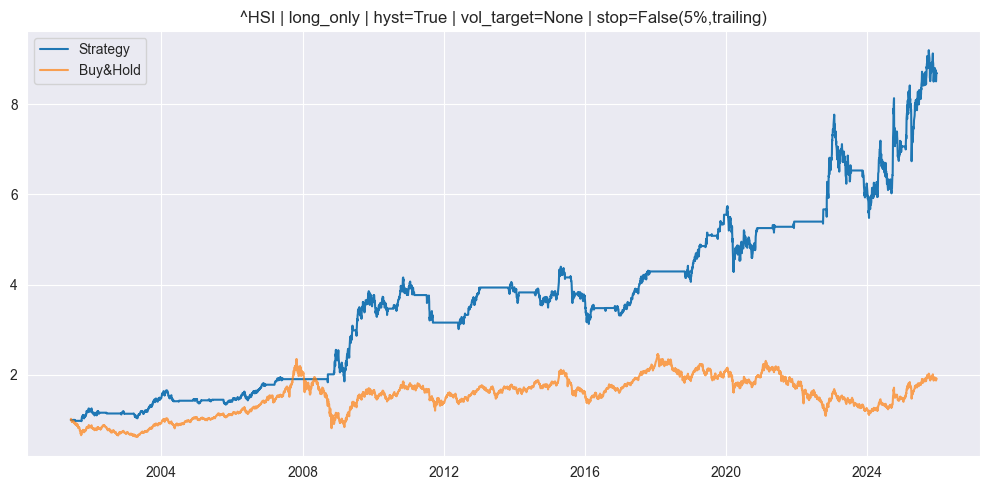

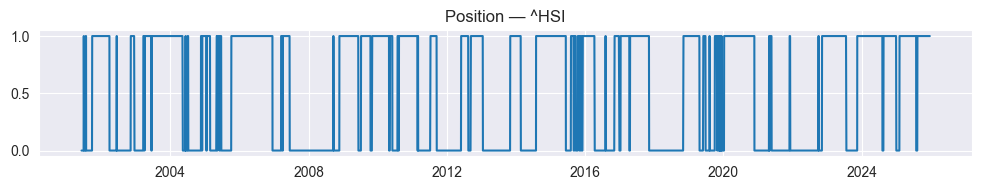

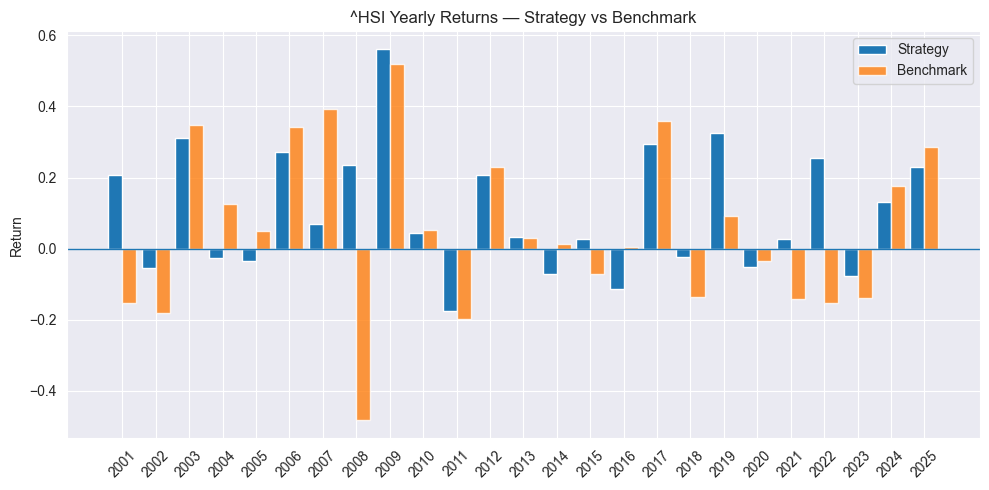

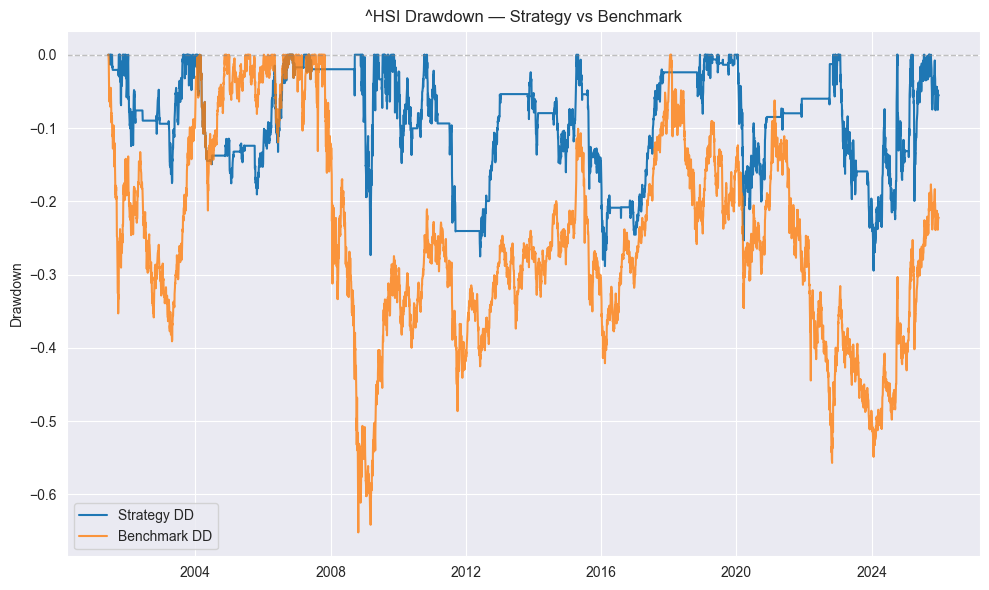

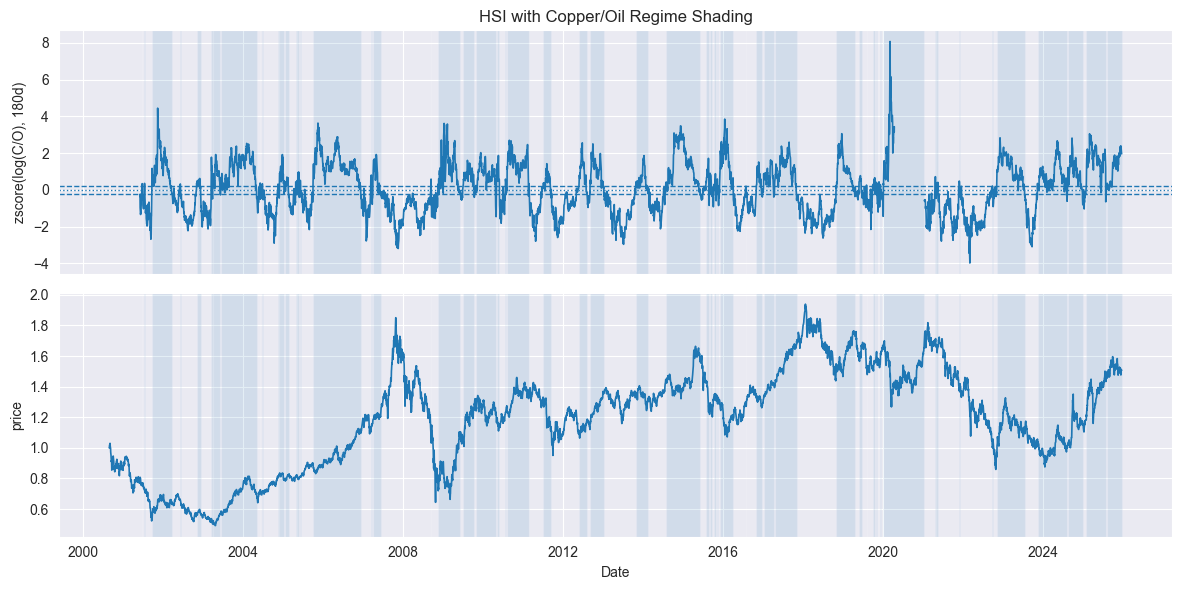

{'market': '^HSI',
 'mode': 'long_only',
 'hysteresis': True,
 'z_window': 180,
 'vol_target': None,
 'use_pct_stop': False,
 'stop_pct': 0.05,
 'stop_type': 'trailing',
 'n_stop_hits': 0,
 'pct_blocked': 0.0,
 'strategy': {'ann_ret': 0.10553305541485486,
  'ann_vol': 0.1605611583159039,
  'sharpe': 0.6572763707098992,
  'max_dd': -0.2946530093066534,
  'n': 5882},
 'buy_hold': {'ann_ret': 0.05560863380192757,
  'ann_vol': 0.23547593797241156,
  'sharpe': 0.23615420870918324,
  'max_dd': -0.6518186042408538,
  'n': 5882},
 'avg_exposure': 0.537140914499405,
 'pct_in_market': 0.537140914499405,
 'regime_on_share': 0.5373108958014619,
 'yearly_returns':       strategy  benchmark    excess
 Date                               
 2001  0.205670  -0.152742  0.358411
 2002 -0.054817  -0.182143  0.127326
 2003  0.311811   0.349163 -0.037352
 2004 -0.026394   0.126242 -0.152636
 2005 -0.036516   0.050332 -0.086848
 2006  0.271770   0.342037 -0.070267
 2007  0.068788   0.393090 -0.324301
 2008  0

In [76]:
# Run one market with plots:
bound = 0.20

out = run_co_regime_backtest(
    market_price=hsi,
    copper=df["copper"],
    oil=df["oil"],
    market_name='^HSI',
    mode="long_only",
    hysteresis=True,
    z_window=180,
    upper=bound,
    lower=-bound,
    # vol_target=0.12,  # try vol targeting to reduce LS volatility
    # trend_filter=120,
    plot=True,
)

# For HSI
plot_df = plot_co_regime_shading(
    df,
    market_col="^HSI",
    z_window=180,
    upper=bound,
    lower=-bound,
    use_log_price=False,
    title="HSI with Copper/Oil Regime Shading",
)

out["stats"]

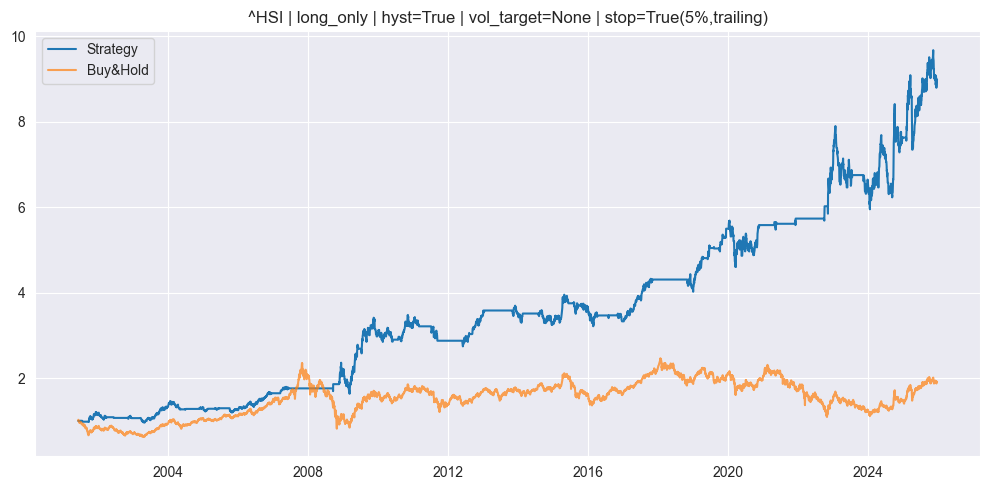

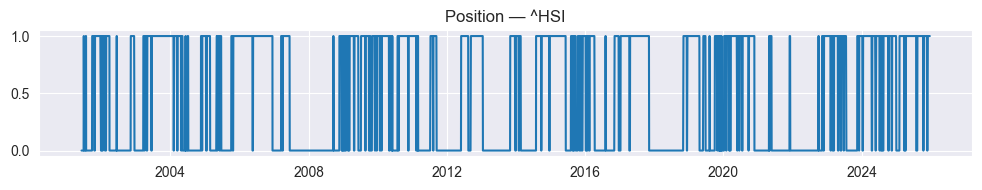

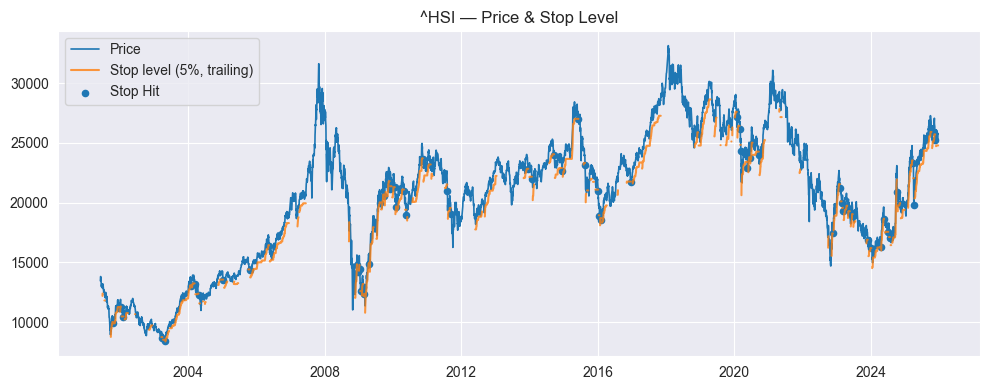

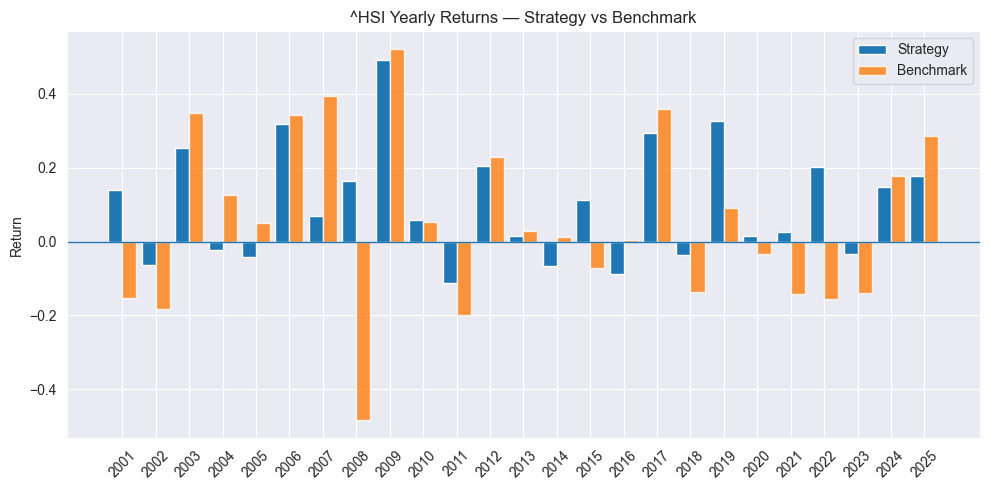

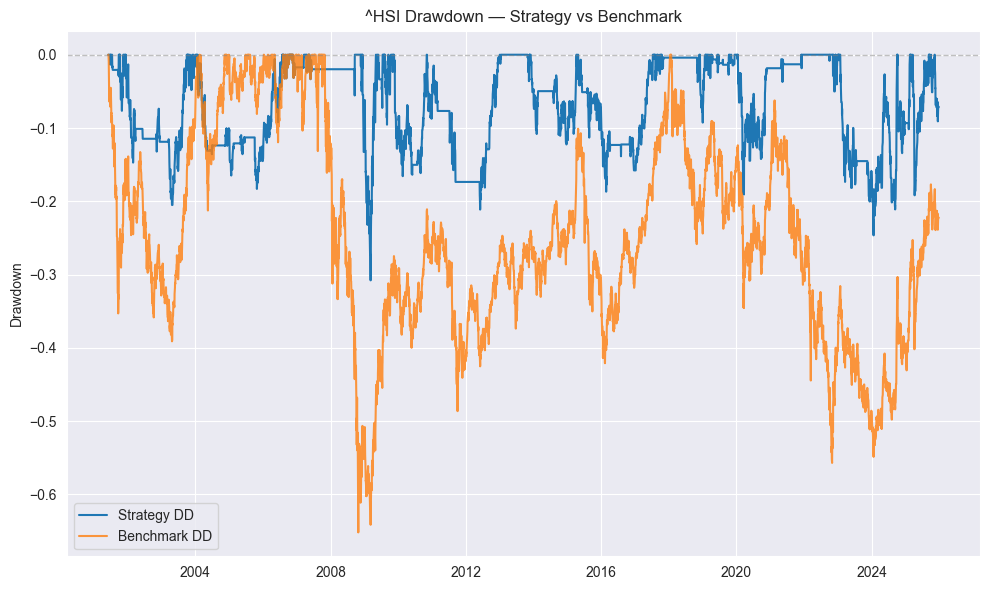

{'market': '^HSI',
 'mode': 'long_only',
 'hysteresis': True,
 'z_window': 180,
 'vol_target': None,
 'use_pct_stop': True,
 'stop_pct': 0.05,
 'stop_type': 'trailing',
 'n_stop_hits': 68,
 'pct_blocked': 0.0,
 'strategy': {'ann_ret': 0.10545932262408378,
  'ann_vol': 0.15097958117579896,
  'sharpe': 0.6985005641344846,
  'max_dd': -0.30788612798782977,
  'n': 5882},
 'buy_hold': {'ann_ret': 0.05560863380192757,
  'ann_vol': 0.23547593797241156,
  'sharpe': 0.23615420870918324,
  'max_dd': -0.6518186042408538,
  'n': 5882},
 'avg_exposure': 0.4929457759646439,
 'pct_in_market': 0.4929457759646439,
 'regime_on_share': 0.5373108958014619,
 'yearly_returns':       strategy  benchmark    excess
 Date                               
 2001  0.138563  -0.152742  0.291305
 2002 -0.064403  -0.182143  0.117740
 2003  0.253670   0.349163 -0.095493
 2004 -0.022551   0.126242 -0.148793
 2005 -0.042960   0.050332 -0.093292
 2006  0.319050   0.342037 -0.022987
 2007  0.068788   0.393090 -0.324301
 200

In [83]:
out_rm = run_co_regime_backtest(
    market_price=hsi,     # OHLC ok even if you are not using ATR now
    copper=df["copper"],
    oil=df["oil"],
    market_name="^HSI",
    hysteresis=True,
    z_window=180,
    upper=bound,
    lower=-bound,
    use_pct_stop=True,
    stop_pct=0.05,
    cooldown_days=5,
    plot=True,
)

out_rm['stats']

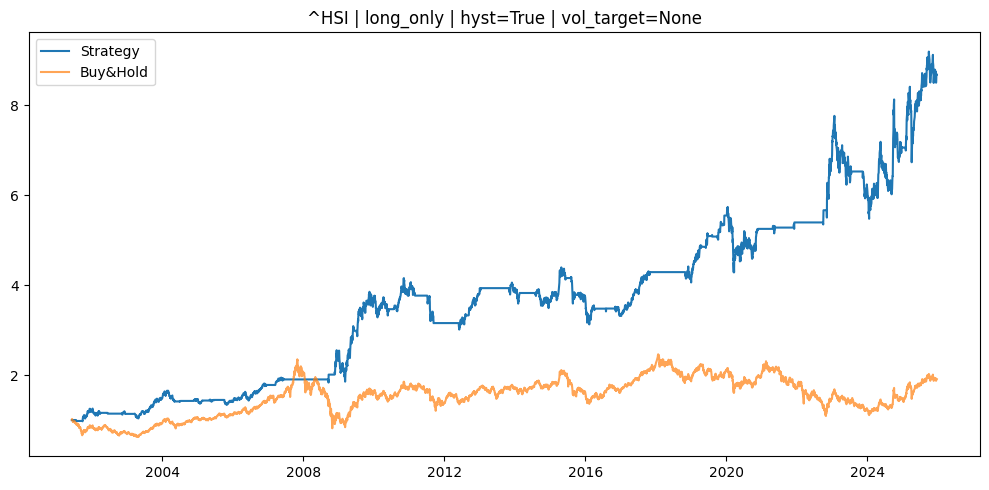

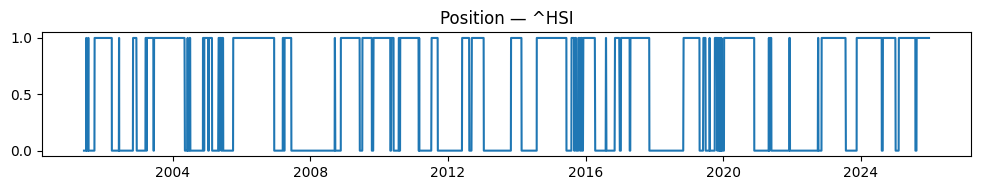

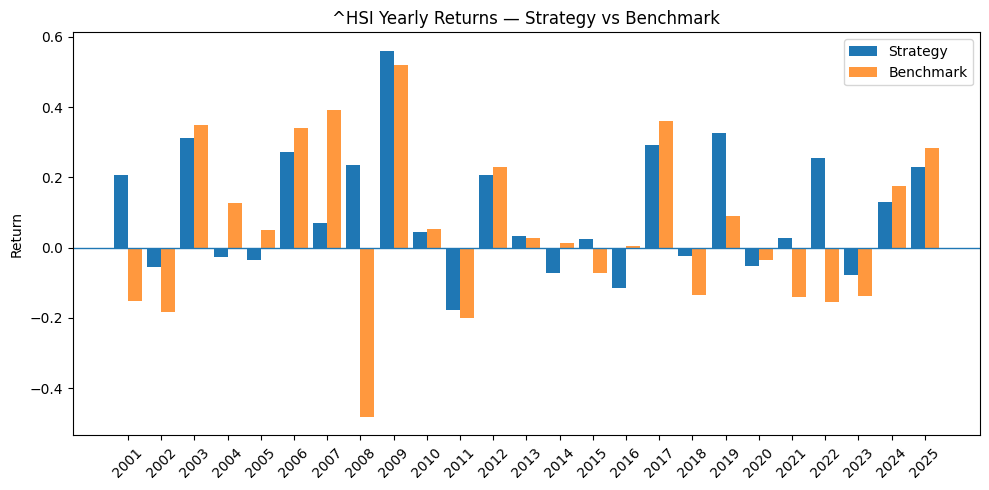

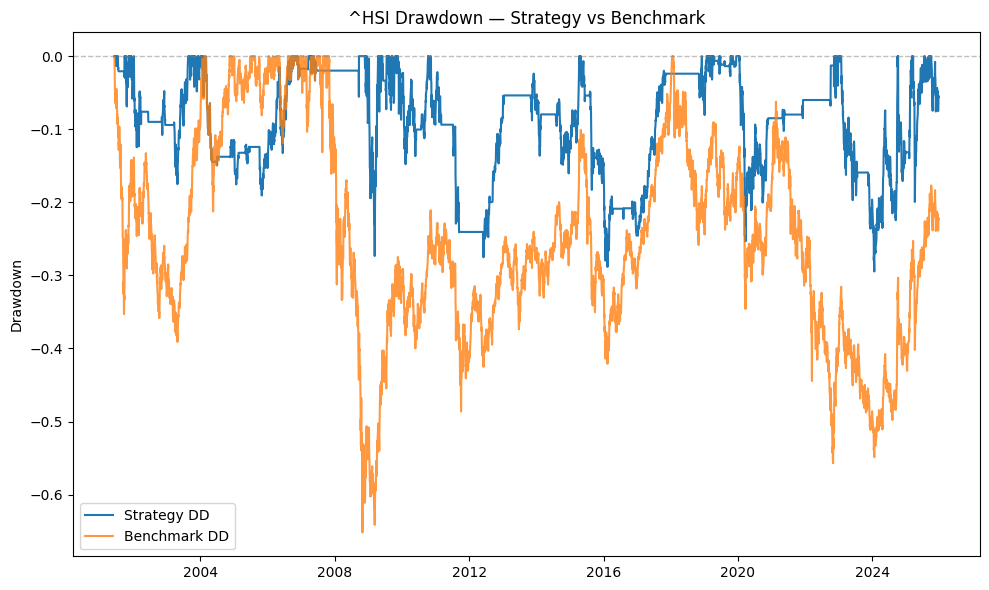

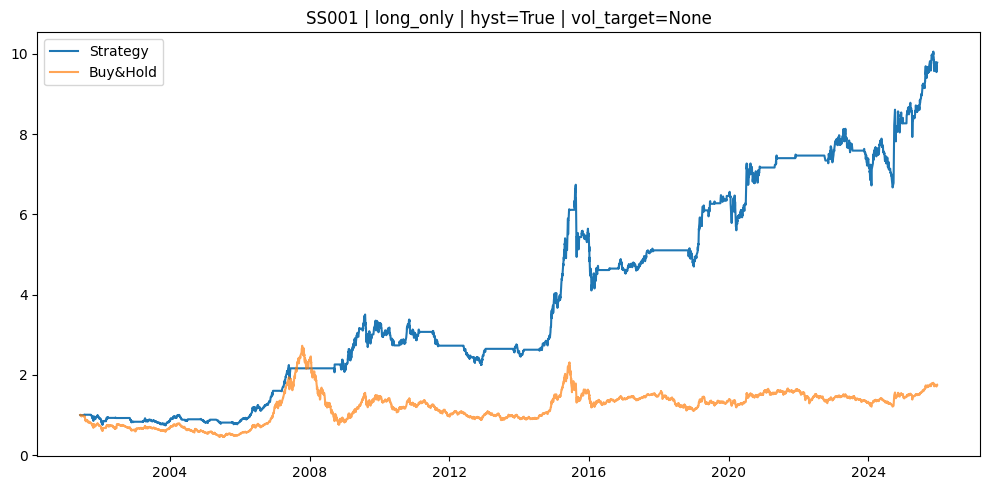

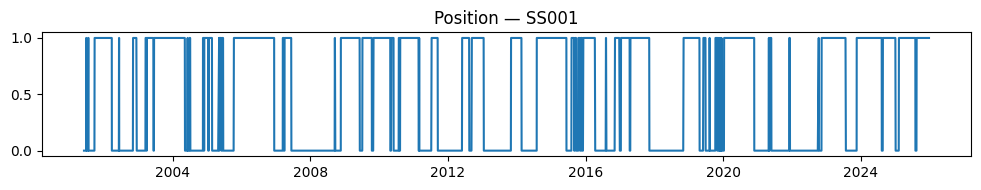

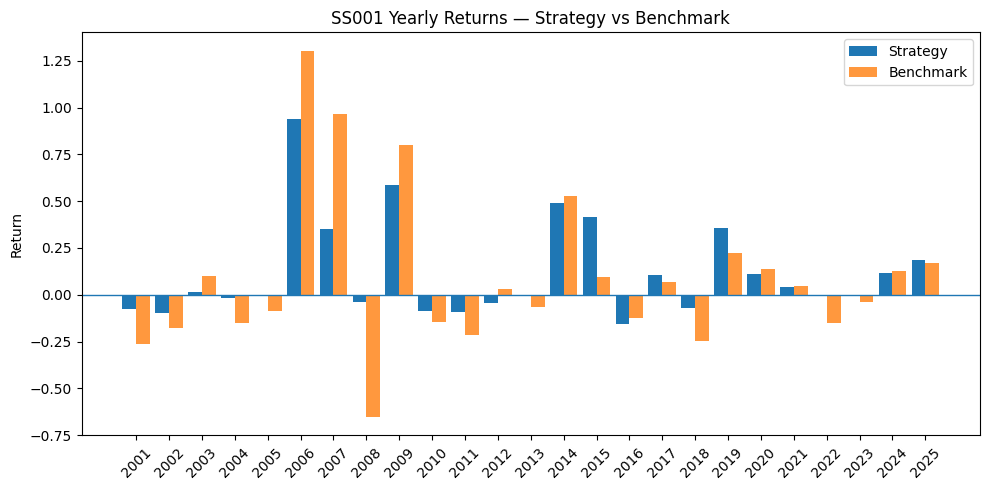

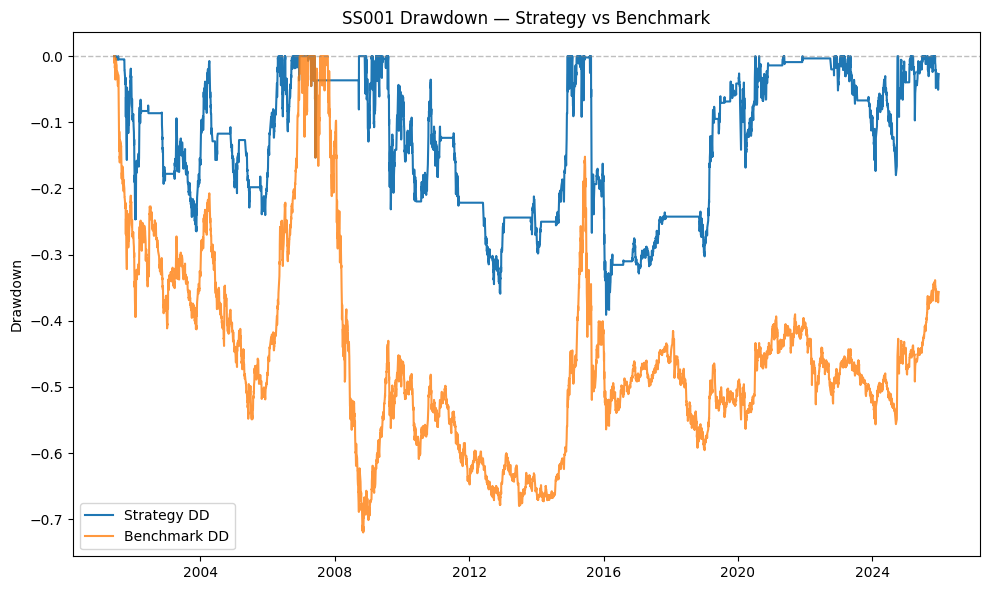

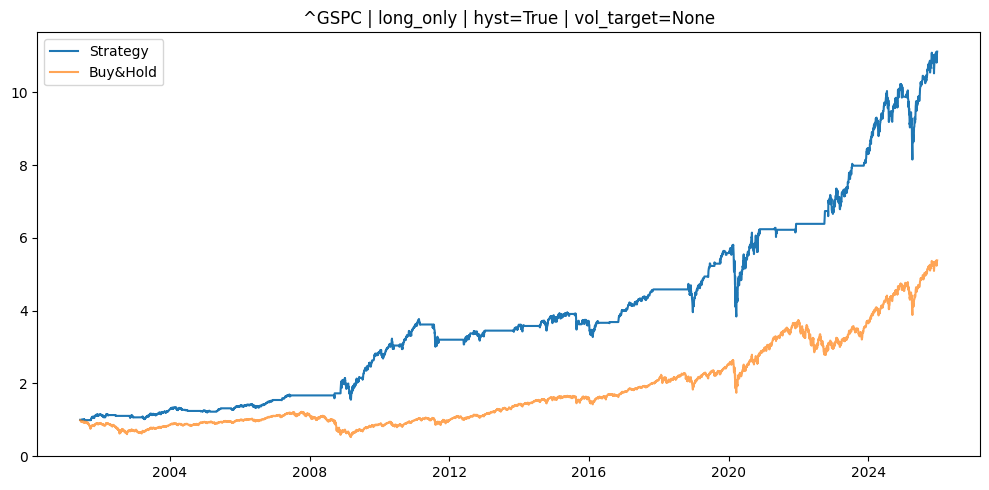

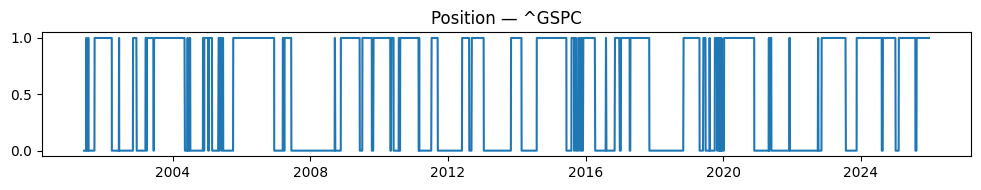

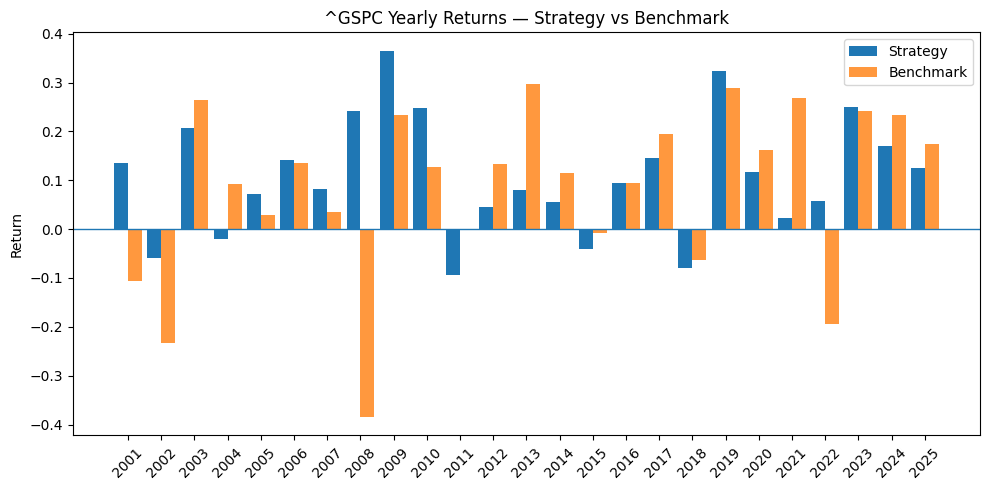

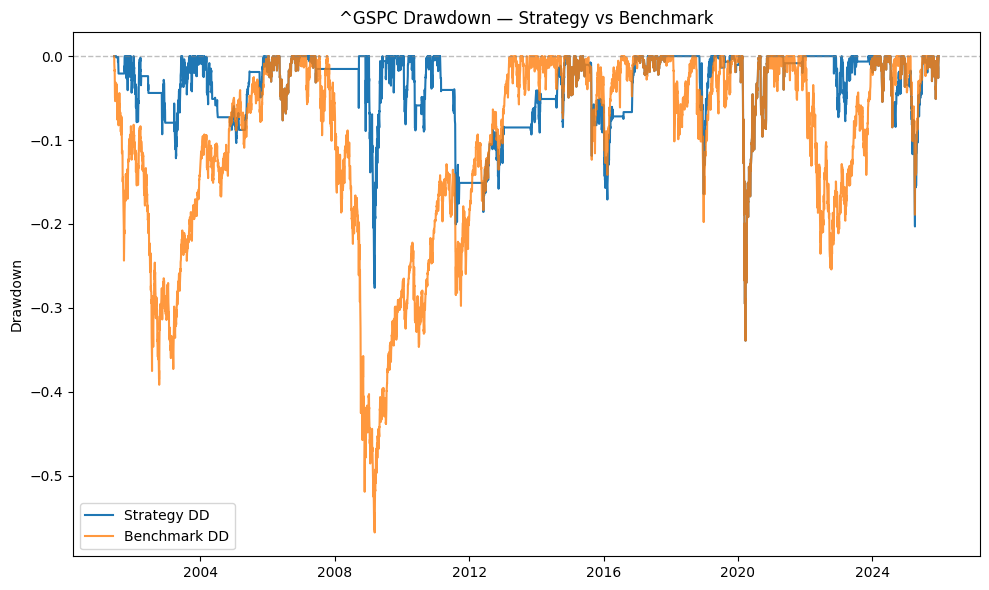

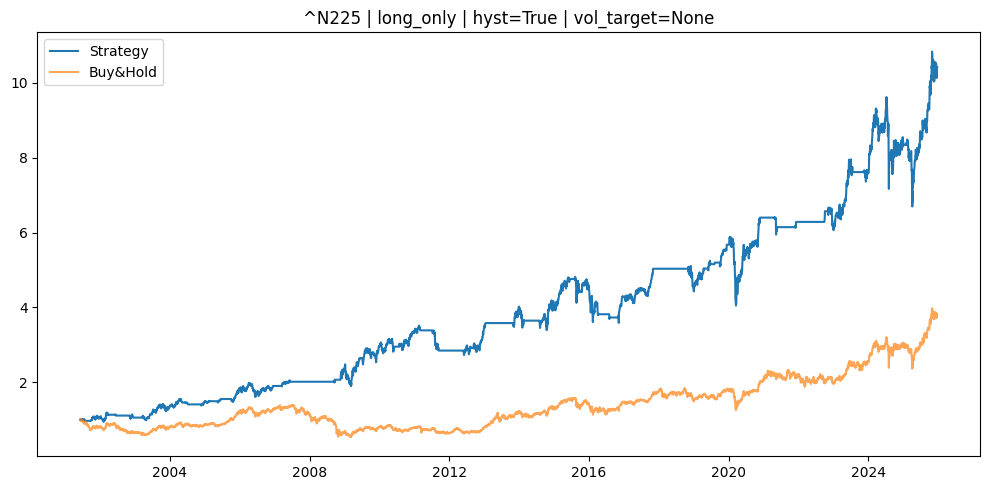

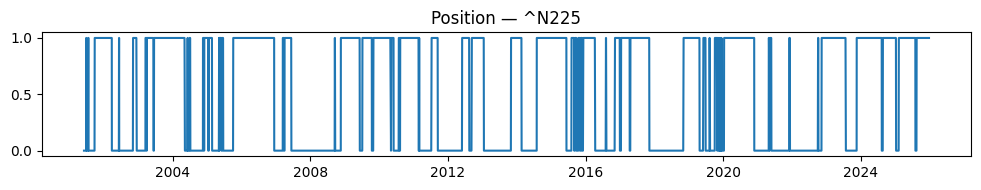

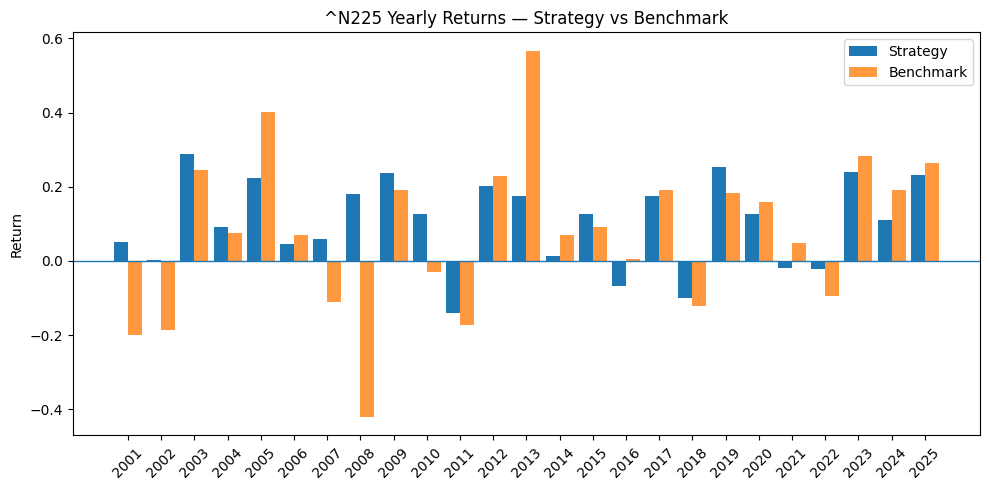

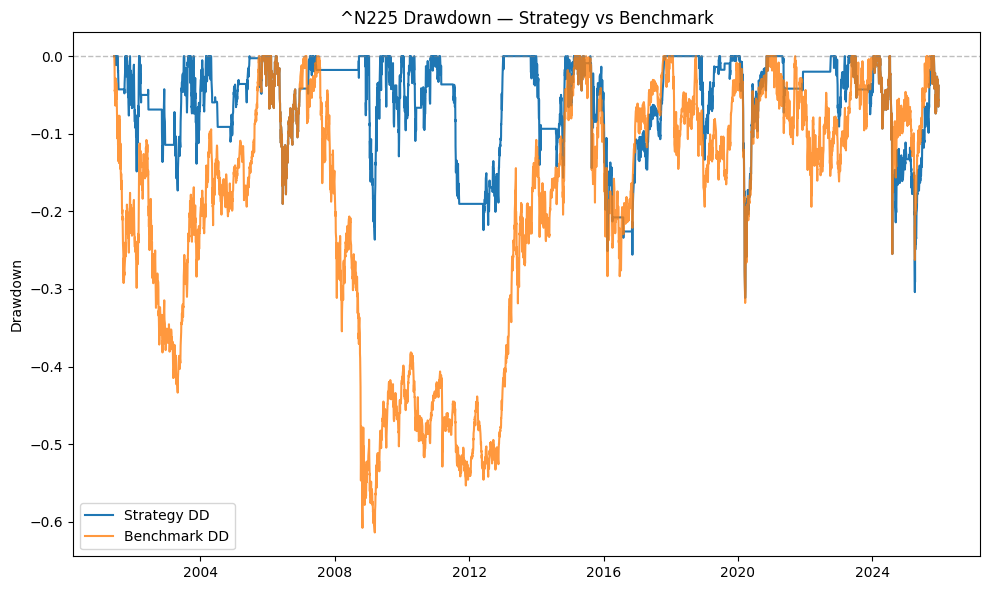

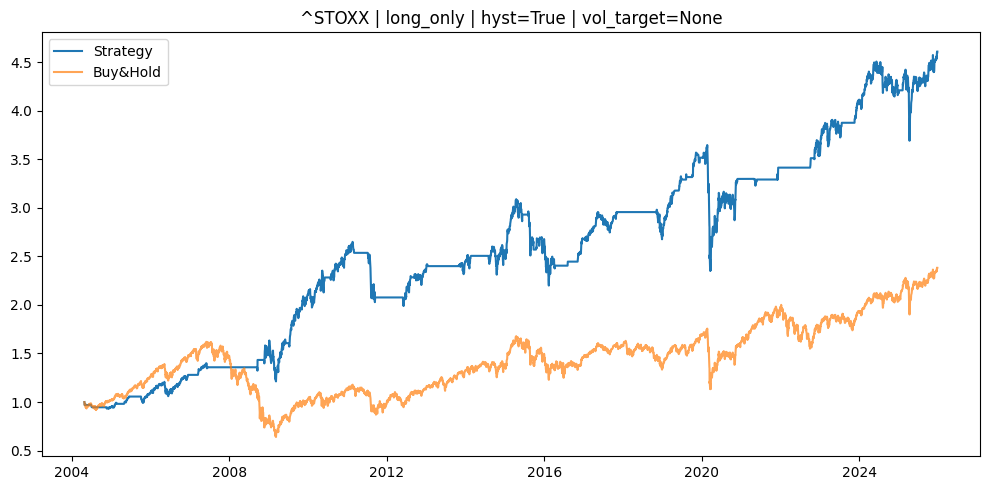

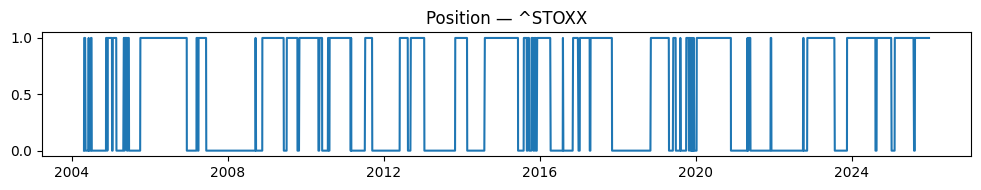

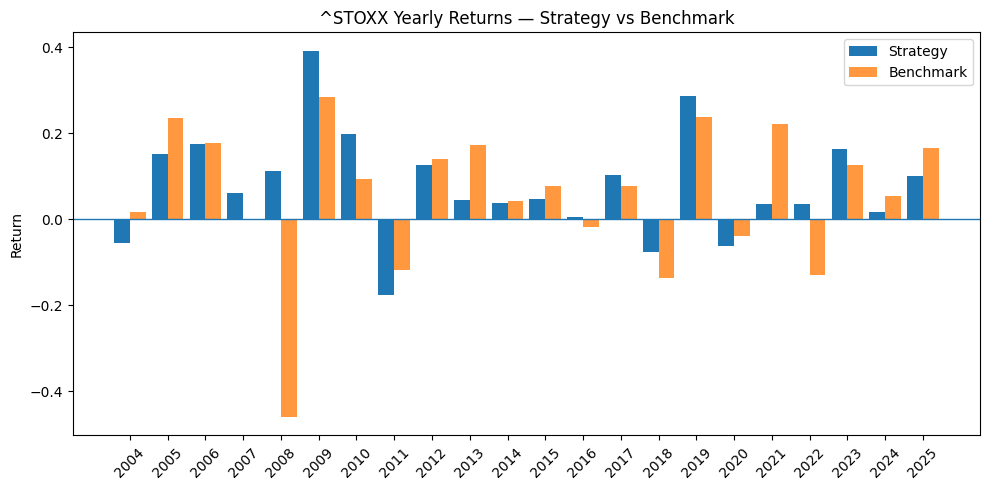

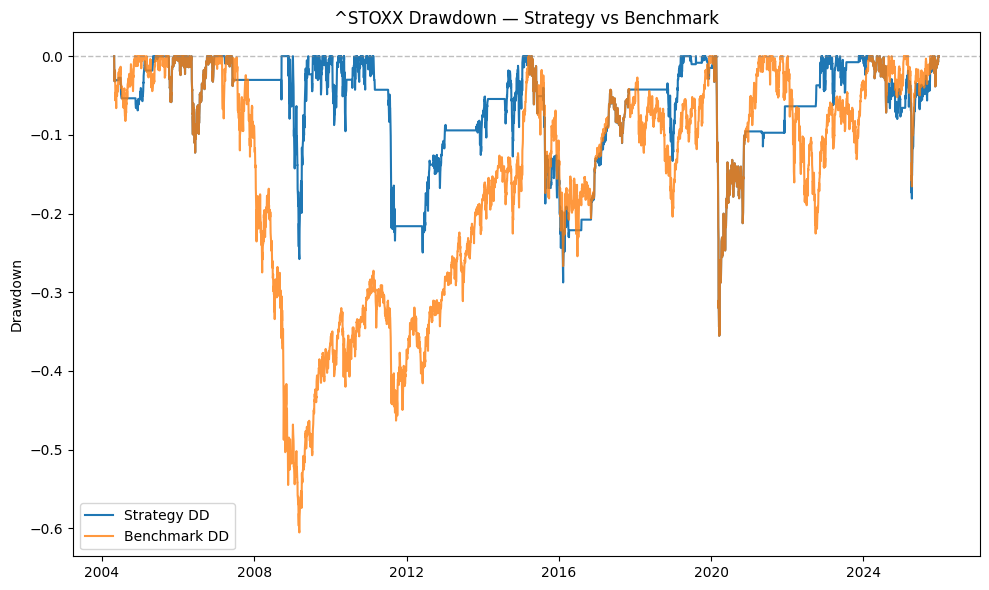

,market,mode,hysteresis,z_window,vol_target,ann_ret,ann_vol,sharpe,max_dd,bh_ann_ret,bh_sharpe,max_dd_bh,avg_abs_exposure,pct_in_market,regime_on_share
0,SS001,long_only,True,180,None,0.116930,0.169470,0.689973,-0.390955,0.054582,0.225733,-0.719848,0.536211,0.536211,0.536390
1,^GSPC,long_only,True,180,None,0.113329,0.141370,0.801650,-0.339250,0.091347,0.467044,-0.567754,0.537258,0.537258,0.537428
2,^HSI,long_only,True,180,None,0.105533,0.160561,0.657276,-0.294653,0.055609,0.236154,-0.651819,0.537141,0.537141,0.537311
3,^N225,long_only,True,180,None,0.121634,0.172367,0.705671,-0.311482,0.090586,0.373771,-0.613679,0.536766,0.536766,0.536947
4,^STOXX,long_only,True,180,None,0.084484,0.135206,0.624855,-0.355474,0.059925,0.324230,-0.605381,0.529320,0.529320,0.529515


In [21]:
# Run batch summary:
window = 180

out = run_multi_market_tests(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    z_window=window,
    hysteresis=True,
    modes=tuple(['long_only']),
    upper=0.2,
    lower=-0.2,
    # vol_target=0.12,
    plot=True,
    return_details=True,
    # trend_filter=120,
    
)

summary_df = out["summary"]
details = out["details"]

summary_df

In [185]:
# rows = []
# 
# for (symbol, mode), pack in details.items():
#     df = pack["df"].copy()
# 
#     # make date a column
#     df = df.reset_index().rename(columns={df.index.name or "index": "date"})
#     df["symbol"] = symbol
#     df["mode"] = mode
# 
#     # ---- attach scalar stats (flatten nested dicts) ----
#     s = pack["stats"]
# 
#     # top-level scalars (adjust to whatever you care about)
#     for k in ["hysteresis", "z_window", "vol_target", "avg_exposure", "pct_in_market", "regime_on_share"]:
#         if k in s:
#             df[f"stat_{k}"] = s[k]
# 
#     # flatten strategy/buy_hold perf stats into columns
#     if "strategy" in s and isinstance(s["strategy"], dict):
#         for k, v in s["strategy"].items():
#             df[f"stat_strategy_{k}"] = v
# 
#     if "buy_hold" in s and isinstance(s["buy_hold"], dict):
#         for k, v in s["buy_hold"].items():
#             df[f"stat_benchmark_{k}"] = v
# 
#     # ---- optional: map yearly returns onto each day (still ONE CSV) ----
#     # yearly_returns is a DataFrame indexed by year with cols like ["strategy","benchmark","excess"]
#     if "yearly_returns" in s and isinstance(s["yearly_returns"], pd.DataFrame):
#         yr = s["yearly_returns"].copy()
#         yr.index = yr.index.astype(int)  # ensure year is int index
#         df["year"] = pd.to_datetime(df["date"]).dt.year
# 
#         for col in yr.columns:
#             df[f"yr_{col}"] = df["year"].map(yr[col].to_dict())
# 
#     rows.append(df)
# 
# all_details = pd.concat(rows, ignore_index=True)
# 
# # save once
# all_details.to_csv("co_regime_all_details.csv", index=False)
# 
# print(all_details.shape)
# print("Saved: co_regime_all_details.csv")

print(summary_df)

    market       mode  hysteresis  z_window vol_target   ann_ret   ann_vol  \
0   CSI300  long_only        True       180       None  0.185888  0.239798   
1    SS001  long_only        True       180       None  0.116930  0.169470   
2    ^GSPC  long_only        True       180       None  0.113329  0.141370   
3    ^HSCE  long_only        True       180       None  0.152314  0.198650   
4     ^HSI  long_only        True       180       None  0.105533  0.160561   
5    ^N225  long_only        True       180       None  0.121634  0.172367   
6   ^STOXX  long_only        True       180       None  0.084484  0.135206   
7  chiNext  long_only        True       180       None  0.176782  0.251072   

     sharpe    max_dd  bh_ann_ret  bh_sharpe  max_dd_bh  avg_abs_exposure  \
0  0.775185 -0.434178    0.116141   0.383775  -0.498285          0.545002   
1  0.689973 -0.390955    0.054582   0.225733  -0.719848          0.536211   
2  0.801650 -0.339250    0.091347   0.467044  -0.567754          0

In [234]:
# for (symbol, mode), pack in details.items():
#     df = pack["yearly_returns"].copy()
#     print(symbol, df)
def describe_on_off(d: pd.DataFrame, mkt_ret_col="mkt_ret", reg_col="regime"):
    x = d[[mkt_ret_col, reg_col]].dropna().copy()
    x["state"] = x[reg_col].astype(int)

    out = []
    for s in [0, 1]:
        r = x.loc[x["state"] == s, mkt_ret_col]
        if len(r) < 50:
            continue
        eq = (1 + r).cumprod()
        dd = (eq / eq.cummax() - 1).min()
        # simple tail metrics
        var95 = r.quantile(0.05)
        cvar95 = r[r <= var95].mean()

        out.append({
            "state": s,
            "n_days": len(r),
            "mean_daily": r.mean(),
            "vol_daily": r.std(),
            "ann_ret": r.mean() * 252,
            "ann_vol": r.std() * np.sqrt(252),
            "sharpe": (r.mean() * 252) / (r.std() * np.sqrt(252) + 1e-12),
            "max_dd_in_state": dd,
            "VaR_95_daily": var95,
            "CVaR_95_daily": cvar95,
        })
    return pd.DataFrame(out).set_index("state")

def flip_event_study(d: pd.DataFrame, horizon_days=(5, 20, 60)):
    x = d[["regime", "mkt_ret"]].dropna().copy()
    x["reg_prev"] = x["regime"].shift(1)
    x["flip"] = (x["regime"] != x["reg_prev"]) & x["reg_prev"].notna()

    # classify flips
    x["flip_type"] = np.where((x["reg_prev"] == 0) & (x["regime"] == 1), "OFF_to_ON",
                      np.where((x["reg_prev"] == 1) & (x["regime"] == 0), "ON_to_OFF", None))

    flips = x.loc[x["flip_type"].notna()].index
    out_rows = []
    for ftype in ["OFF_to_ON", "ON_to_OFF"]:
        fdates = x.index[x["flip_type"] == ftype]
        for H in horizon_days:
            fwd = []
            for t in fdates:
                # forward cumulative return from t+1 to t+H
                r = x.loc[t:].iloc[1:H+1]["mkt_ret"]
                if len(r) == H:
                    fwd.append((1 + r).prod() - 1)
            if len(fwd) > 0:
                out_rows.append({
                    "flip_type": ftype,
                    "H": H,
                    "n": len(fwd),
                    "mean_fwd_ret": float(np.mean(fwd)),
                    "median_fwd_ret": float(np.median(fwd)),
                })
    return pd.DataFrame(out_rows)

def regime_stability_stats(d: pd.DataFrame):
    x = d[["regime"]].dropna().copy()
    x["reg_prev"] = x["regime"].shift(1)
    x["flip"] = (x["regime"] != x["reg_prev"]) & x["reg_prev"].notna()

    flips = int(x["flip"].sum())
    years = (x.index[-1] - x.index[0]).days / 365.25
    flips_per_year = flips / years if years > 0 else np.nan

    # segment durations
    seg_id = (x["regime"] != x["reg_prev"]).cumsum()
    seg_len = x.groupby(seg_id).size()
    seg_state = x.groupby(seg_id)["regime"].first()

    on_lens = seg_len[seg_state == 1]
    off_lens = seg_len[seg_state == 0]

    return {
        "on_share": float(x["regime"].mean()),
        "flips_total": flips,
        "flips_per_year": float(flips_per_year),
        "avg_on_duration_days": float(on_lens.mean()) if len(on_lens) else np.nan,
        "avg_off_duration_days": float(off_lens.mean()) if len(off_lens) else np.nan,
        "median_on_duration_days": float(on_lens.median()) if len(on_lens) else np.nan,
        "median_off_duration_days": float(off_lens.median()) if len(off_lens) else np.nan,
    }

def block_permute_regime(reg: pd.Series, block_len: int = 60, seed: int = 0) -> pd.Series:
    rng = np.random.default_rng(seed)
    reg = reg.dropna().astype(int)
    idx = reg.index
    vals = reg.values

    blocks = [vals[i:i+block_len] for i in range(0, len(vals), block_len)]
    rng.shuffle(blocks)
    perm = np.concatenate(blocks)[:len(vals)]
    return pd.Series(perm, index=idx)

def placebo_test(d: pd.DataFrame, n_sims: int = 500, block_len: int = 60):
    x = d[["mkt_ret", "regime"]].dropna().copy()
    base = perf_stats((x["regime"].shift(1).fillna(0) * x["mkt_ret"]))
    bh = perf_stats(x["mkt_ret"])

    obs_delta = base["sharpe"] - bh["sharpe"]

    deltas = []
    for i in range(n_sims):
        reg_p = block_permute_regime(x["regime"], block_len=block_len, seed=i)
        strat_ret = reg_p.shift(1).fillna(0) * x["mkt_ret"]
        s = perf_stats(strat_ret)
        deltas.append(s["sharpe"] - bh["sharpe"])

    deltas = np.array(deltas)
    pval = (np.sum(deltas >= obs_delta) + 1) / (len(deltas) + 1)
    return obs_delta, float(pval), deltas

# Example for HSI
for market in markets:
    d = details[(market, "long_only")]["df"]
    print(f'==== {market} ====')
    print(describe_on_off(d))
    print(flip_event_study(d))
    print(regime_stability_stats(d))
    obs_delta, pval, deltas = placebo_test(d, n_sims=500, block_len=60)
    print("Observed ΔSharpe:", obs_delta, "Placebo p-value:", pval)
    print('\n')


==== ^HSI ====
       n_days  mean_daily  vol_daily   ann_ret   ann_vol    sharpe  \
state                                                                
0        2721   -0.000433   0.015965 -0.109131  0.253438 -0.430603   
1        3161    0.000783   0.013763  0.197417  0.218483  0.903582   

       max_dd_in_state  VaR_95_daily  CVaR_95_daily  
state                                                
0            -0.816111     -0.024623      -0.036954  
1            -0.309628     -0.020839      -0.030026  
   flip_type   H   n  mean_fwd_ret  median_fwd_ret
0  OFF_to_ON   5  59      0.003018       -0.000358
1  OFF_to_ON  20  59      0.012048        0.005967
2  OFF_to_ON  60  59      0.014108        0.037209
3  ON_to_OFF   5  58     -0.000662        0.001429
4  ON_to_OFF  20  58     -0.002478        0.006087
5  ON_to_OFF  60  58      0.003113        0.009207
{'on_share': 0.5373108958014619, 'flips_total': 117, 'flips_per_year': 4.765724322515892, 'avg_on_duration_days': 53.57627118644068

## Deeper Investigation
### Ratio vs Copper-only vs Oil-only (HK/China focus)

In [192]:
def build_regime_from_series(
    x: pd.Series,
    *,
    z_window: int = 180,
    upper: float = 0.2,
    lower: float = -0.2,
    hysteresis: bool = True,
) -> pd.DataFrame:
    """
    x: a time series (already aligned/cleaned), e.g. log ratio, log copper, log oil
    Returns DataFrame with z and regime.
    """
    x = pd.to_numeric(x, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    z = rolling_zscore(x, z_window)

    if not hysteresis:
        regime = (z > 0).astype(int)
    else:
        state = []
        cur = 0
        for val in z.values:
            if np.isnan(val):
                state.append(cur)
                continue
            if cur == 0 and val > upper:
                cur = 1
            elif cur == 1 and val < lower:
                cur = 0
            state.append(cur)
        regime = pd.Series(state, index=z.index).astype(int)

    return pd.DataFrame({"x": x, "z": z, "regime": regime}).dropna()

def backtest_with_precomputed_regime(
    market_price: pd.Series,
    regime_df: pd.DataFrame,
    *,
    market_name: str,
    ann_factor: int = 252,
) -> dict:
    """
    Long-only gate: position=regime.shift(1)
    Returns stats + df similar to run_co_regime_backtest.
    """
    market_price = _ensure_price_series(market_price, market_name)
    d = pd.concat([market_price, regime_df[["regime", "z"]]], axis=1).dropna().copy()

    d["mkt_ret"] = d[market_name].pct_change()
    d["position"] = d["regime"].astype(float).shift(1).fillna(0.0)
    d["strategy_ret"] = d["position"] * d["mkt_ret"]
    d["eq_strategy"] = (1 + d["strategy_ret"]).cumprod()
    d["eq_bh"] = (1 + d["mkt_ret"]).cumprod()

    d = add_drawdowns(d)

    stats = {
        "market": market_name,
        "ann_ret": perf_stats(d["strategy_ret"], ann_factor=ann_factor)["ann_ret"],
        "ann_vol": perf_stats(d["strategy_ret"], ann_factor=ann_factor)["ann_vol"],
        "sharpe": perf_stats(d["strategy_ret"], ann_factor=ann_factor)["sharpe"],
        "max_dd": perf_stats(d["strategy_ret"], ann_factor=ann_factor)["max_dd"],
        "bh_sharpe": perf_stats(d["mkt_ret"], ann_factor=ann_factor)["sharpe"],
        "delta_sharpe": perf_stats(d["strategy_ret"], ann_factor=ann_factor)["sharpe"] - perf_stats(d["mkt_ret"], ann_factor=ann_factor)["sharpe"],
        "on_share": float(d["regime"].mean()),
        "flips_per_year": float(((d["regime"].diff().abs() == 1).sum()) / ((d.index[-1]-d.index[0]).days/365.25)),
    }

    return {"stats": stats, "df": d}

def compare_ratio_vs_components(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    z_window: int = 180,
    upper: float = 0.2,
    lower: float = -0.2,
    hysteresis: bool = True,
) -> pd.DataFrame:
    copper = _ensure_price_series(copper, "copper")
    oil = _ensure_price_series(oil, "oil")

    # Build three candidate signals (log scale for stationarity)
    df = pd.concat([copper, oil], axis=1).dropna()
    sig_ratio = np.log(df["copper"] / df["oil"]).rename("log_ratio")
    sig_cu = np.log(df["copper"]).rename("log_copper")
    sig_oil = np.log(df["oil"]).rename("log_oil")

    regimes = {
        "ratio": build_regime_from_series(sig_ratio, z_window=z_window, upper=upper, lower=lower, hysteresis=hysteresis),
        "copper_only": build_regime_from_series(sig_cu, z_window=z_window, upper=upper, lower=lower, hysteresis=hysteresis),
        "oil_only": build_regime_from_series(sig_oil, z_window=z_window, upper=upper, lower=lower, hysteresis=hysteresis),
    }

    rows = []
    for mkt_name, price in markets.items():
        for label, regdf in regimes.items():
            out = backtest_with_precomputed_regime(price, regdf, market_name=mkt_name)
            s = out["stats"]
            rows.append({
                "market": mkt_name,
                "signal": label,
                "delta_sharpe": s["delta_sharpe"],
                "sharpe": s["sharpe"],
                "bh_sharpe": s["bh_sharpe"],
                "ann_ret": s["ann_ret"],
                "max_dd": s["max_dd"],
                "on_share": s["on_share"],
                "flips_per_year": s["flips_per_year"],
            })

    return pd.DataFrame(rows).sort_values(["market", "delta_sharpe"], ascending=[True, False]).reset_index(drop=True)

priority_markets = {
    "^HSI": hsi,
    "^HSCE": hsce,
    "SS001": ss001,
    "CSI300": csi300,  # ensure this is correctly defined/instrument-labeled
}

cmp_df = compare_ratio_vs_components(
    priority_markets,
    copper=df["copper"],
    oil=df["oil"],
    z_window=180,
    upper=0.2,
    lower=-0.2,
    hysteresis=True,
)

print(cmp_df)

    market       signal  delta_sharpe    sharpe  bh_sharpe   ann_ret  \
0   CSI300        ratio      0.391410  0.775185   0.383775  0.185888   
1   CSI300  copper_only      0.021745  0.405520   0.383775  0.065103   
2   CSI300     oil_only     -0.586542 -0.202767   0.383775 -0.029384   
3    SS001        ratio      0.464240  0.689973   0.225733  0.116930   
4    SS001  copper_only      0.067214  0.292947   0.225733  0.051157   
5    SS001     oil_only     -0.312457 -0.086725   0.225733 -0.015087   
6    ^HSCE        ratio      0.436151  0.766746   0.330595  0.152314   
7    ^HSCE  copper_only      0.229759  0.560354   0.330595  0.112665   
8    ^HSCE     oil_only     -0.114086  0.216509   0.330595  0.044890   
9     ^HSI        ratio      0.421122  0.657276   0.236154  0.105533   
10    ^HSI  copper_only      0.243961  0.480115   0.236154  0.074592   
11    ^HSI     oil_only     -0.069119  0.167035   0.236154  0.026446   

      max_dd  on_share  flips_per_year  
0  -0.434178  0.545313

### Worst-days capture and opportunity cost

In [248]:
def worst_day_capture(d: pd.DataFrame, q: float = 0.05, state_col: str = "regime") -> dict:
    """
    Measures how much of the benchmark left tail occurs when state_col is OFF vs ON.
    state_col can be:
      - "regime" (same-day state classification)
      - "pos_state" (tradeable state, i.e., regime.shift(1) for long-only)
    """
    x = d[["mkt_ret", state_col]].dropna().copy()

    # Ensure binary int states (0/1)
    x[state_col] = x[state_col].astype(int)

    thr_worst = x["mkt_ret"].quantile(q)
    worst = x[x["mkt_ret"] <= thr_worst]
    best = x[x["mkt_ret"] >= x["mkt_ret"].quantile(1 - q)]

    return {
        "q": q,
        "thr_worst": float(thr_worst),
        "n_total": int(len(x)),
        "n_worst": int(len(worst)),
        "worst_in_OFF_share": float((worst[state_col] == 0).mean()),
        "worst_in_ON_share": float((worst[state_col] == 1).mean()),
        "best_in_OFF_share": float((best[state_col] == 0).mean()),
        "best_in_ON_share": float((best[state_col] == 1).mean()),
        "avg_worst_ret": float(worst["mkt_ret"].mean()),
        "avg_best_ret": float(best["mkt_ret"].mean()),
    }


def run_tail_attribution(details: dict, markets: list[str], qs=(0.01, 0.05)):
    rows = []
    for m in markets:
        d = details[(m, "long_only")]["df"].copy()

        # Ensure pos_state exists
        if "pos_state" not in d.columns:
            d["pos_state"] = d["regime"].shift(1).fillna(0).astype(int)

        for q in qs:
            r_reg = worst_day_capture(d, q=q, state_col="regime")
            rows.append({"market": m, "state_used": "regime", **r_reg})

            r_pos = worst_day_capture(d, q=q, state_col="pos_state")
            rows.append({"market": m, "state_used": "pos_state", **r_pos})

    return pd.DataFrame(rows)



tail_df = run_tail_attribution(
    details,
    markets=["^HSI", "^HSCE", "SS001", "chiNext"],
    qs=(0.01, 0.05),
)
# print(tail_df)

def tail_loss_avoidance(d: pd.DataFrame, q: float = 0.01) -> dict:
    """
    On the benchmark's worst q% days, measure how much the strategy actually lost vs buy&hold.
    Requires columns: mkt_ret, strategy_ret, position (optional).
    """
    x = d[["mkt_ret", "strategy_ret", "position"]].dropna().copy()

    thr = x["mkt_ret"].quantile(q)
    worst = x[x["mkt_ret"] <= thr]

    avg_bh = float(worst["mkt_ret"].mean())
    avg_strat = float(worst["strategy_ret"].mean())
    avg_abs_pos = float(worst["position"].abs().mean())

    # Avoid division sign issues: avg_bh is negative in worst-tail by construction
    capture_ratio = float(avg_strat / avg_bh) if avg_bh != 0 else np.nan

    return {
        "q": q,
        "thr_worst": float(thr),
        "n_total": int(len(x)),
        "n_worst": int(len(worst)),
        "avg_bh_ret_worst": avg_bh,
        "avg_strat_ret_worst": avg_strat,
        "loss_avoided": float(avg_bh - avg_strat),     # should be negative - (less negative) => positive improvement
        "capture_ratio": capture_ratio,                # for long-only gating: closer to 0 is better
        "avg_abs_position_on_worst": avg_abs_pos,      # should be materially < overall avg exposure
    }

def run_tail_loss_avoidance(details, markets, qs=(0.01, 0.05)):
    rows = []
    for m in markets:
        d = details[(m, "long_only")]["df"]
        for q in qs:
            rows.append({"market": m, **tail_loss_avoidance(d, q=q)})
    return pd.DataFrame(rows)

tail_loss_df = run_tail_loss_avoidance(
    details,
    markets=["^HSI", "^HSCE", "SS001", "CSI300"],
    qs=(0.01, 0.05),
)
tail_loss_df

,market,q,thr_worst,n_total,n_worst,avg_bh_ret_worst,avg_strat_ret_worst,loss_avoided,capture_ratio,avg_abs_position_on_worst
0,^HSI,0.01,-0.039833,5882,59,-0.055288,-0.018334,-0.036953,0.331617,0.338983
1,^HSI,0.05,-0.022398,5882,295,-0.033469,-0.013612,-0.019856,0.406712,0.427119
2,^HSCE,0.01,-0.049614,5882,59,-0.067785,-0.018066,-0.049719,0.266524,0.271186
3,^HSCE,0.05,-0.027510,5882,295,-0.041388,-0.016210,-0.025179,0.391652,0.406780
4,SS001,0.01,-0.047216,5605,57,-0.062616,-0.029532,-0.033084,0.471636,0.473684
5,SS001,0.05,-0.022950,5605,281,-0.037381,-0.016590,-0.020791,0.443809,0.437722
6,CSI300,0.01,-0.048934,3210,33,-0.075945,-0.047594,-0.028350,0.626697,0.575758
7,CSI300,0.05,-0.022787,3210,161,-0.039938,-0.020166,-0.019772,0.504933,0.459627


In [203]:
SUBPERIODS = [
    ("2000-01-01", "2009-12-31", "2000_2009"),
    ("2010-01-01", "2016-12-31", "2010_2016"),
    ("2017-01-01", "2025-12-31", "2017_2025"),
]

def slice_df(d: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    return d.loc[(d.index >= pd.to_datetime(start)) & (d.index <= pd.to_datetime(end))].copy()

def subperiod_report_for_market(d: pd.DataFrame, start: str, end: str, label: str, market_name: str) -> dict:
    x = slice_df(d, start, end)

    # Ensure pos_state exists (tradeable state)
    if "pos_state" not in x.columns:
        x["pos_state"] = x["regime"].shift(1).fillna(0).astype(int)

    # Basic strategy vs benchmark stats
    strat = perf_stats(x["strategy_ret"])
    bh = perf_stats(x["mkt_ret"])

    # ON vs OFF conditional stats (using pos_state)
    out_state = x[x["pos_state"] == 0]["mkt_ret"]
    on_state = x[x["pos_state"] == 1]["mkt_ret"]

    off_stats = perf_stats(out_state)  # benchmark behavior while OUT (for diagnosing regime quality)
    on_stats = perf_stats(on_state)    # benchmark behavior while IN

    # Tail capture inside subperiod (tradeable)
    tail1 = worst_day_capture(x, q=0.01, state_col="pos_state")
    tail5 = worst_day_capture(x, q=0.05, state_col="pos_state")

    return {
        "market": market_name,
        "period": label,
        "n_days": int(x["mkt_ret"].dropna().shape[0]),

        # Strategy headline
        "sharpe_strat": strat["sharpe"],
        "sharpe_bh": bh["sharpe"],
        "delta_sharpe": strat["sharpe"] - bh["sharpe"],
        "max_dd_strat": strat["max_dd"],
        "max_dd_bh": bh["max_dd"],

        # Exposure / state frequency
        "on_share_pos": float(x["pos_state"].mean()),

        # Conditional benchmark behavior (mechanism)
        "bh_sharpe_when_IN": on_stats["sharpe"],
        "bh_ann_ret_when_IN": on_stats["ann_ret"],
        "bh_sharpe_when_OUT": off_stats["sharpe"],
        "bh_ann_ret_when_OUT": off_stats["ann_ret"],

        # Tail concentration (tradeable)
        "worst1_off_share": tail1["worst_in_OFF_share"],
        "worst5_off_share": tail5["worst_in_OFF_share"],
    }

def run_subperiod_stability(details: dict, markets: list[str], subperiods=SUBPERIODS) -> pd.DataFrame:
    rows = []
    for m in markets:
        d = details[(m, "long_only")]["df"]
        for start, end, label in subperiods:
            rows.append(subperiod_report_for_market(d, start, end, label, m))
    return pd.DataFrame(rows).sort_values(["market", "period"]).reset_index(drop=True)

stability_df = run_subperiod_stability(
    details,
    markets=["^HSI", "^HSCE", "SS001", "chiNext"],
)

print(stability_df)

     market     period  n_days  sharpe_strat  sharpe_bh  delta_sharpe  \
0     SS001  2000_2009    1943      0.894767   0.315557      0.579210   
1     SS001  2010_2016    1605      0.383190   0.085964      0.297227   
2     SS001  2017_2025    2057      0.780477   0.252806      0.527671   
3     ^HSCE  2000_2009    2051      1.387535   0.731725      0.655810   
4     ^HSCE  2010_2016    1680     -0.020586  -0.064598      0.044012   
5     ^HSCE  2017_2025    2151      0.636687   0.102365      0.534322   
6      ^HSI  2000_2009    2051      1.026093   0.354879      0.671214   
7      ^HSI  2010_2016    1680     -0.047831   0.100213     -0.148044   
8      ^HSI  2017_2025    2151      0.747806   0.195467      0.552339   
9   chiNext  2000_2009       0           NaN        NaN           NaN   
10  chiNext  2010_2016    1173      0.741298   0.610876      0.130422   
11  chiNext  2017_2025    2056      0.682782   0.364235      0.318547   

    max_dd_strat  max_dd_bh  on_share_pos  bh_shar

In [208]:
def ensure_pos_state(d: pd.DataFrame) -> pd.DataFrame:
    x = d.copy()
    if "pos_state" not in x.columns:
        if "regime" not in x.columns:
            raise ValueError("Need 'regime' to build pos_state = regime.shift(1).")
        x["pos_state"] = x["regime"].shift(1).fillna(0).astype(int)
    return x

def run_tail_loss_by_subperiod(details: dict, markets: list[str], subperiods=SUBPERIODS, qs=(0.01, 0.05)) -> pd.DataFrame:
    rows = []
    for m in markets:
        d0 = details[(m, "long_only")]["df"]
        for start, end, label in subperiods:
            d = slice_df(d0, start, end)
            if d.empty:
                continue
            for q in qs:
                r = tail_loss_avoidance(d, q=q)
                rows.append({"market": m, "period": label, **r})
    return pd.DataFrame(rows).sort_values(["market", "period", "q"]).reset_index(drop=True)

def worst_days_audit(
    d: pd.DataFrame,
    n: int = 20,
    *,
    sort_col: str = "mkt_ret",   # benchmark worst days
) -> pd.DataFrame:
    """
    Returns a table of the worst n days ranked by sort_col (default: mkt_ret).
    Includes whether you were OUT (pos_state==0) and your realized strategy return.
    """
    x = ensure_pos_state(d)
    cols = [c for c in ["mkt_ret","strategy_ret","position","regime","pos_state","z_co"] if c in x.columns]
    x = x[cols].dropna().copy()

    out = x.sort_values(sort_col, ascending=True).head(n).copy()
    out["OUT?"] = (out["pos_state"] == 0).astype(int)
    out["IN?"] = (out["pos_state"] == 1).astype(int)
    out.index.name = "date"
    return out

# tail_sub_df = run_tail_loss_by_subperiod(
#     details,
#     markets=["^HSI", "^HSCE", "SS001", "chiNext"],
#     subperiods=SUBPERIODS,
#     qs=(0.01, 0.05),
# )
# tail_sub_df

audit_hsce = worst_days_audit(details[("^HSCE","long_only")]["df"], n=25, sort_col="mkt_ret")
audit_hsi  = worst_days_audit(details[("^HSI","long_only")]["df"],  n=25, sort_col="mkt_ret")

print(audit_hsce)
print(audit_hsi)


             mkt_ret  strategy_ret  position  regime  pos_state      z_co  \
date                                                                        
2008-01-22 -0.181948     -0.000000       0.0     0.0          0 -0.992573   
2008-10-27 -0.140043     -0.000000       0.0     0.0          0 -0.871506   
2025-04-07 -0.137458     -0.137458       1.0     1.0          1  1.379194   
2008-10-08 -0.114551     -0.000000       0.0     0.0          0 -1.515704   
2024-10-08 -0.101692     -0.101692       1.0     1.0          1  1.138888   
2008-10-24 -0.093773     -0.000000       0.0     0.0          0 -1.554504   
2008-11-06 -0.086662     -0.000000       0.0     0.0          0 -0.771026   
2008-10-10 -0.078475     -0.000000       0.0     0.0          0 -1.129376   
2008-10-22 -0.077919     -0.000000       0.0     0.0          0 -1.075761   
2004-05-10 -0.077125     -0.000000       0.0     0.0          0 -0.439660   
2008-09-16 -0.074027     -0.000000       0.0     1.0          0  0.589122   

In [211]:
def fwd_compound_return(ret: pd.Series, H: int) -> pd.Series:
    """
    Forward H-day compounded return aligned to window start t:
    r_fwd[t] = prod(1+ret[t..t+H-1]) - 1
    """
    x = (1.0 + ret).rolling(H).apply(np.prod, raw=True) - 1.0
    return x.shift(-H + 1)

def worst_window_capture(d: pd.DataFrame, H: int = 10, q: float = 0.01) -> dict:
    """
    Identify worst q% forward H-day benchmark windows (by compounded return).
    Compare strategy window return vs benchmark window return on those windows.
    """
    x = ensure_pos_state(d)
    x = x[["mkt_ret","strategy_ret","position","pos_state"]].dropna().copy()

    x["bh_fwdH"] = fwd_compound_return(x["mkt_ret"], H=H)
    x["strat_fwdH"] = fwd_compound_return(x["strategy_ret"], H=H)

    # drop tail where forward window is incomplete
    x = x.dropna(subset=["bh_fwdH", "strat_fwdH"]).copy()

    thr = x["bh_fwdH"].quantile(q)
    worst = x[x["bh_fwdH"] <= thr]

    avg_bh = float(worst["bh_fwdH"].mean())
    avg_strat = float(worst["strat_fwdH"].mean())
    capture_ratio = float(avg_strat / avg_bh) if avg_bh != 0 else np.nan

    avg_abs_pos_start = float(worst["position"].abs().mean())
    share_worst_when_OUT = float((worst["pos_state"] == 0).mean())

    # Positive = good
    loss_reduction = float(avg_strat - avg_bh)

    return {
        "H": H,
        "q": q,
        "thr_worst_window": float(thr),
        "n_total": int(len(x)),
        "n_worst": int(len(worst)),
        "avg_bh_fwdH_worst": avg_bh,
        "avg_strat_fwdH_worst": avg_strat,
        "loss_reduction": loss_reduction,
        "capture_ratio": capture_ratio,
        "avg_abs_position_start": avg_abs_pos_start,
        "share_worst_when_OUT": share_worst_when_OUT,
    }

def run_worst_window_capture(details: dict, markets: list[str], Hs=(5,10,20), qs=(0.01,0.05)) -> pd.DataFrame:
    rows = []
    for m in markets:
        d = details[(m, "long_only")]["df"]
        for H in Hs:
            for q in qs:
                r = worst_window_capture(d, H=H, q=q)
                rows.append({"market": m, **r})
    return pd.DataFrame(rows).sort_values(["market","H","q"]).reset_index(drop=True)


window_df = run_worst_window_capture(
    details,
    markets=["^HSI", "^HSCE", "SS001", "chiNext", 'CSI300'],
    Hs=(5, 10, 20),
    qs=(0.01, 0.05),
)

print(window_df)


     market   H     q  thr_worst_window  n_total  n_worst  avg_bh_fwdH_worst  \
0    CSI300   5  0.01         -0.102480     3206       33          -0.148598   
1    CSI300   5  0.05         -0.051987     3206      161          -0.084045   
2    CSI300  10  0.01         -0.147778     3201       33          -0.194795   
3    CSI300  10  0.05         -0.070015     3201      161          -0.113800   
4    CSI300  20  0.01         -0.173201     3191       32          -0.219258   
5    CSI300  20  0.05         -0.098223     3191      160          -0.146061   
6     SS001   5  0.01         -0.095331     5601       57          -0.122227   
7     SS001   5  0.05         -0.053645     5601      281          -0.080281   
8     SS001  10  0.01         -0.140909     5596       56          -0.174670   
9     SS001  10  0.05         -0.073644     5596      280          -0.112083   
10    SS001  20  0.01         -0.190070     5586       56          -0.220671   
11    SS001  20  0.05         -0.104818 

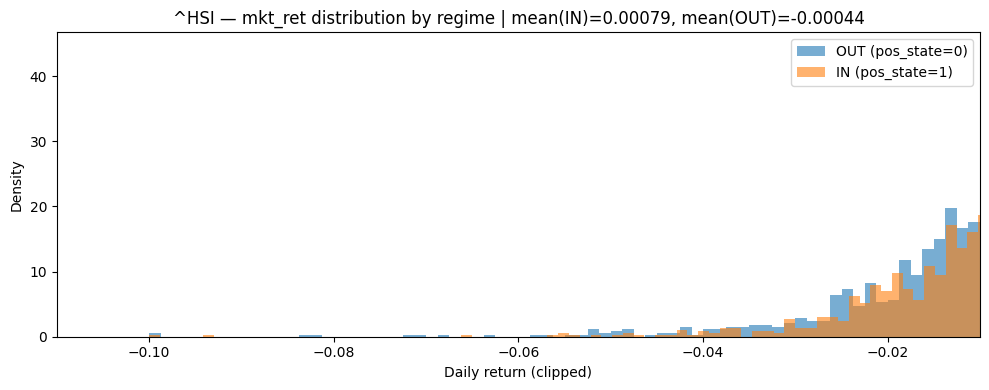

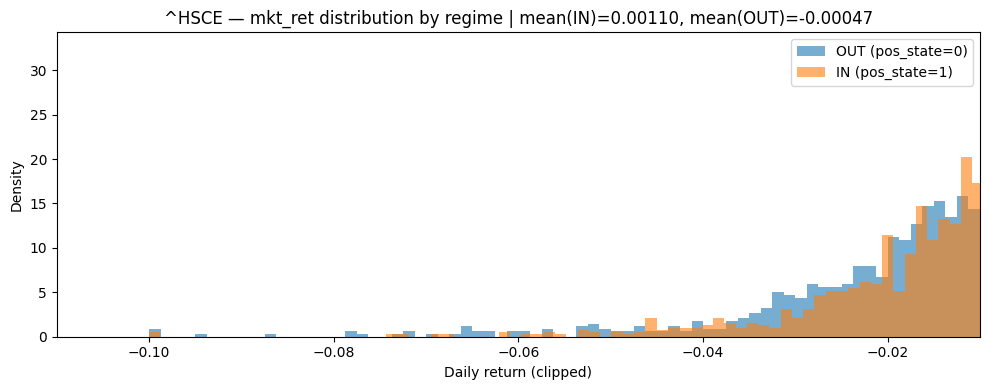

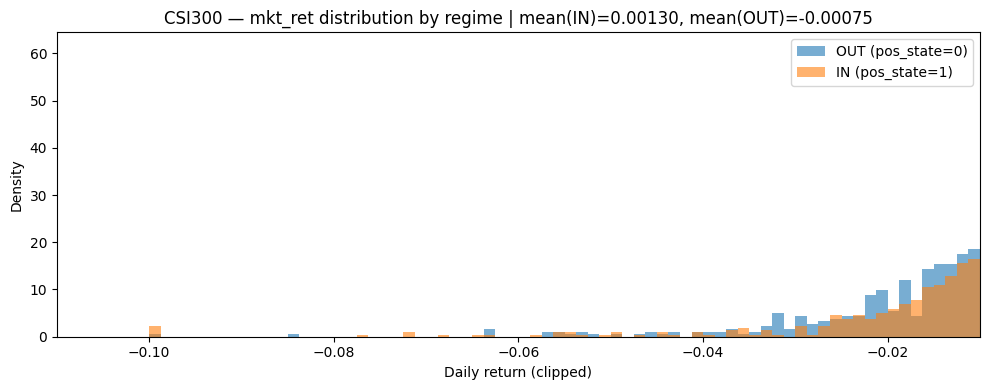

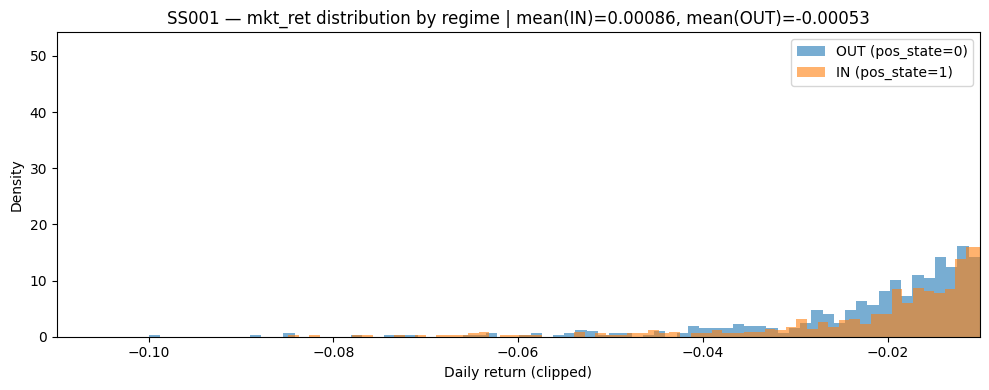

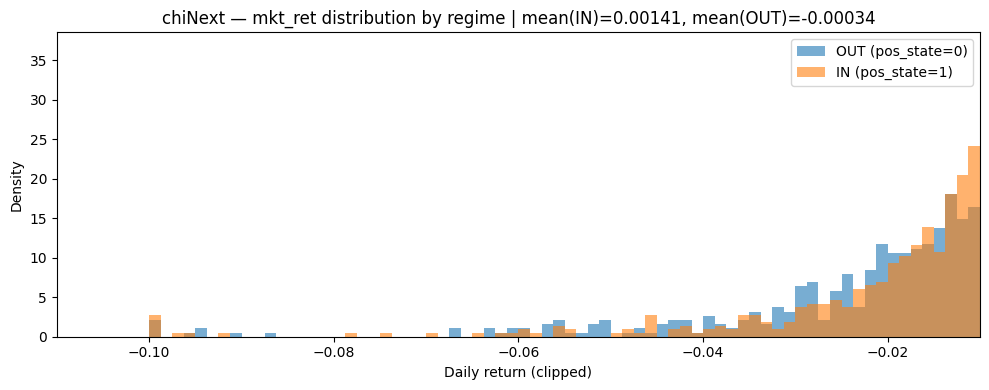

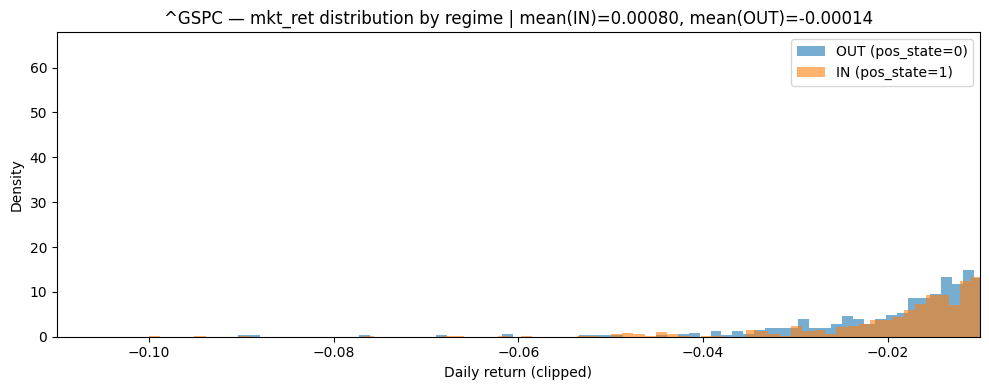

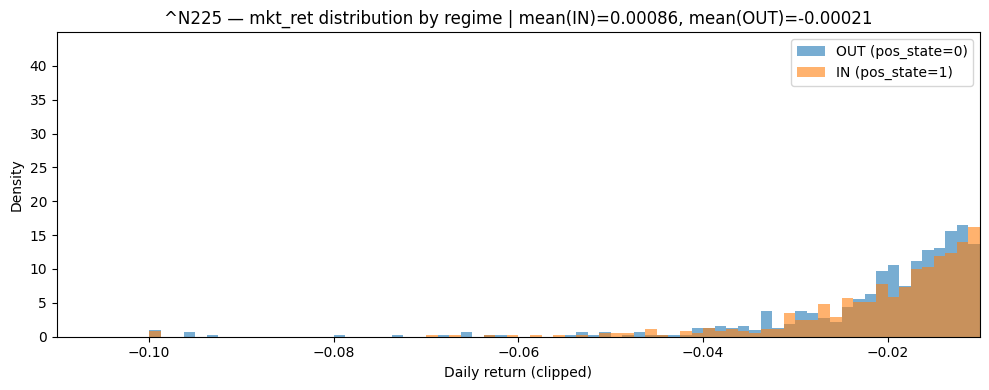

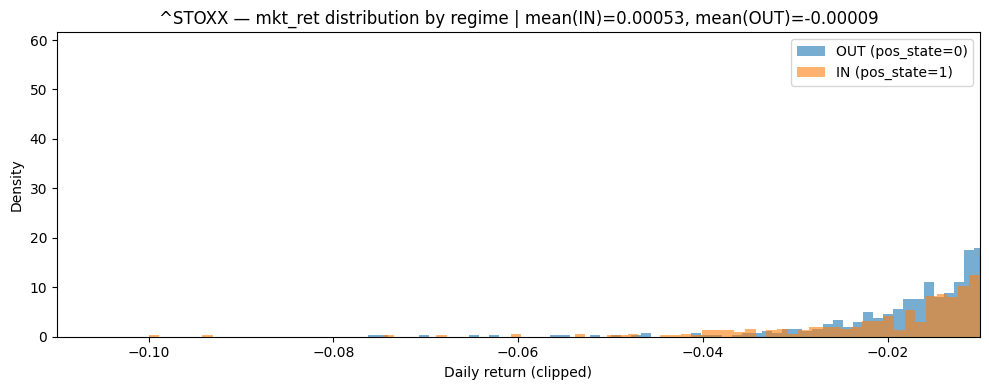

In [232]:
def _get_bt_df(details: dict, market: str, mode: str = "long_only") -> pd.DataFrame:
    return details[(market, mode)]["df"].copy()

def _get_yearly_tbl(details: dict, market: str, mode: str = "long_only") -> pd.DataFrame:
    """
    Returns DataFrame indexed by year, with columns: strategy, benchmark, excess
    """
    yt = details[(market, mode)]["stats"]["yearly_returns"].copy()
    yt.index = yt.index.astype(int)  # ensure years are int
    return yt.sort_index()

def plot_state_return_hist(
    details: dict,
    markets: list[str],
    *,
    mode: str = "long_only",
    ret_col: str = "mkt_ret",        # "mkt_ret" or "strategy_ret"
    state_col: str = "regime",    # use pos_state (recommended) or regime
    bins: int = 160,
    clip: float | None = 0.10,       # clip extreme tails for readability (e.g. 10% daily)
):
    """
    One figure per market (no subplots).
    Plots return distribution conditioned on state (IN=1 vs OUT=0).
    """
    for m in markets:
        df = _get_bt_df(details, m, mode=mode).dropna(subset=[ret_col, state_col]).copy()
        df[state_col] = df[state_col].astype(int)

        r_in = df.loc[df[state_col] == 1, ret_col]
        r_out = df.loc[df[state_col] == 0, ret_col]

        if clip is not None:
            r_in = r_in.clip(-clip, clip)
            r_out = r_out.clip(-clip, clip)

        plt.figure(figsize=(10, 4))
        plt.hist(r_out.values, bins=bins, density=True, alpha=0.6, label="OUT (pos_state=0)")
        plt.hist(r_in.values,  bins=bins, density=True, alpha=0.6, label="IN (pos_state=1)")
        plt.axvline(0.0, linewidth=1, linestyle="--", color="gray")
        plt.xlim(right=-0.01)

        # annotate means
        mu_in = float(r_in.mean()) if len(r_in) else np.nan
        mu_out = float(r_out.mean()) if len(r_out) else np.nan
        plt.title(f"{m} — {ret_col} distribution by {state_col} | mean(IN)={mu_in:.5f}, mean(OUT)={mu_out:.5f}")
        plt.xlabel("Daily return (clipped)" if clip is not None else "Daily return")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

def compute_worst_day_capture(
    details: dict,
    markets: list[str],
    *,
    mode: str = "long_only",
    q_list: tuple[float, ...] = (0.01, 0.05),
    ret_bh_col: str = "mkt_ret",
    ret_strat_col: str = "strategy_ret",
    pos_col: str = "position",
) -> pd.DataFrame:
    rows = []
    for m in markets:
        df = _get_bt_df(details, m, mode=mode).dropna(subset=[ret_bh_col, ret_strat_col, pos_col]).copy()
        r_bh = df[ret_bh_col]
        r_s  = df[ret_strat_col]
        abs_pos = df[pos_col].abs()

        for q in q_list:
            thr = float(r_bh.quantile(q))
            worst_mask = (r_bh <= thr)

            avg_bh = float(r_bh[worst_mask].mean())
            avg_s  = float(r_s[worst_mask].mean())

            loss_avoided = avg_s - avg_bh         # should be positive if strategy loses less
            capture_ratio = (avg_s / avg_bh) if avg_bh != 0 else np.nan  # closer to 0 is better if avg_bh<0

            rows.append({
                "market": m,
                "q": q,
                "thr_worst": thr,
                "n_total": int(len(df)),
                "n_worst": int(worst_mask.sum()),
                "avg_bh_ret_worst": avg_bh,
                "avg_strat_ret_worst": avg_s,
                "loss_avoided": loss_avoided,
                "capture_ratio": capture_ratio,
                "avg_abs_position_on_worst": float(abs_pos[worst_mask].mean()),
            })

    return pd.DataFrame(rows).sort_values(["q", "market"]).reset_index(drop=True)


mkts = ["^HSI", "^HSCE", "SS001", "CSI300", '^N225']
cap = compute_worst_day_capture(details, mkts, q_list=(0.01, 0.05))

plot_state_return_hist(details, markets)


## Parameter Tuning

  period market  z_window  upper  lower   ann_ret   ann_vol    sharpe  \
0   full  SS001        60   0.25  -0.25  0.034076  0.174678  0.195080   
1   full  SS001        70   0.25  -0.25  0.036560  0.175709  0.208071   
2   full  SS001        80   0.25  -0.25  0.071147  0.176051  0.404126   
3   full  SS001        90   0.25  -0.25  0.077490  0.172264  0.449831   
4   full  SS001       100   0.25  -0.25  0.085394  0.171310  0.498478   
5   full  SS001       110   0.25  -0.25  0.089603  0.170256  0.526285   
6   full  SS001       120   0.25  -0.25  0.102225  0.172865  0.591360   
7   full  SS001       130   0.25  -0.25  0.099008  0.172413  0.574251   
8   full  SS001       140   0.25  -0.25  0.097789  0.172489  0.566927   
9   full  SS001       150   0.25  -0.25  0.093230  0.168830  0.552213   

   bh_sharpe  sharpe_minus_bh    max_dd  pct_in_market  avg_abs_exposure  \
0   0.238167        -0.043087 -0.606699       0.503412          0.503412   
1   0.239149        -0.031078 -0.606970     

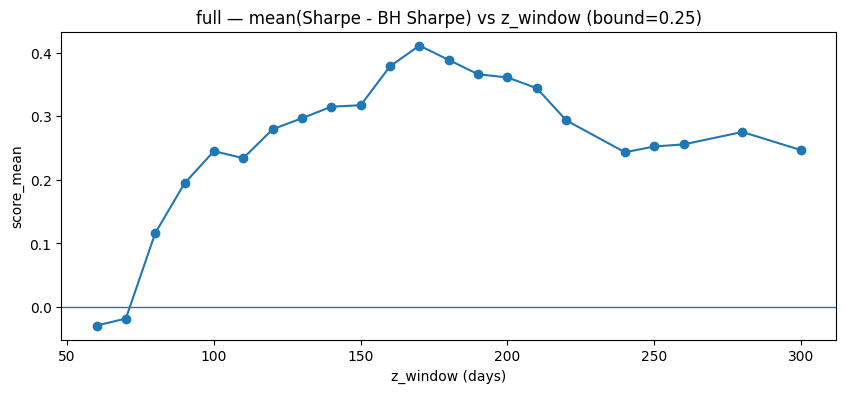

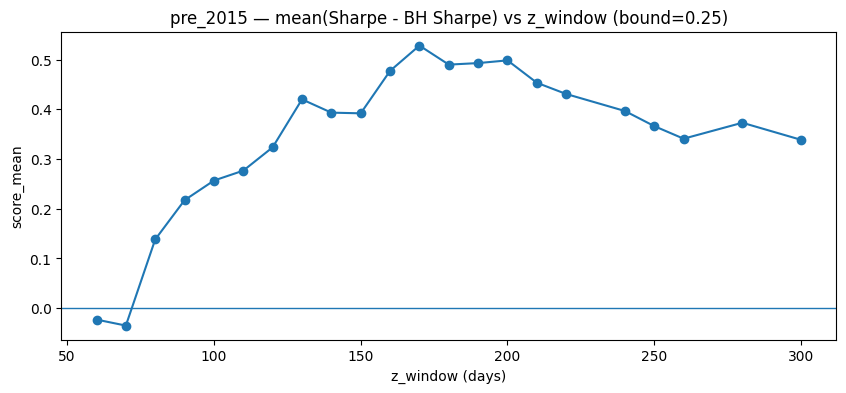

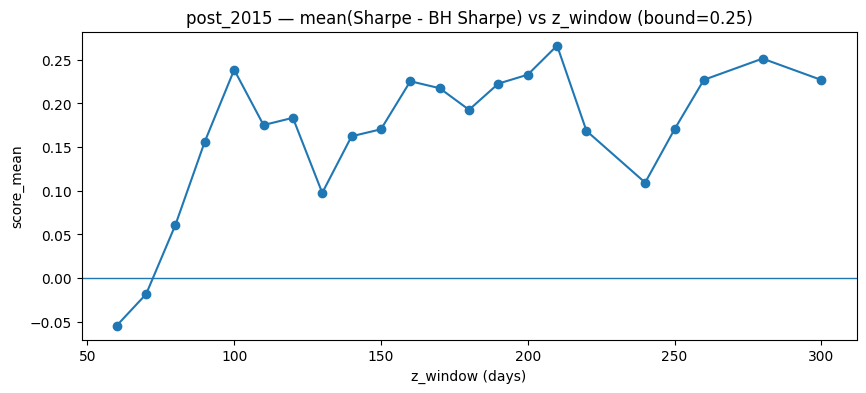

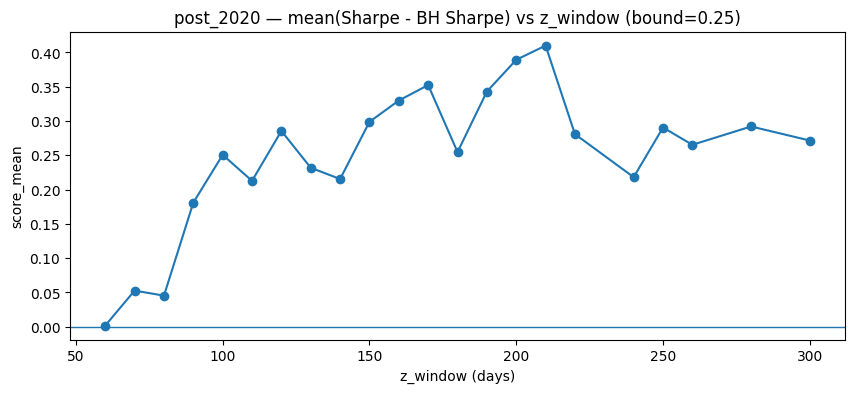

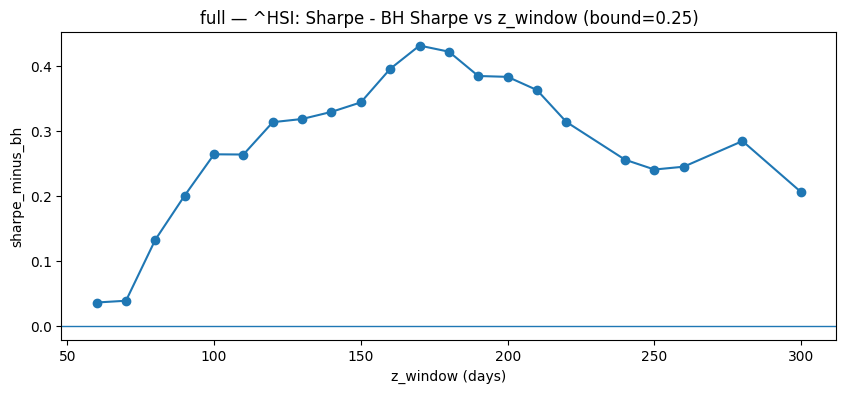

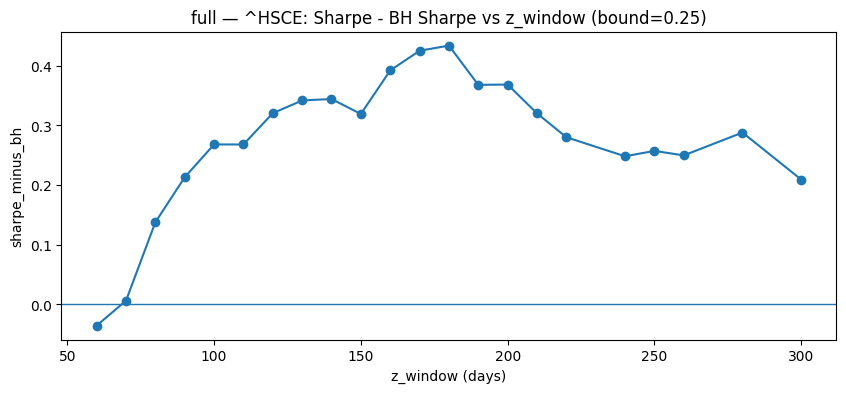

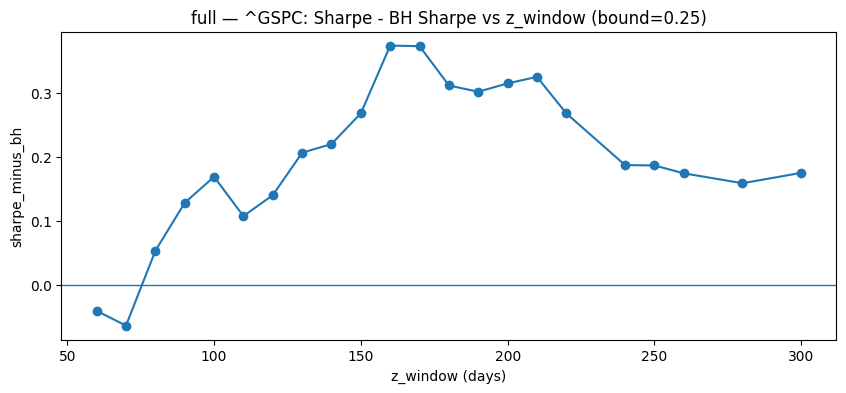

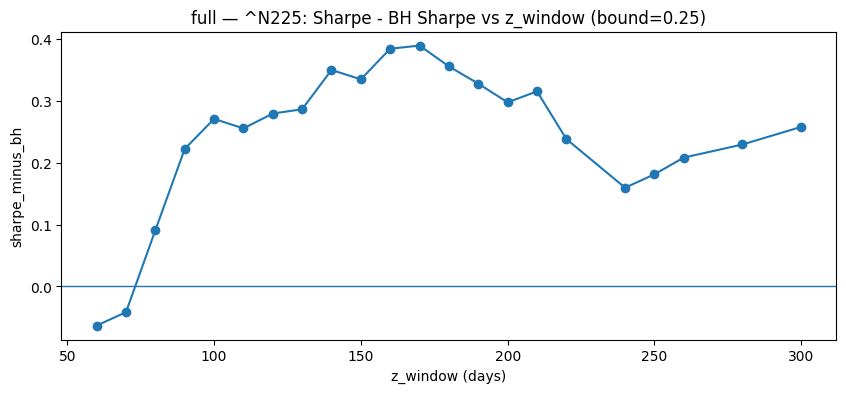

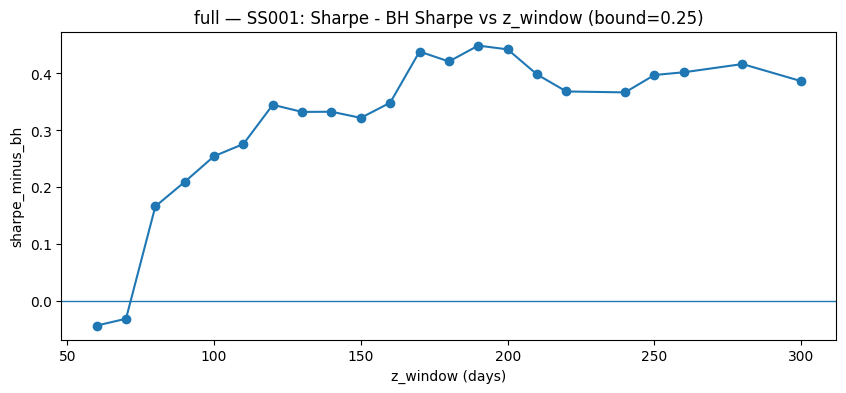


=== Top z_window within 110–170 band (mean sharpe_minus_bh) ===
       period  z_window     score  n
6        full       170  0.411111  5
5        full       160  0.378559  5
4        full       150  0.317321  5
3        full       140  0.315021  5
2        full       130  0.296879  5
12  post_2015       160  0.225480  5
13  post_2015       170  0.217489  5
8   post_2015       120  0.183571  5
7   post_2015       110  0.175262  5
11  post_2015       150  0.170421  5
20  post_2020       170  0.352321  5
19  post_2020       160  0.329810  5
18  post_2020       150  0.298692  5
15  post_2020       120  0.285433  5
16  post_2020       130  0.231706  5
27   pre_2015       170  0.528140  5
26   pre_2015       160  0.477206  5
23   pre_2015       130  0.419890  5
24   pre_2015       140  0.393140  5
25   pre_2015       150  0.391766  5


In [31]:
# ============================================================
# Sweep z_window (and optionally bounds) to test "120–150 best"
# Uses your EXISTING functions:
#   - run_co_regime_backtest(...)
#   - perf_stats(...) already used inside
# ============================================================

def _slice_period(s: pd.Series, start: str | None, end: str | None) -> pd.Series:
    s = s.dropna()
    if start is not None:
        s = s.loc[s.index >= pd.to_datetime(start)]
    if end is not None:
        s = s.loc[s.index <= pd.to_datetime(end)]
    return s

def sweep_z_windows(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    windows: list[int] = None,
    hysteresis: bool = True,
    bound: float = 0.25,
    mode: str = "long_only",
    vol_target: float | None = None,
    trend_filter: int | None = None,
    # sub-samples
    subperiods: dict = None,
) -> pd.DataFrame:
    """
    Returns a long-form table with:
      period, market, z_window, upper, lower,
      sharpe, bh_sharpe, sharpe_minus_bh, max_dd, pct_in_market,
      ann_ret, ann_vol
    """

    if windows is None:
        # dense around 120–150, plus a broader range
        windows = sorted(set(
            list(range(60, 201, 10)) +   # 60..200 step 10
            list(range(200, 321, 20)) +  # 200..320 step 20
            [120, 126, 132, 138, 144, 150, 156]
        ))

    if subperiods is None:
        subperiods = {
            "full": (None, None),
            "pre_2015": (None, "2014-12-31"),
            "post_2015": ("2015-01-01", None),
            "post_2020": ("2020-01-01", None),
        }

    rows = []
    upper = bound
    lower = -bound

    for period_name, (p_start, p_end) in subperiods.items():
        for w in windows:
            for mkt_name, mkt_price in markets.items():
                # slice each series to the subperiod to make it explicit
                mkt_p = _slice_period(mkt_price, p_start, p_end)
                cu = _slice_period(copper, p_start, p_end)
                oi = _slice_period(oil, p_start, p_end)

                # skip if insufficient data (rolling z needs >= w)
                if len(mkt_p) < (w + 5) or len(cu) < (w + 5) or len(oi) < (w + 5):
                    continue

                out = run_co_regime_backtest(
                    market_price=mkt_p,
                    copper=cu,
                    oil=oi,
                    market_name=mkt_name,
                    z_window=w,
                    hysteresis=hysteresis,
                    upper=upper,
                    lower=lower,
                    mode=mode,
                    vol_target=vol_target,
                    trend_filter=trend_filter,
                    plot=False,
                )

                s = out["stats"]
                rows.append({
                    "period": period_name,
                    "market": mkt_name,
                    "z_window": w,
                    "upper": upper,
                    "lower": lower,
                    "ann_ret": s["strategy"]["ann_ret"],
                    "ann_vol": s["strategy"]["ann_vol"],
                    "sharpe": s["strategy"]["sharpe"],
                    "bh_sharpe": s["buy_hold"]["sharpe"],
                    "sharpe_minus_bh": s["strategy"]["sharpe"] - s["buy_hold"]["sharpe"],
                    "max_dd": s["strategy"]["max_dd"],
                    "pct_in_market": s["pct_in_market"],
                    "avg_abs_exposure": s["avg_exposure"],
                    "n_obs": s["strategy"]["n"],
                })

    res = pd.DataFrame(rows).sort_values(["period", "market", "z_window"]).reset_index(drop=True)
    return res


def summarize_best_windows(
    res: pd.DataFrame,
    *,
    by: str = "period",
    score_col: str = "sharpe_minus_bh",
    min_markets: int = 3,
) -> pd.DataFrame:
    """
    Aggregate across markets to pick a 'best' z_window per period.
    Default score: sharpe_minus_bh (strategy Sharpe vs its own buy&hold Sharpe).
    """
    g = (
        res.groupby([by, "z_window"])
          .agg(
              n_markets=("market", "nunique"),
              score_mean=(score_col, "mean"),
              score_median=(score_col, "median"),
              sharpe_mean=("sharpe", "mean"),
              max_dd_mean=("max_dd", "mean"),
              pct_in_mkt_mean=("pct_in_market", "mean"),
          )
          .reset_index()
    )
    g = g[g["n_markets"] >= min_markets].copy()
    g["rank"] = g.groupby(by)["score_mean"].rank(ascending=False, method="first")
    best = g[g["rank"] == 1].sort_values(by).reset_index(drop=True)
    return best, g


def plot_window_curve(
    agg: pd.DataFrame,
    *,
    period: str = "full",
    y: str = "score_mean",
    title: str | None = None,
):
    d = agg[agg["period"] == period].sort_values("z_window").copy()
    plt.figure(figsize=(10, 4))
    plt.plot(d["z_window"], d[y], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(title or f"{period} — {y} vs z_window (avg across markets)")
    plt.xlabel("z_window (days)")
    plt.ylabel(y)
    plt.show()


# ============================================================
# Example: run the sweep
# ============================================================

# You already have:
# markets = {...}
# df["copper"], df["oil"]

windows = list(range(60, 221, 10)) + [240, 250, 260, 280, 300]
bound = 0.25

res = sweep_z_windows(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    windows=windows,
    hysteresis=True,
    bound=bound,
    mode="long_only",
    vol_target=None,      # keep off to isolate z_window effect
    trend_filter=None,    # keep off first; add later for stress-protection tests
)

# 1) Inspect raw results quickly
print(res.head(10))
print("\nCounts by period:", res.groupby("period")["market"].nunique().to_dict())

# 2) Pick best window per period (avg Sharpe improvement vs its own BH)
best, agg = summarize_best_windows(
    res,
    by="period",
    score_col="sharpe_minus_bh",
    min_markets=3,
)

print("\n=== Best z_window per period (by mean sharpe_minus_bh) ===")
print(best[["period","z_window","n_markets","score_mean","score_median","sharpe_mean","max_dd_mean","pct_in_mkt_mean"]])

# 3) Plot the curve (you can do for each period)
for p in ["full", "pre_2015", "post_2015", "post_2020"]:
    plot_window_curve(
        agg=agg,
        period=p,
        y="score_mean",
        title=f"{p} — mean(Sharpe - BH Sharpe) vs z_window (bound={bound})"
    )

# 4) OPTIONAL: per-market curve (useful to see if 120–150 is consistent)
def plot_per_market_curve(res: pd.DataFrame, period: str, market: str):
    d = res[(res["period"] == period) & (res["market"] == market)].sort_values("z_window")
    plt.figure(figsize=(10, 4))
    plt.plot(d["z_window"], d["sharpe_minus_bh"], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(f"{period} — {market}: Sharpe - BH Sharpe vs z_window (bound={bound})")
    plt.xlabel("z_window (days)")
    plt.ylabel("sharpe_minus_bh")
    plt.show()

for m in markets.keys():
    plot_per_market_curve(res, period="full", market=m)

# 5) If you want to explicitly test the "120–150 band", filter:
band = res[(res["z_window"] >= 110) & (res["z_window"] <= 170)]
band_rank = (
    band.groupby(["period","z_window"])
        .agg(score=("sharpe_minus_bh","mean"), n=("market","nunique"))
        .reset_index()
        .sort_values(["period","score"], ascending=[True, False])
)
print("\n=== Top z_window within 110–170 band (mean sharpe_minus_bh) ===")
print(band_rank.groupby("period").head(5))


  period market  z_window  bound  upper  lower   ann_ret   ann_vol    sharpe  \
0   full  SS001        60   0.00   0.00  -0.00  0.047432  0.173785  0.272933   
1   full  SS001        60   0.10   0.10  -0.10  0.039821  0.174928  0.227640   
2   full  SS001        60   0.15   0.15  -0.15  0.038902  0.174500  0.222933   
3   full  SS001        60   0.20   0.20  -0.20  0.031806  0.174671  0.182094   
4   full  SS001        60   0.25   0.25  -0.25  0.034076  0.174678  0.195080   
5   full  SS001        60   0.30   0.30  -0.30  0.033085  0.174786  0.189290   
6   full  SS001        60   0.35   0.35  -0.35  0.030799  0.176458  0.174540   
7   full  SS001        60   0.40   0.40  -0.40  0.027060  0.176368  0.153432   
8   full  SS001        60   0.50   0.50  -0.50  0.024451  0.177418  0.137819   
9   full  SS001        70   0.00   0.00  -0.00  0.045154  0.177477  0.254421   

   bh_sharpe  sharpe_minus_bh    max_dd  pct_in_market  avg_abs_exposure  \
0   0.238167         0.034766 -0.524529    

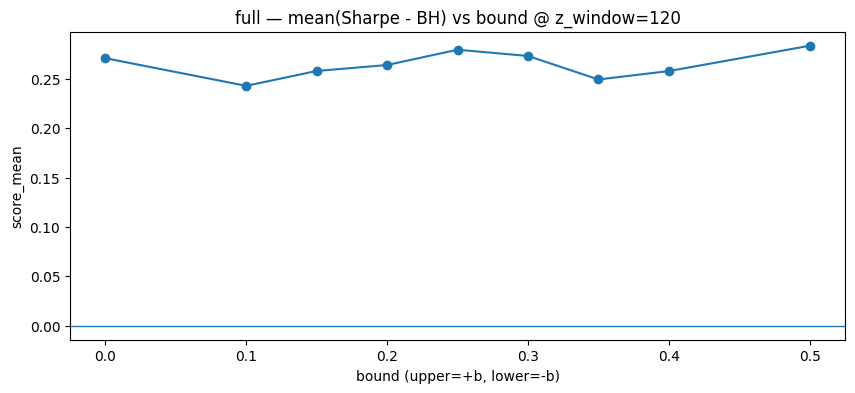

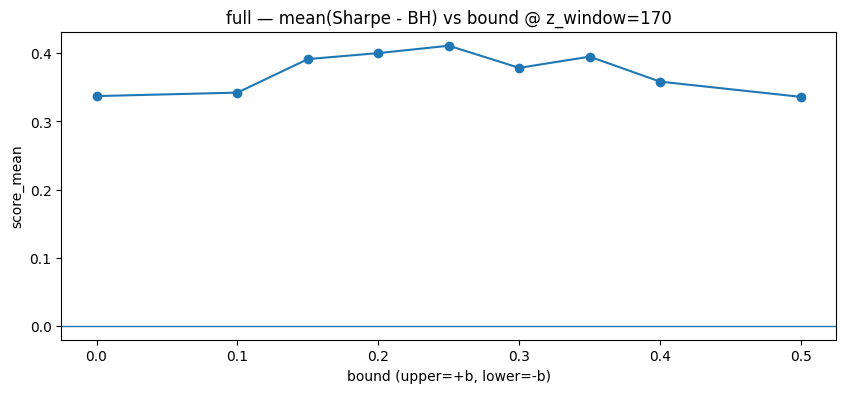

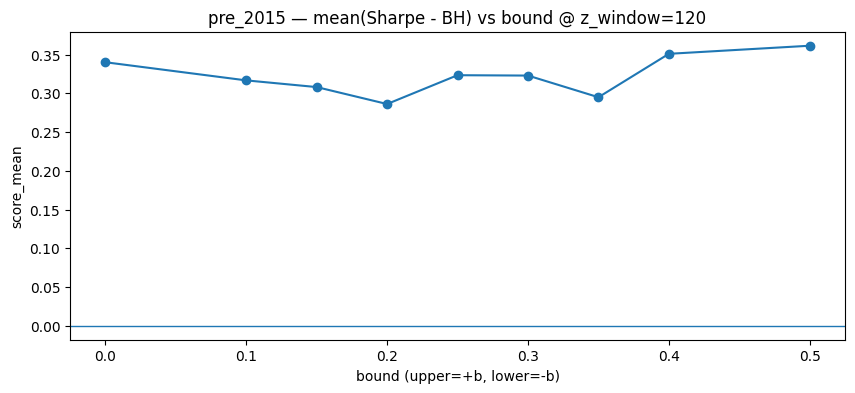

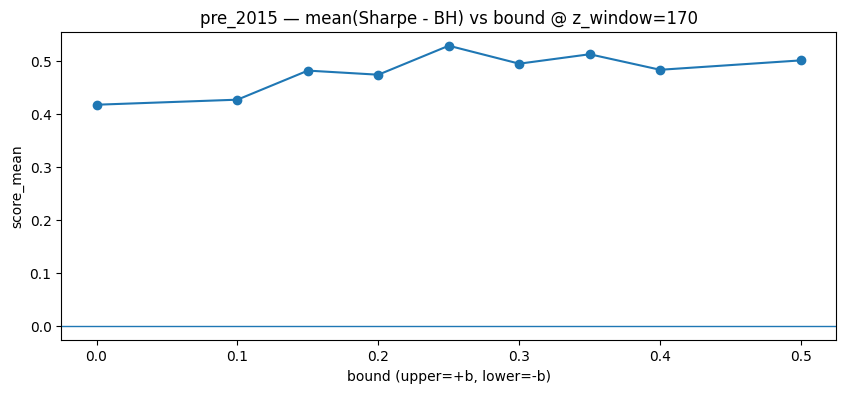

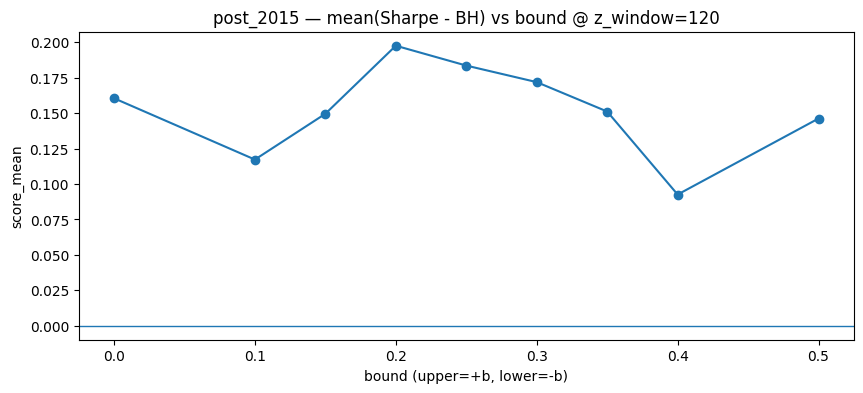

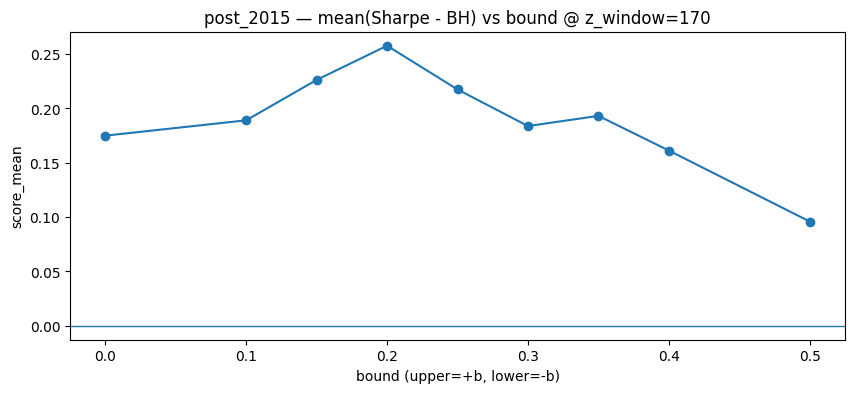

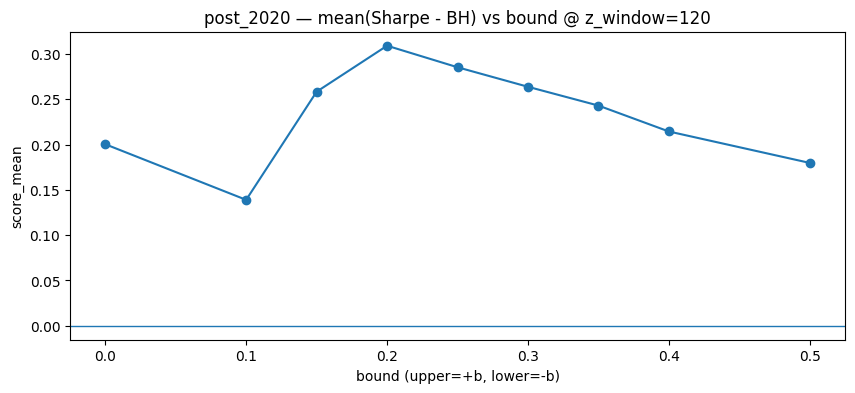

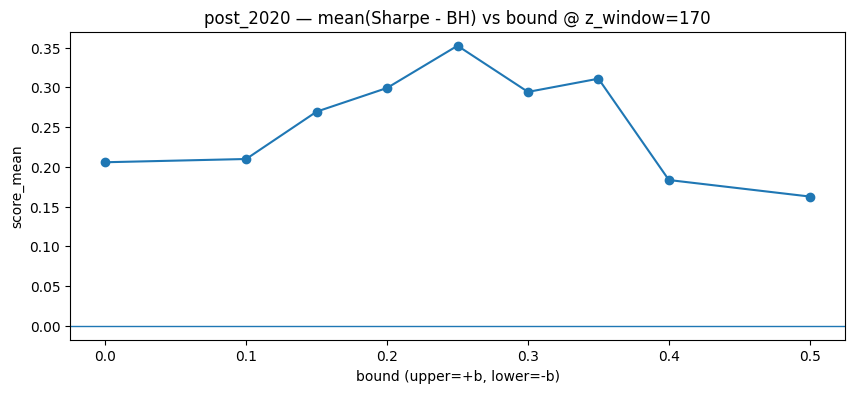

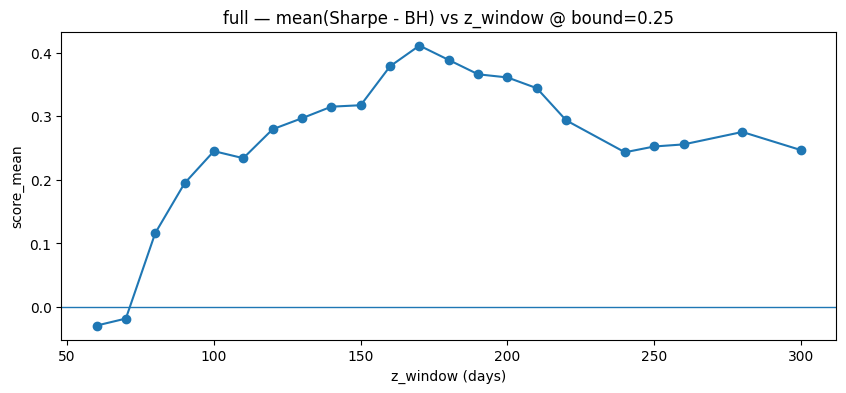

In [35]:
# ============================================================
# Sweep z_window AND bound
# ============================================================

def sweep_z_windows_and_bounds(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    windows: list[int] = None,
    bounds: list[float] = None,
    hysteresis: bool = True,
    mode: str = "long_only",
    vol_target: float | None = None,
    trend_filter: int | None = None,
    # sub-samples
    subperiods: dict = None,
    min_len_buffer: int = 5,
) -> pd.DataFrame:
    """
    Returns long-form table with:
      period, market, z_window, bound, upper, lower,
      sharpe, bh_sharpe, sharpe_minus_bh, max_dd, pct_in_market,
      ann_ret, ann_vol, avg_abs_exposure, n_obs
    """

    if windows is None:
        windows = list(range(60, 221, 10)) + [240, 250, 260, 280, 300]

    if bounds is None:
        # Typical hysteresis bands to test (tight -> wide)
        # Keep symmetric for now.
        bounds = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60, 0.75, 1.00]

    if subperiods is None:
        subperiods = {
            "full": (None, None),
            "pre_2015": (None, "2014-12-31"),
            "post_2015": ("2015-01-01", None),
            "post_2020": ("2020-01-01", None),
        }

    rows = []

    for period_name, (p_start, p_end) in subperiods.items():
        for w in windows:
            for b in bounds:
                upper = float(b)
                lower = -float(b)

                for mkt_name, mkt_price in markets.items():
                    # slice to subperiod
                    mkt_p = _slice_period(mkt_price, p_start, p_end)
                    cu = _slice_period(copper, p_start, p_end)
                    oi = _slice_period(oil, p_start, p_end)

                    # need >= w for rolling z-score; add buffer for shift/pct_change
                    if (
                        len(mkt_p) < (w + min_len_buffer)
                        or len(cu) < (w + min_len_buffer)
                        or len(oi) < (w + min_len_buffer)
                    ):
                        continue

                    out = run_co_regime_backtest(
                        market_price=mkt_p,
                        copper=cu,
                        oil=oi,
                        market_name=mkt_name,
                        z_window=w,
                        hysteresis=hysteresis,
                        upper=upper,
                        lower=lower,
                        mode=mode,
                        vol_target=vol_target,
                        trend_filter=trend_filter,
                        plot=False,
                    )

                    s = out["stats"]
                    rows.append({
                        "period": period_name,
                        "market": mkt_name,
                        "z_window": int(w),
                        "bound": float(b),
                        "upper": upper,
                        "lower": lower,

                        "ann_ret": s["strategy"]["ann_ret"],
                        "ann_vol": s["strategy"]["ann_vol"],
                        "sharpe": s["strategy"]["sharpe"],
                        "bh_sharpe": s["buy_hold"]["sharpe"],
                        "sharpe_minus_bh": s["strategy"]["sharpe"] - s["buy_hold"]["sharpe"],
                        "max_dd": s["strategy"]["max_dd"],
                        "pct_in_market": s["pct_in_market"],
                        "avg_abs_exposure": s["avg_exposure"],
                        "n_obs": s["strategy"]["n"],
                    })

    res = (
        pd.DataFrame(rows)
          .sort_values(["period", "market", "z_window", "bound"])
          .reset_index(drop=True)
    )
    return res


# ============================================================
# Summaries / ranking
# ============================================================

def summarize_best_grid(
    res: pd.DataFrame,
    *,
    by: str = "period",
    score_col: str = "sharpe_minus_bh",
    min_markets: int = 3,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Aggregate across markets to pick best (z_window, bound) per 'by' group.
    """
    g = (
        res.groupby([by, "z_window", "bound"])
           .agg(
               n_markets=("market", "nunique"),
               score_mean=(score_col, "mean"),
               score_median=(score_col, "median"),
               sharpe_mean=("sharpe", "mean"),
               max_dd_mean=("max_dd", "mean"),
               pct_in_mkt_mean=("pct_in_market", "mean"),
           )
           .reset_index()
    )
    g = g[g["n_markets"] >= min_markets].copy()
    g["rank"] = g.groupby(by)["score_mean"].rank(ascending=False, method="first")
    best = g[g["rank"] == 1].sort_values(by).reset_index(drop=True)
    return best, g


def summarize_best_grid_per_market(
    res: pd.DataFrame,
    *,
    score_col: str = "sharpe_minus_bh",
) -> pd.DataFrame:
    """
    Best (z_window, bound) per (period, market).
    """
    d = res.copy()
    d["rank"] = (
        d.groupby(["period", "market"])[score_col]
         .rank(ascending=False, method="first")
    )
    best = d[d["rank"] == 1].sort_values(["period", "market"]).reset_index(drop=True)
    return best


# ============================================================
# Quick plots (optional, no subplots)
# ============================================================

def plot_bound_curve_at_window(
    agg: pd.DataFrame,
    *,
    period: str,
    z_window: int,
    y: str = "score_mean",
    title: str | None = None,
):
    d = agg[(agg["period"] == period) & (agg["z_window"] == z_window)].sort_values("bound")
    plt.figure(figsize=(10, 4))
    plt.plot(d["bound"], d[y], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(title or f"{period} — {y} vs bound (z_window={z_window})")
    plt.xlabel("bound (upper=+b, lower=-b)")
    plt.ylabel(y)
    plt.show()


def plot_window_curve_at_bound(
    agg: pd.DataFrame,
    *,
    period: str,
    bound: float,
    y: str = "score_mean",
    title: str | None = None,
):
    d = agg[(agg["period"] == period) & (agg["bound"] == bound)].sort_values("z_window")
    plt.figure(figsize=(10, 4))
    plt.plot(d["z_window"], d[y], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(title or f"{period} — {y} vs z_window (bound={bound})")
    plt.xlabel("z_window (days)")
    plt.ylabel(y)
    plt.show()


# ============================================================
# Example usage
# ============================================================

windows = list(range(60, 221, 10)) + [240, 250, 260, 280, 300]
bounds  = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]

res2d = sweep_z_windows_and_bounds(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    windows=windows,
    bounds=bounds,
    hysteresis=True,
    mode="long_only",
    vol_target=None,
    trend_filter=None,
)

print(res2d.head(10))
print("\nCounts by period (markets):", res2d.groupby("period")["market"].nunique().to_dict())

best_grid, agg_grid = summarize_best_grid(
    res2d,
    by="period",
    score_col="sharpe_minus_bh",
    min_markets=3,
)

print("\n=== Best (z_window, bound) per period (mean sharpe_minus_bh across markets) ===")
print(best_grid[["period","z_window","bound","n_markets","score_mean","score_median","sharpe_mean","max_dd_mean","pct_in_mkt_mean"]])

best_pm = summarize_best_grid_per_market(res2d, score_col="sharpe_minus_bh")
print("\n=== Best (z_window, bound) per (period, market) ===")
print(best_pm[["period","market","z_window","bound","sharpe","bh_sharpe","sharpe_minus_bh","max_dd","pct_in_market"]])

# Optional: inspect curves
for p in ["full", "pre_2015", "post_2015", "post_2020"]:
    # pick a couple windows you care about
    plot_bound_curve_at_window(agg_grid, period=p, z_window=120, y="score_mean",
                               title=f"{p} — mean(Sharpe - BH) vs bound @ z_window=120")
    plot_bound_curve_at_window(agg_grid, period=p, z_window=170, y="score_mean",
                               title=f"{p} — mean(Sharpe - BH) vs bound @ z_window=170")

# Or fix bound and look at windows
plot_window_curve_at_bound(agg_grid, period="full", bound=0.25, y="score_mean",
                           title="full — mean(Sharpe - BH) vs z_window @ bound=0.25")

In [38]:
res[(res.period=="full") & (res.market=="SS001")]

,period,market,z_window,upper,lower,ann_ret,ann_vol,sharpe,bh_sharpe,sharpe_minus_bh,max_dd,pct_in_market,avg_abs_exposure,n_obs
0,full,SS001,60,0.25,-0.25,0.034076,0.174678,0.195080,0.238167,-0.043087,-0.606699,0.503412,0.503412,5714
1,full,SS001,70,0.25,-0.25,0.036560,0.175709,0.208071,0.239149,-0.031078,-0.606970,0.506398,0.506398,5704
2,full,SS001,80,0.25,-0.25,0.071147,0.176051,0.404126,0.237813,0.166313,-0.457918,0.514838,0.514838,5694
3,full,SS001,90,0.25,-0.25,0.077490,0.172264,0.449831,0.240487,0.209344,-0.447176,0.525242,0.525242,5684
4,full,SS001,100,0.25,-0.25,0.085394,0.171310,0.498478,0.244014,0.254464,-0.415822,0.527900,0.527900,5680
5,full,SS001,110,0.25,-0.25,0.089603,0.170256,0.526285,0.250384,0.275901,-0.401702,0.532440,0.532440,5671
6,full,SS001,120,0.25,-0.25,0.102225,0.172865,0.591360,0.246631,0.344728,-0.401702,0.533557,0.533557,5661
7,full,SS001,130,0.25,-0.25,0.099008,0.172413,0.574251,0.242026,0.332225,-0.401149,0.531670,0.531670,5651
8,full,SS001,140,0.25,-0.25,0.097789,0.172489,0.566927,0.234365,0.332563,-0.436865,0.531195,0.531195,5641
9,full,SS001,150,0.25,-0.25,0.093230,0.168830,0.552213,0.230447,0.321766,-0.426431,0.528232,0.528232,5631


## OOS

In [36]:
import numpy as np
import pandas as pd

# ----------------------------
# Utilities
# ----------------------------
def _to_dt(x):
    return pd.to_datetime(x) if x is not None else None

def _slice_until(s: pd.Series, end_dt: pd.Timestamp) -> pd.Series:
    s = s.dropna()
    return s.loc[s.index <= end_dt]

def _ann_sharpe(ret: pd.Series, ann_factor=252):
    ret = ret.dropna()
    if len(ret) < 5:
        return np.nan
    mu = ret.mean() * ann_factor
    sd = ret.std() * np.sqrt(ann_factor)
    return mu / sd if sd > 0 else np.nan

def _weighted_mean(values, weights):
    vals = np.array(values, dtype=float)
    wts = np.array(weights, dtype=float)
    m = np.isfinite(vals) & np.isfinite(wts) & (wts > 0)
    if m.sum() == 0:
        return np.nan
    return float(np.sum(vals[m] * wts[m]) / np.sum(wts[m]))

# ----------------------------
# OOS Tuner
# ----------------------------
def tune_params_oos(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    *,
    train_start: str = "2002-01-01",
    min_train_years: int = 5,
    retrain_every: int = 21,          # monthly ~21 trading days
    mode: str = "long_only",
    vol_target: float | None = None,
    trend_filter: int | None = None,
    hysteresis: bool = True,
    # grid
    z_windows: list[int] = None,
    bounds: list[float] = None,
    # objective
    market_weights: dict | None = None,
    score_col: str = "sharpe_minus_bh",
    # constraints to avoid degenerate solutions
    pct_band: tuple[float, float] = (0.35, 0.75),
    max_dd_floor: float = -0.60,
):
    """
    Walk-forward tuning:
    At each decision date t (every retrain_every days), choose (z_window, bound)
    using only data <= t. Store chosen params.

    Returns: decisions_df (one row per decision date).
    """
    if z_windows is None:
        z_windows = list(range(60, 221, 10)) + [240, 250, 260, 280, 300]
    if bounds is None:
        bounds = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]

    # default weights (your stated importance)
    if market_weights is None:
        market_weights = {
            "SS001": 3.0,
            "^HSI": 2.0,
            "^HSCE": 2.0,
            "^N225": 1.0,
            "^GSPC": 0.5,
        }

    # build a common calendar to pick retrain dates:
    # use intersection of all series to avoid missingness surprises
    idx = None
    for m, s in markets.items():
        ss = s.dropna()
        idx = ss.index if idx is None else idx.intersection(ss.index)
    idx = idx.intersection(copper.dropna().index).intersection(oil.dropna().index)
    idx = idx.sort_values()

    train_start_dt = _to_dt(train_start)
    idx = idx[idx >= train_start_dt]
    if len(idx) == 0:
        raise ValueError("No overlapping dates after train_start")

    # decision dates every retrain_every trading days
    decision_dates = idx[::retrain_every]

    rows = []
    for t in decision_dates:
        # ensure minimum training history
        if (t - train_start_dt).days < int(min_train_years * 365.25):
            continue

        # evaluate each candidate on TRAIN data ending at t
        best = None
        best_score = -np.inf

        for w in z_windows:
            for b in bounds:
                upper, lower = b, -b

                per_mkt_scores = []
                per_mkt_wts = []

                feasible_markets = 0

                for mkt_name, mkt_price in markets.items():
                    wt = market_weights.get(mkt_name, 0.0)
                    if wt <= 0:
                        continue

                    mkt_train = _slice_until(mkt_price, t)
                    cu_train = _slice_until(copper, t)
                    oi_train = _slice_until(oil, t)

                    # require enough data for rolling window
                    if len(mkt_train) < w + 5 or len(cu_train) < w + 5 or len(oi_train) < w + 5:
                        continue

                    out = run_co_regime_backtest(
                        market_price=mkt_train,
                        copper=cu_train,
                        oil=oi_train,
                        market_name=mkt_name,
                        z_window=w,
                        hysteresis=hysteresis,
                        upper=upper,
                        lower=lower,
                        mode=mode,
                        vol_target=vol_target,
                        trend_filter=trend_filter,
                        plot=False,
                    )

                    s = out["stats"]
                    pct = s["pct_in_market"]
                    mdd = s["strategy"]["max_dd"]

                    # constraints
                    if not (pct_band[0] <= pct <= pct_band[1]):
                        continue
                    if mdd < max_dd_floor:
                        continue

                    score = s["strategy"]["sharpe"] - s["buy_hold"]["sharpe"]
                    if np.isfinite(score):
                        per_mkt_scores.append(score)
                        per_mkt_wts.append(wt)
                        feasible_markets += 1

                # need at least China+HK present in scoring (to reflect your focus)
                # minimally require SS001 and one of HK series to be feasible
                # (you can relax if needed)
                if feasible_markets < 2:
                    continue

                agg_score = _weighted_mean(per_mkt_scores, per_mkt_wts)
                if np.isfinite(agg_score) and agg_score > best_score:
                    best_score = agg_score
                    best = (w, b)

        if best is None:
            # no feasible candidate at this date
            rows.append({
                "date": t,
                "z_window": np.nan,
                "bound": np.nan,
                "score": np.nan,
                "note": "no_feasible_candidate",
            })
        else:
            rows.append({
                "date": t,
                "z_window": int(best[0]),
                "bound": float(best[1]),
                "score": float(best_score),
                "note": "ok",
            })

    decisions = pd.DataFrame(rows).set_index("date").sort_index()
    return decisions


# ----------------------------
# Apply OOS decisions to generate OOS returns per market
# ----------------------------
def run_oos_with_decisions(
    market_price: pd.Series,
    copper: pd.Series,
    oil: pd.Series,
    decisions: pd.DataFrame,
    *,
    market_name: str,
    mode: str = "long_only",
    hysteresis: bool = True,
    vol_target: float | None = None,
    trend_filter: int | None = None,
):
    """
    Builds an OOS strategy return series by stitching segments between decision dates.
    For each segment (t_i, t_{i+1}], apply params chosen at t_i (no lookahead).
    """
    # align calendar
    s = market_price.dropna()
    cu = copper.dropna()
    oi = oil.dropna()
    idx = s.index.intersection(cu.index).intersection(oi.index).sort_values()

    # only consider dates after first valid decision
    dec = decisions.dropna(subset=["z_window", "bound"]).copy()
    if dec.empty:
        raise ValueError("No valid decisions to apply.")

    # ensure decisions are on trading dates
    dec = dec[dec.index.isin(idx)]
    if dec.empty:
        raise ValueError("Decisions do not overlap the market calendar.")

    # containers
    all_rets = pd.Series(index=idx, dtype="float64")
    all_pos  = pd.Series(index=idx, dtype="float64")

    dec_dates = list(dec.index)
    for i, t0 in enumerate(dec_dates):
        t1 = dec_dates[i+1] if i+1 < len(dec_dates) else idx[-1]

        w = int(dec.loc[t0, "z_window"])
        b = float(dec.loc[t0, "bound"])
        upper, lower = b, -b

        # Train data up to t0 to build state; then we will take the df and slice OOS part
        # Note: run_co_regime_backtest builds on overlapping dates; we pass full up to t1,
        # but only use returns AFTER t0 to represent OOS segment.
        mkt_slice = s.loc[s.index <= t1]
        cu_slice  = cu.loc[cu.index <= t1]
        oi_slice  = oi.loc[oi.index <= t1]

        out = run_co_regime_backtest(
            market_price=mkt_slice,
            copper=cu_slice,
            oil=oi_slice,
            market_name=market_name,
            z_window=w,
            hysteresis=hysteresis,
            upper=upper,
            lower=lower,
            mode=mode,
            vol_target=vol_target,
            trend_filter=trend_filter,
            plot=False,
        )
        d = out["df"]

        # OOS segment is (t0, t1]
        seg = d.loc[(d.index > t0) & (d.index <= t1)].copy()
        all_rets.loc[seg.index] = seg["strategy_ret"]
        all_pos.loc[seg.index]  = seg["position"]

    oos = pd.DataFrame({
        "strategy_ret": all_rets,
        "position": all_pos,
    }).dropna()

    # add equity
    oos["eq"] = (1 + oos["strategy_ret"]).cumprod()
    return oos


# ----------------------------
# Example usage
# ----------------------------
# Priority weights: China/HK > Japan > US
market_weights = {
    "SS001": 3.0,
    "^HSI": 2.0,
    "^HSCE": 2.0,
    "^N225": 1.0,
    "^GSPC": 0.5,
}

z_grid = list(range(80, 211, 10)) + [250, 300]
b_grid = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]

decisions = tune_params_oos(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    train_start="2002-01-01",
    min_train_years=5,
    retrain_every=21,          # monthly
    mode="long_only",
    hysteresis=True,
    z_windows=z_grid,
    bounds=b_grid,
    market_weights=market_weights,
    pct_band=(0.35, 0.75),
    max_dd_floor=-0.60,
)

print(decisions.tail(10))
print("Most common params:\n", decisions.dropna(subset=["z_window","bound"]).value_counts().head(10))

# Run OOS for each market using the (time-varying) tuned params
oos_results = {}
for m in markets.keys():
    oos = run_oos_with_decisions(
        market_price=markets[m],
        copper=df["copper"],
        oil=df["oil"],
        decisions=decisions,
        market_name=m,
        mode="long_only",
        hysteresis=True,
        vol_target=None,
        trend_filter=None,
    )
    oos_results[m] = oos
    # quick OOS stats
    sharpe = _ann_sharpe(oos["strategy_ret"])
    print(m, "OOS Sharpe:", sharpe, "N:", len(oos))


            z_window  bound     score note
date                                      
2025-01-15       180    0.2  0.443628   ok
2025-02-27       180    0.2  0.440808   ok
2025-03-31       180    0.2  0.435716   ok
2025-05-09       180    0.2  0.428205   ok
2025-06-11       180    0.2  0.430011   ok
2025-07-15       180    0.2  0.430191   ok
2025-08-15       180    0.2  0.427525   ok
2025-09-17       180    0.2  0.429979   ok
2025-10-28       180    0.2  0.428933   ok
2025-12-02       180    0.2  0.425634   ok
Most common params:
 z_window  bound  score     note
150       0.1    0.418882  ok      1
180       0.2    0.485836  ok      1
                 0.441519  ok      1
                 0.442886  ok      1
                 0.443249  ok      1
                 0.443628  ok      1
                 0.456644  ok      1
                 0.458035  ok      1
                 0.459511  ok      1
                 0.460609  ok      1
Name: count, dtype: int64
^HSI OOS Sharpe: 0.4859765537366741

## Run Threshold Robustness By Periods

In [28]:
# Assumes you already have:
# - markets: dict {name: price_series}
# - df with df["copper"], df["oil"]
# - run_multi_market_tests(...) defined from earlier code

import pandas as pd

def _slice_series(s: pd.Series, start=None, end=None) -> pd.Series:
    s = s.sort_index()
    if start is not None:
        s = s.loc[s.index >= pd.Timestamp(start)]
    if end is not None:
        s = s.loc[s.index < pd.Timestamp(end)]   # end is exclusive
    return s

def slice_markets_and_commodities(markets: dict, copper: pd.Series, oil: pd.Series, start=None, end=None):
    # Slice copper/oil
    copper_s = _slice_series(copper, start, end)
    oil_s = _slice_series(oil, start, end)

    # Slice each market
    markets_s = {k: _slice_series(v, start, end) for k, v in markets.items()}
    return markets_s, copper_s, oil_s

def run_threshold_robustness_by_periods(
    markets: dict,
    copper: pd.Series,
    oil: pd.Series,
    periods: dict,
    *,
    z_window: int = 252,
    hysteresis: bool = True,
    thresholds=(0.0, 0.25, 0.5, 0.75),
    mode: str = "long_only",
    plot: bool = False,
):
    """
    periods example:
      {
        "pre_2015": ("1900-01-01", "2015-01-01"),
        "post_2015": ("2015-01-01", None),
        "post_2020": ("2020-01-01", None),
      }
    """
    all_out = []

    for period_name, (start, end) in periods.items():
        markets_s, copper_s, oil_s = slice_markets_and_commodities(markets, copper, oil, start, end)

        for th in thresholds:
            summ = run_multi_market_tests(
                markets=markets_s,
                copper=copper_s,
                oil=oil_s,
                z_window=z_window,
                hysteresis=hysteresis,
                upper=th,
                lower=-th,
                modes=(mode,),
                plot=plot,
            )
            summ["period"] = period_name
            summ["start"] = start
            summ["end"] = end
            summ["upper"] = th
            summ["lower"] = -th
            all_out.append(summ)

    return pd.concat(all_out, ignore_index=True)

# -----------------------
# Example: run sub-period tables
# -----------------------
periods = {
    "pre_2015": ("1900-01-01", "2015-01-01"),
    "post_2015": ("2015-01-01", None),
    "post_2020": ("2020-01-01", None),
}

robust_by_period = run_threshold_robustness_by_periods(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    periods=periods,
    z_window=120,
    hysteresis=True,
    thresholds=(0.25,),
    mode="long_only",
    plot=False,
)

# Keep the key columns (same as your earlier table) + period metadata
cols = ["period", "market", "upper", "lower", "ann_ret", "ann_vol", "sharpe", "max_dd", "pct_in_market"]
robust_by_period = robust_by_period[cols].sort_values(["period", "market", "upper"]).reset_index(drop=True)

robust_by_period

,period,market,upper,lower,ann_ret,ann_vol,sharpe,max_dd,pct_in_market
0,post_2015,SS001,0.25,-0.25,0.051796,0.150587,0.343963,-0.401702,0.540349
1,post_2015,^GSPC,0.25,-0.25,0.089905,0.153221,0.586763,-0.339250,0.539841
2,post_2015,^HSCE,0.25,-0.25,0.073048,0.192241,0.379980,-0.327931,0.539809
3,post_2015,^HSI,0.25,-0.25,0.076768,0.172648,0.444653,-0.253310,0.539809
4,post_2015,^N225,0.25,-0.25,0.114641,0.179539,0.638532,-0.311482,0.540942
5,post_2020,SS001,0.25,-0.25,0.075387,0.119103,0.632954,-0.166336,0.537052
6,post_2020,^GSPC,0.25,-0.25,0.106848,0.126759,0.842920,-0.199590,0.536232
7,post_2020,^HSCE,0.25,-0.25,0.118087,0.210097,0.562061,-0.268875,0.536177
8,post_2020,^HSI,0.25,-0.25,0.119201,0.189684,0.628420,-0.249621,0.536177
9,post_2020,^N225,0.25,-0.25,0.167644,0.172507,0.971810,-0.210962,0.539335


In [29]:
# Compare strategy Sharpe vs buy&hold Sharpe by period/market/threshold
# (run_multi_market_tests returns bh_sharpe, so keep it if you want)
deploy_view = run_threshold_robustness_by_periods(
    markets=markets,
    copper=df["copper"],
    oil=df["oil"],
    periods=periods,
    z_window=120,
    hysteresis=True,
    thresholds=(0.25,),
    mode="long_only",
    plot=False,
)[["period","market","upper","sharpe","bh_sharpe","pct_in_market","max_dd"]].sort_values(["period","market","upper"])

deploy_view


,period,market,upper,sharpe,bh_sharpe,pct_in_market,max_dd
5,post_2015,SS001,0.25,0.343963,0.099701,0.540349,-0.401702
6,post_2015,^GSPC,0.25,0.586763,0.744661,0.539841,-0.339250
7,post_2015,^HSCE,0.25,0.379980,-0.015703,0.539809,-0.327931
8,post_2015,^HSI,0.25,0.444653,0.103969,0.539809,-0.253310
9,post_2015,^N225,0.25,0.638532,0.543410,0.540942,-0.311482
10,post_2020,SS001,0.25,0.632954,0.281038,0.537052,-0.166336
11,post_2020,^GSPC,0.25,0.842920,0.953390,0.536232,-0.199590
12,post_2020,^HSCE,0.25,0.562061,0.013815,0.536177,-0.268875
13,post_2020,^HSI,0.25,0.628420,0.108104,0.536177,-0.249621
14,post_2020,^N225,0.25,0.971810,0.854652,0.539335,-0.210962
